# Tesis Notebook

En base a los datos recolectados a través de la aplicación que se utilizó en el curso “Programación en Python” en el período Marzo 2021-Junio 2021 de la Universidad Nacional de San Martín haremos un análisis con el objetivo de detectar posibles bajas en la materia con anticipación.

El trabajo fue realizado usando Google Analytics como herramienta para medir las interacciones. Algunos alumnos tuvieron que ser eliminados de este análisis porque han bloqueado el seguimiento de esta herramienta en sus navegadores. Por tal motivo, lo recopilado para estos casos no aporta valor pero si ruido.

### Inicialización

In [1]:
!pip install pandas
!pip install openpyxl

You should consider upgrading via the '/home/emma/Desktop/Facu/venv_notebook/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/emma/Desktop/Facu/venv_notebook/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import os
from app.models import *
from django.contrib.auth import get_user_model
import matplotlib.pyplot as plt
from datetime import date, timedelta

User = get_user_model()
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

Se realizó una recopilación de datos acerca del uso del sistema para obtener información sobre el comportamiento de los usuarios. Para esto se utilizó Google Analytics que permitió obtener datos de manera simplificada, desde eventos que accionamos cuando se realizaron ciertas acciones particulares o tiempos de navegación. 

La visualización provista por Google Analytics nos permitió por un lado tener un primer análisis sobre los datos recolectados, así como también la exportación de los mismos para un análisis más detallado contrastando contra la base de datos utilizada durante la cursada. 

A continuación, inicializaremos las variables para acceder a los datos exportados a excel desde Google Analytics. 

In [3]:
# Etiquetas columnas
ids_alumnos = "Etiqueta de evento"
accion_de_eventos = "Acción de evento"
cantidad_eventos = "Total de eventos"
suma_eventos = "Suma de eventos"
duracion_media = "Duración media de la sesión"
indice_dia = "Índice de día"
indice_semana = "Índice de semana"

# Sheets
entregas = pd.read_excel('datos_tesis.xlsx', 'Datos Entregas por fecha por pe')

sesiones = pd.read_excel('datos_tesis.xlsx', 'Datos Sesiones y Uso Usuarios', skiprows=6)
sesiones_semanales = pd.read_excel('datos_tesis.xlsx', 'Datos Sesiones y Uso Usuarios p', skiprows=6)

visitas_paginas = pd.read_excel('datos_tesis.xlsx', 'Datos Visitas por página', skiprows=6)
visitas_paginas_personas = pd.read_excel('datos_tesis.xlsx', 'Datos Visitas por Página por pe', skiprows=6)

eventos = pd.read_excel('datos_tesis.xlsx', 'Datos Eventos por persona por d', skiprows=6)
eventos[indice_dia] = pd.to_datetime(eventos[indice_dia], format='%d%m%Y')
eventos = eventos[(eventos[indice_dia] > "2022-03-08") & (eventos[indice_dia] < "2022-06-23")]
eventos = eventos[(eventos[ids_alumnos] != "(not set)")]
eventos = eventos.sort_values(by=[ids_alumnos])

eventos_totales = pd.read_excel('datos_tesis.xlsx', 'Datos Eventos totales por perso', skiprows=6, nrows=138)
eventos_totales = eventos_totales[(eventos_totales[ids_alumnos] != "(not set)")]
eventos_totales = eventos_totales.sort_values(by=[ids_alumnos])

eventos_semanales = pd.read_excel('datos_tesis.xlsx', 'Datos Eventos por persona por s', skiprows=6, skipfooter=159)
eventos_semanales = eventos_semanales[(eventos_semanales[indice_semana] < 17)]
eventos_semanales = eventos_semanales[(eventos_semanales[ids_alumnos] != "(not set)")]
eventos_semanales = eventos_semanales.sort_values(by=[ids_alumnos])

sesiones = sesiones[(sesiones[ids_alumnos] != "(not set)")]
sesiones = sesiones.sort_values(by=[ids_alumnos])

sesiones_semanales = sesiones_semanales[(sesiones_semanales[ids_alumnos] != "(not set)")]
sesiones_semanales = sesiones_semanales.sort_values(by=[ids_alumnos])

Una segunda fuente de información es la misma base de datos utilizada en la cursada, donde tenemos registro de los usuarios que utilizaron el sistema, los alumnos, las correcciones de los docentes como también las correcciones de los pares. 

Comenzaremos obteniendo algunos conjuntos de datos importantes.

Los alumnos que se inscribieron a la materia no son los mismos que arrancaron la cursada. Empezaremos separando eso. 

In [4]:
alumnos_inscriptos = StudentRecord.objects.all()
alumnos_inscriptos.count()

192

In [5]:
alumnos_registrados = alumnos_inscriptos.exclude(user__isnull=True)
alumnos_registrados.count()

165

Sin embargo, existen más usuarios registrados en el sistema que no son alumnos. Los mismos corresponden tanto a Administradores del sistema como a Docentes

In [6]:
usuarios_registrados = User.objects.all()
usuarios_registrados.count()

173

In [7]:
docentes = User.objects.filter(is_staff=True)
docentes.count()

8

Por lo tanto, si trabajamos con el listado de alumnos registrados, vamos a estar teniendo en cuenta solamente los alumnos que participaron en la cursada. 

Hago un renombre para simplificar.

In [8]:
alumnos = alumnos_registrados

Dejemos preparados los datos para poder procesar los datos recopilados con Google Analytics

In [9]:
alumnos_ids = alumnos.values_list("id", flat=True)
docentes_ids = docentes.values_list("id", flat=True)

Dejemos también separados los alumnos que aprobaron de los que desaprobaron la cursada

In [10]:
alumnos_ids_aprobados = [354, 385, 264, 370, 326, 365, 247, 289, 226, 310, 392, 355, 222, 242, 340, 283, 387, 
                         278, 320, 230, 231, 241, 393, 284, 402, 306, 248, 372, 274, 314, 380, 232, 396, 379, 
                         377, 227, 374, 373, 397, 288, 238, 282, 362, 381, 343, 240, 273, 356, 253]

alumnos_aprobados = alumnos.filter(id__in=alumnos_ids_aprobados)

usuarios_ids_aprobados = [alumno.user.id for alumno in alumnos_aprobados]
usuarios_aprobados = usuarios_registrados.filter(id__in=usuarios_ids_aprobados)

Y también dejemos separados los alumnos que desaprobaron o dejaron la cursada.

In [11]:
alumnos_desaprobados = alumnos.exclude(id__in=alumnos_ids_aprobados)
print(alumnos_desaprobados.count())

116


### Gráficos

Dejemos predefinidos algunos métodos de conveniencia para realizar gráficos

In [12]:
def plot_barras(titulo, etiqueta_x, etiqueta_y, items_x, items_y):
    
    fig, ax = plt.subplots(figsize=(15, 10))

    ax.bar(items_x, items_y)

    ax.set_xlabel(etiqueta_x)
    ax.set_ylabel(etiqueta_y)
    ax.set_title(titulo)
    plt.xticks(rotation='vertical')
    plt.xticks(items_x)

    plt.show()
    
def plot_barras_desde_lista_de_tuplas(titulo, etiqueta_x, etiqueta_y, tuplas):
    items_x = [tupla[0] for tupla in tuplas]
    items_y = [tupla[1] for tupla in tuplas]
    plot_barras(titulo, etiqueta_x, etiqueta_y, items_x, items_y)
    
def plot_barras_desde_diccionario(titulo, etiqueta_x, etiqueta_y, diccionario):
    plot_barras(titulo, etiqueta_x, etiqueta_y, list(diccionario.keys()), list(diccionario.values()))
    

# Investigación

### Eventos

Los eventos que capturamos durante la cursada fueron los siguientes:
- Navegación
  - Ir a la página previa de contenido de la unidad
  - Ir a la página siguiente de contenido de la unidad
- Ejercicios
  - Carga del listado de entregas 
  - Carga de las preguntas de evaluación
  - Entrega de unidad
- Correcciones
  - Carga del listado de las correcciones
  - Carga del listado de las correcciones de pares
  - Carga del listado de las correcciones pendientes a hacer de pares
  - Carga de las correcciones automaticas
  - Entrega de correccion a un par
- Usuario
  - Log in
  - Log out
  - Cuenta creada
  
Veamos cuantos eventos en total correponden a cada alumno.



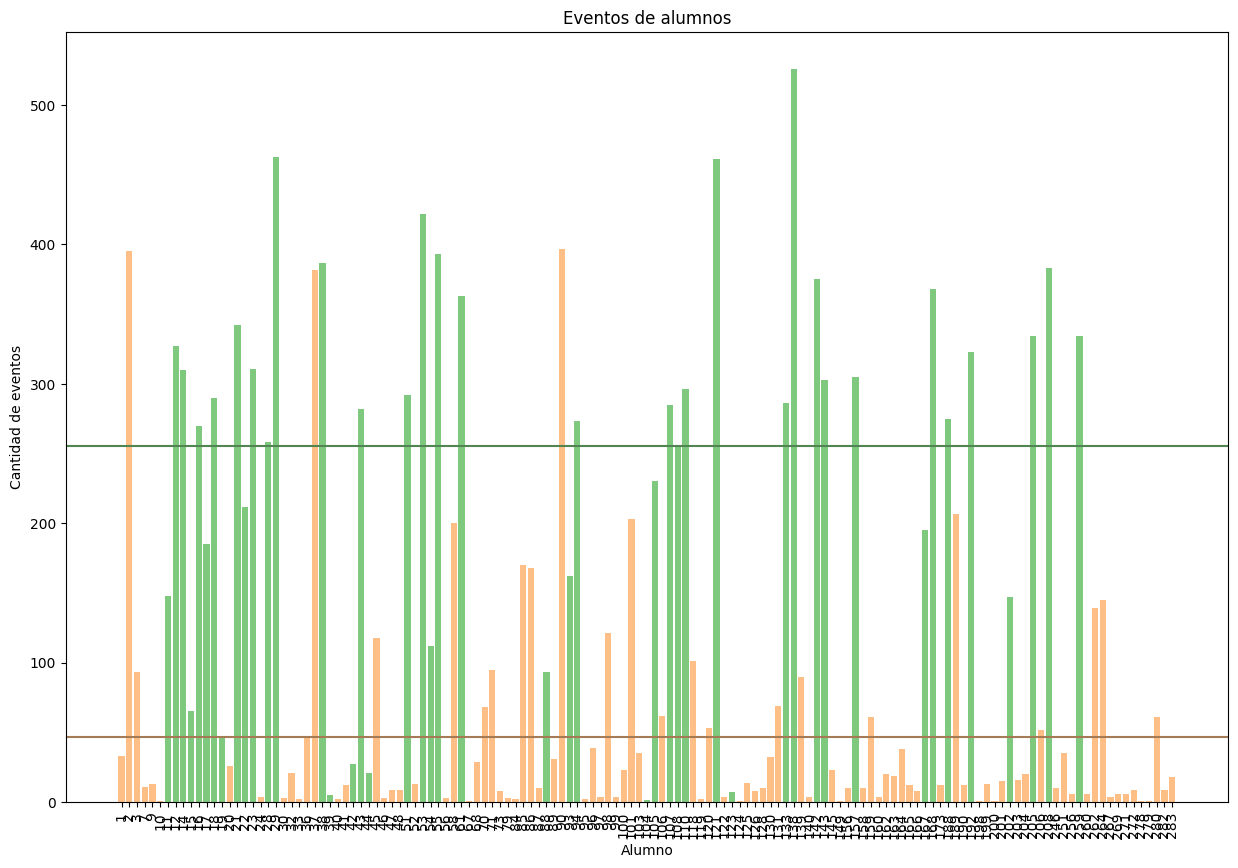

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

x_alumnos = eventos_totales[ids_alumnos]
y_eventos = eventos_totales[cantidad_eventos]

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de eventos')
ax.set_title('Eventos de alumnos')

eventos_totales_aprobados  = eventos_totales[(eventos_totales[ids_alumnos].isin(usuarios_ids_aprobados))]
media_aprobados = eventos_totales_aprobados[cantidad_eventos].mean()

eventos_totales_desaprobados  = eventos_totales[~(eventos_totales[ids_alumnos].isin(usuarios_ids_aprobados))]
media_desaprobados = eventos_totales_desaprobados[cantidad_eventos].mean()

col = []
for val in x_alumnos:
    if val in usuarios_ids_aprobados:
        col.append('#7fc97f')
    else:
        col.append('#febf86')

plt.axhline(y=media_aprobados, color='#518451', linestyle='-')
plt.axhline(y=media_desaprobados, color='#a47b55', linestyle='-')

plt.xticks(rotation='vertical')
plt.bar(x_alumnos.astype(str), y_eventos, color = col)

plt.show()

En el gráfico podemos ver que hay una gran diferencia en la cantidad de interacciones entre quienes aprobaron y quienes no.

Esto podría ser un importante indicador a la hora de detectar posibles desertores. Prestando especial atención a las medias, tanto para aprobados como desaprobados, podemos ir anticipandonos si la tendencia se va acercando a la deseada o no. 

Este mismo análisis podemos hacerlo por semana.

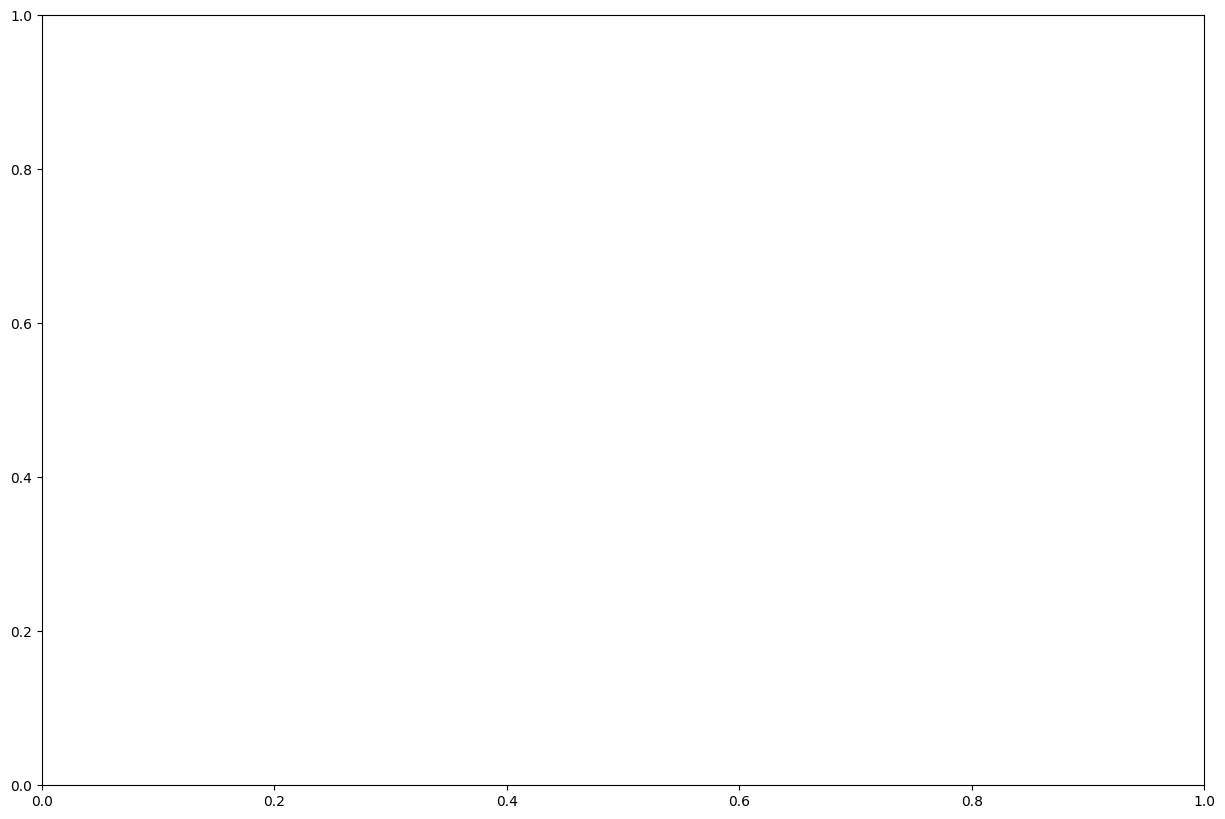

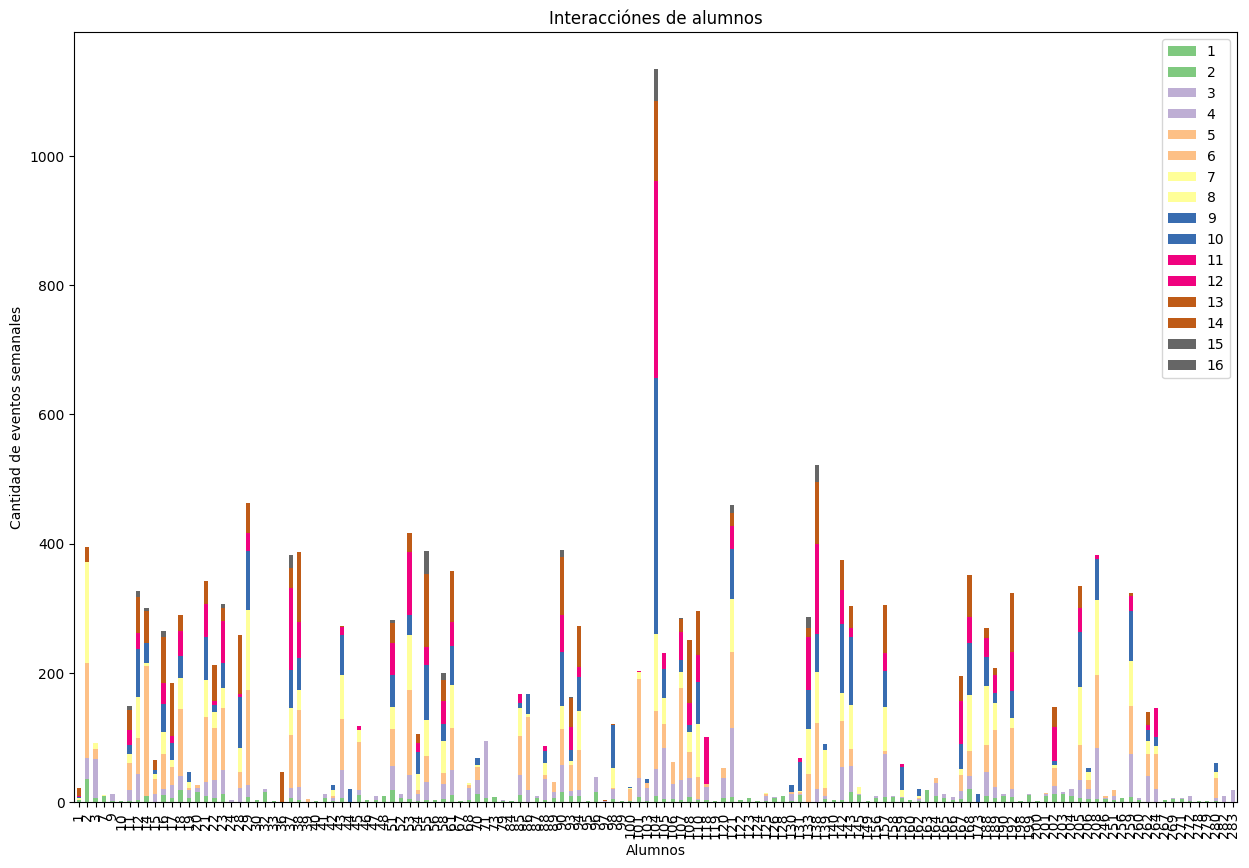

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

semanas = range(1,17)

for semana in semanas:
      eventos_semanales[semana] = eventos_semanales.apply(lambda x: x[cantidad_eventos] if x[indice_semana] == semana else 0, axis=1)
        
df = eventos_semanales.groupby(ids_alumnos).agg({1:'sum', 2: 'sum', 3: 'sum', 4: 'sum', 5: 'sum', 6: 'sum', 7: 'sum', 8: 'sum', 9: 'sum', 10: 'sum', 11: 'sum', 12: 'sum', 13: 'sum', 14: 'sum', 15: 'sum', 16: 'sum' }).reset_index()

ax = df.plot(x=ids_alumnos, kind='bar', stacked=True, title='Interacciónes de alumnos', figsize=(15, 10), colormap="Accent")
ax.set(xlabel='Alumnos', ylabel='Cantidad de eventos semanales')

plt.show()

Veamos en detalle las interacciones de algunos de los alumnos que no alcanzaron a terminar la materia:

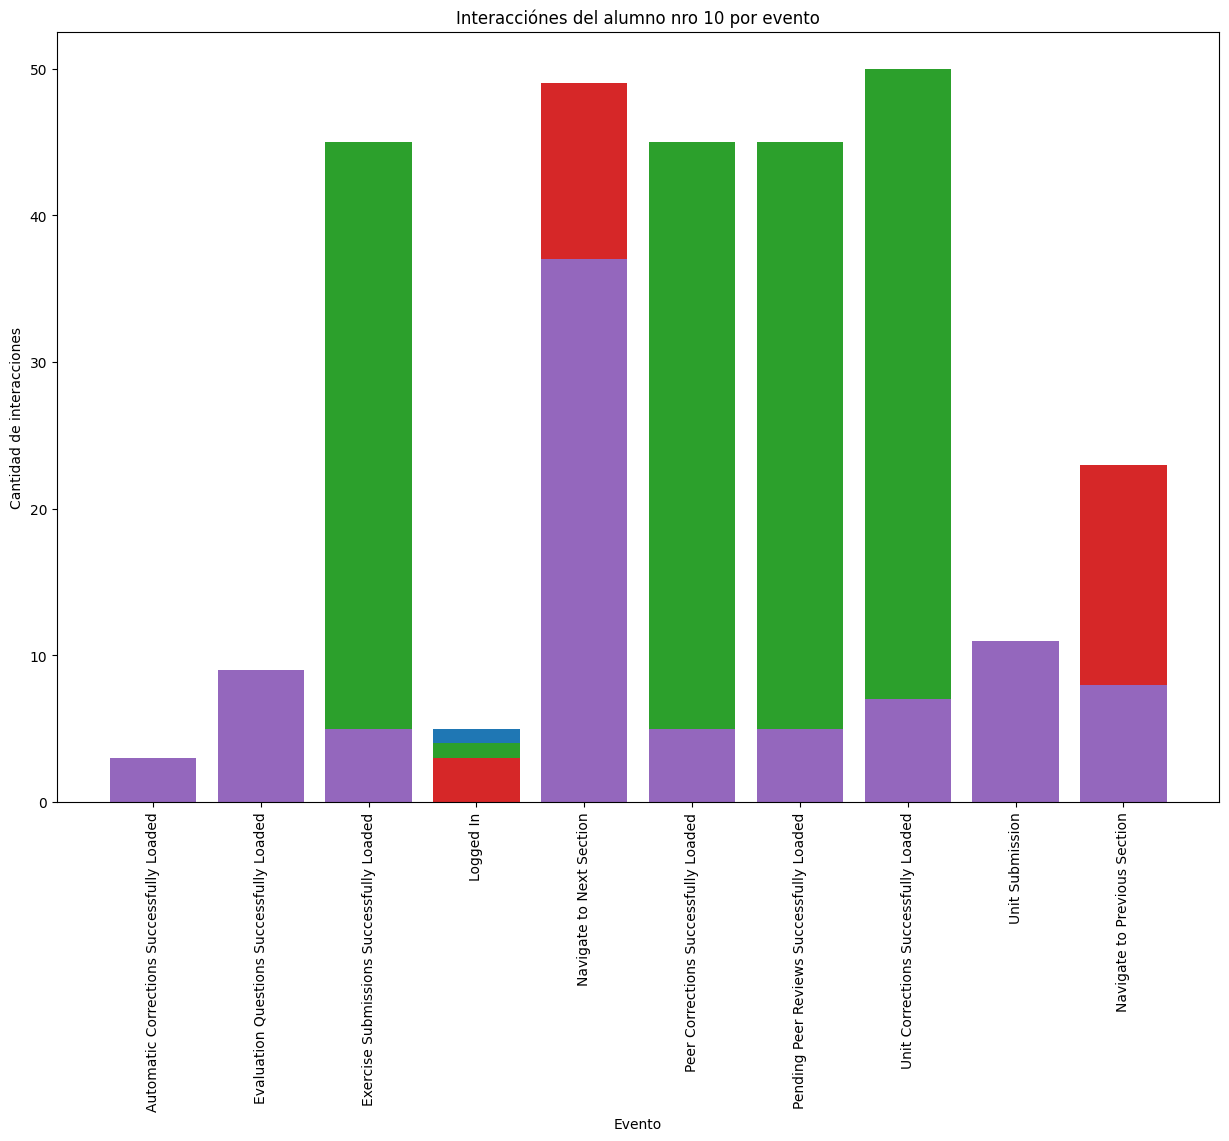

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

for alumno in [45, 71, 101, 118, 139]:
    eventos_alumno = eventos[eventos[ids_alumnos] == alumno]
    eventos_alumno_agrupados = eventos_alumno.groupby(accion_de_eventos)[cantidad_eventos].sum().reset_index(name=cantidad_eventos)

    x_alumnos = eventos_alumno_agrupados[accion_de_eventos].astype(str)
    y_eventos = eventos_alumno_agrupados[cantidad_eventos]

    ax.bar(x_alumnos, y_eventos)

    ax.set_xlabel('Evento')
    ax.set_ylabel('Cantidad de interacciones')
    ax.set_title('Interacciónes del alumno nro 10 por evento')

    
plt.xticks(rotation='vertical')
plt.show()

### Sesiones

Veamos cómo fue el uso promedio del sistema para los alumnos.

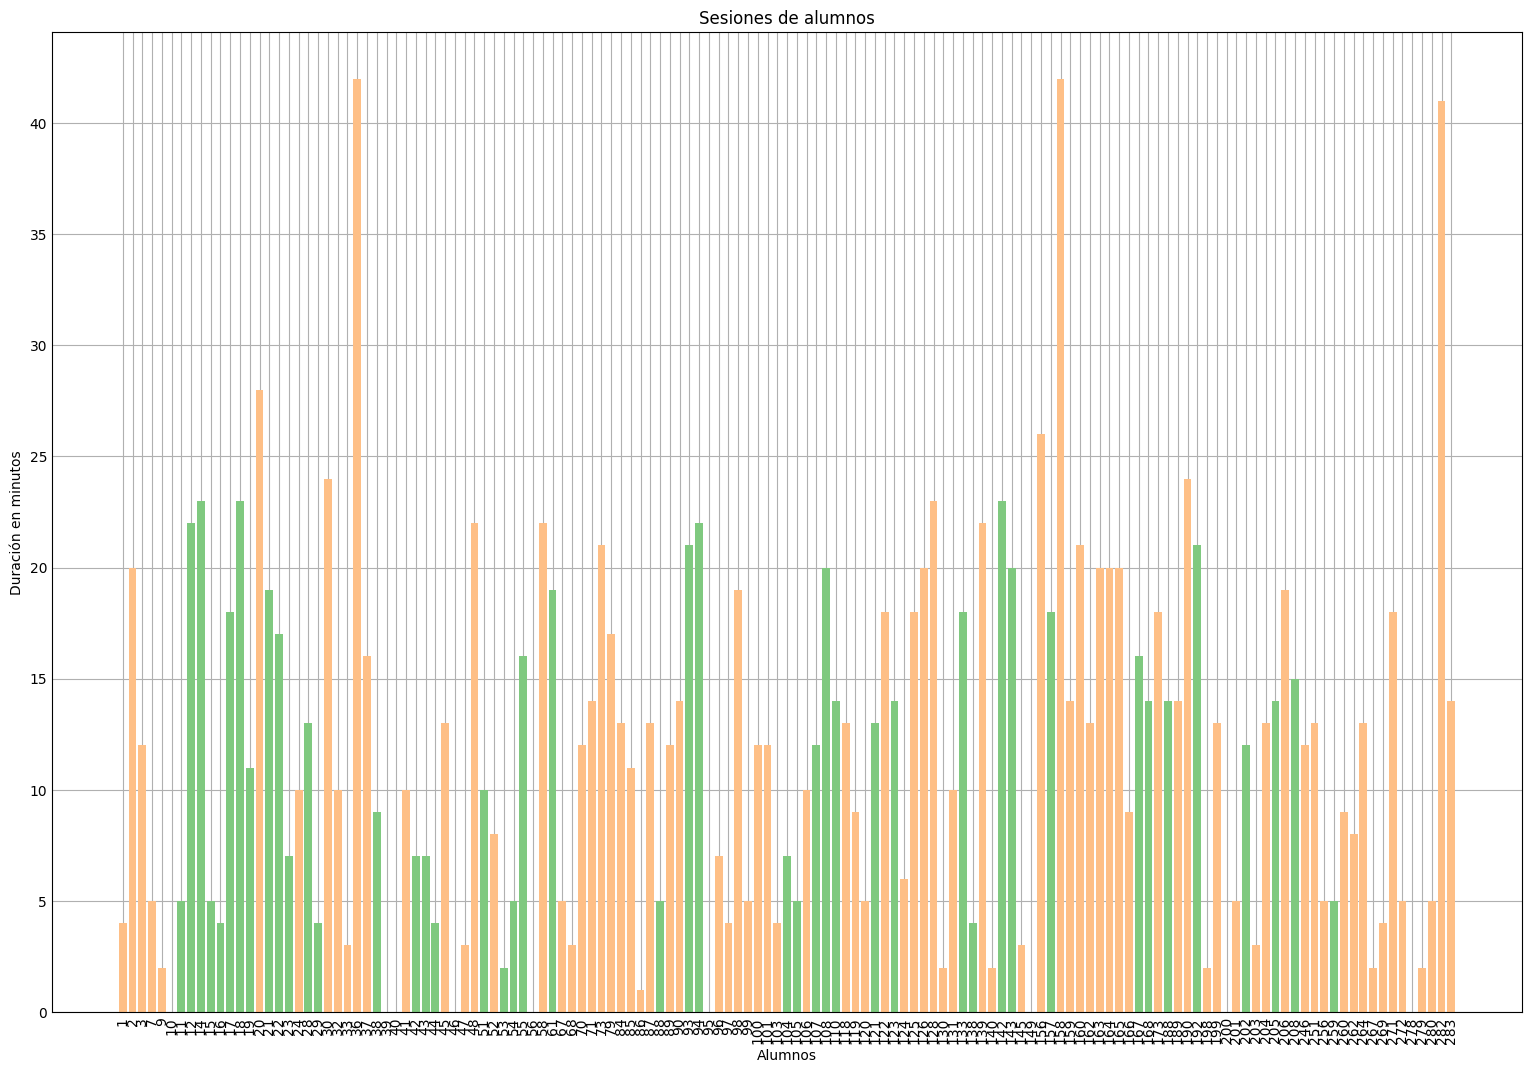

In [16]:
plt.style.use('_mpl-gallery')

duracion = 'Duración'

fig, ax = plt.subplots(figsize=(15, 10))

sesiones[duracion] = pd.to_datetime(sesiones[duracion_media], format='%H:%M:%S').dt.minute
# sesiones[ids_alumnos] = sesiones[ids_alumnos].astype(str)

x_alumnos = sesiones[ids_alumnos]
y_duracion = sesiones[duracion]

ax.set_xlabel('Alumnos')
ax.set_ylabel('Duración en minutos')
ax.set_title('Sesiones de alumnos')

x_alumnos

col = []
for val in x_alumnos:
    if val in usuarios_ids_aprobados:
        col.append('#7fc97f')
    else:
        col.append('#febf86')

plt.xticks(rotation='vertical')
plt.bar(x_alumnos.astype(str), y_duracion, color = col)

plt.show()

Del gráfico surgen algunas cuestiones que llaman la atención. Cuántas horas más tienen que dedicar en promedio quienes no aprueban vs quienes aprueban para que sea alarmante? Y lo mnismo en el otro sentido, cuantas horas menos?

Algunos alumnos estan muy por encima (36, 158 y 282) y por debajo (9, 86 y 146) del uso.

In [17]:
sesiones_semanales[duracion_media]

0      00:00:48
1      00:01:52
2      00:00:11
3      00:00:27
4      00:35:29
         ...   
883    00:03:58
884    00:53:32
885    00:04:08
886    00:23:50
887    00:09:47
Name: Duración media de la sesión, Length: 888, dtype: object

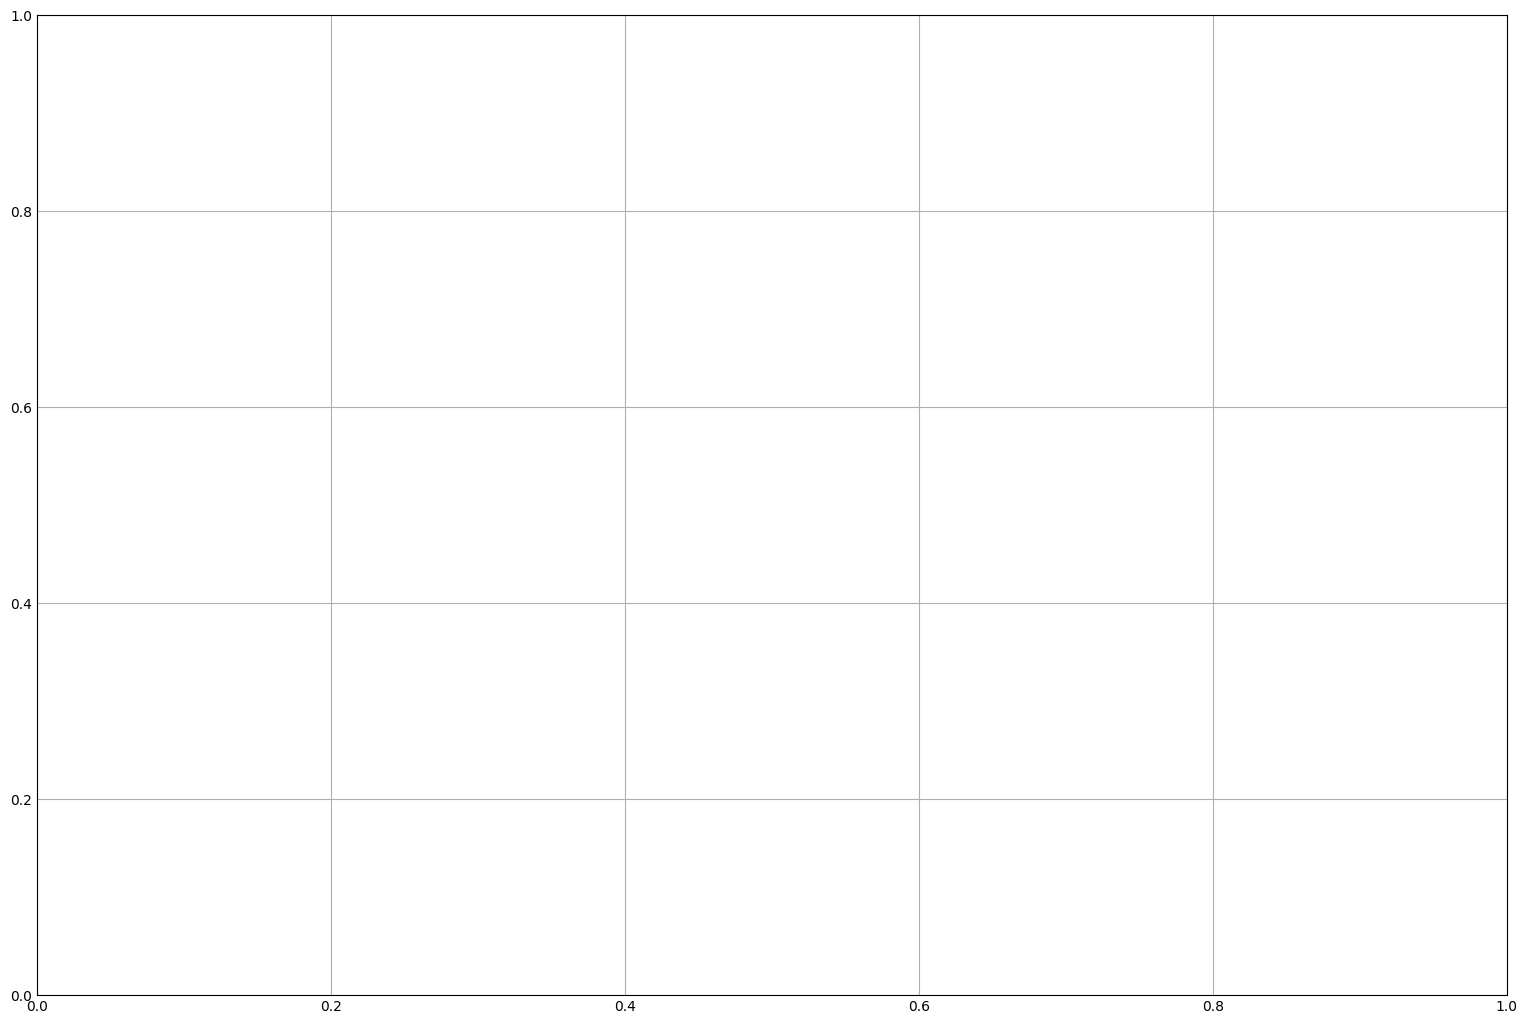

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))

semanas = range(1,17)

#sesiones_semanales[duracion] = pd.to_datetime(sesiones_semanales[duracion_media], format='%H:%M:%S').dt.minute

#for semana in semanas:
#      sesiones_semanales[semana] = sesiones_semanales.apply(lambda x: x[duracion] if x[indice_semana] == semana else '0', axis=1)
        
#df = sesiones_semanales.groupby(ids_alumnos).agg({1:'sum', 2: 'sum', 3: 'sum', 4: 'sum', 5: 'sum', 6: 'sum', 7: 'sum', 8: 'sum', 9: 'sum', 10: 'sum', 11: 'sum', 12: 'sum', 13: 'sum', 14: 'sum', 15: 'sum', 16: 'sum' }).reset_index()

#ax = df.plot(x=ids_alumnos, kind='bar', stacked=True, title='Interacciónes de alumnos', figsize=(15, 10), colormap="Accent")
#ax.set(xlabel='Alumnos', ylabel='Cantidad de interacciones semanales')

#plt.show()

### Entregas

Arranquemos por analizar cómo fueron las entregas de los alumnos a lo largo del cuatrimestre.

In [19]:
def entregas_por_fecha(entregas):

    entregas_por_fecha = entregas.extra({'date' : "date(datetime)"}).values('date').annotate(created_count=Count('id'))

    entregas_por_fecha_como_lista_de_tuplas = [(entrega['date'], entrega['created_count']) for entrega in entregas_por_fecha]
    return entregas_por_fecha_como_lista_de_tuplas

def entregas_por_fecha_as_dict(entregas):
    resultado = {}
    
    entregas_por_fecha = entregas.extra({'date' : "date(datetime)"}).values('date').annotate(created_count=Count('id'))
    
    for entrega_y_fecha in entregas_por_fecha:
        resultado[entrega_y_fecha['date']] = entrega_y_fecha['created_count']
    
    return resultado

def entregas_por_semana_as_dict(entregas):
    resultado = {}
    entregas_por_fecha = entregas_por_fecha_as_dict(entregas)
    
    for fecha, cantidad in entregas_por_fecha.items():
        semana = fecha.isocalendar()[1]
        if semana in resultado.keys():
            resultado[semana] += cantidad
        else:
            resultado[semana] = cantidad
            
    return resultado


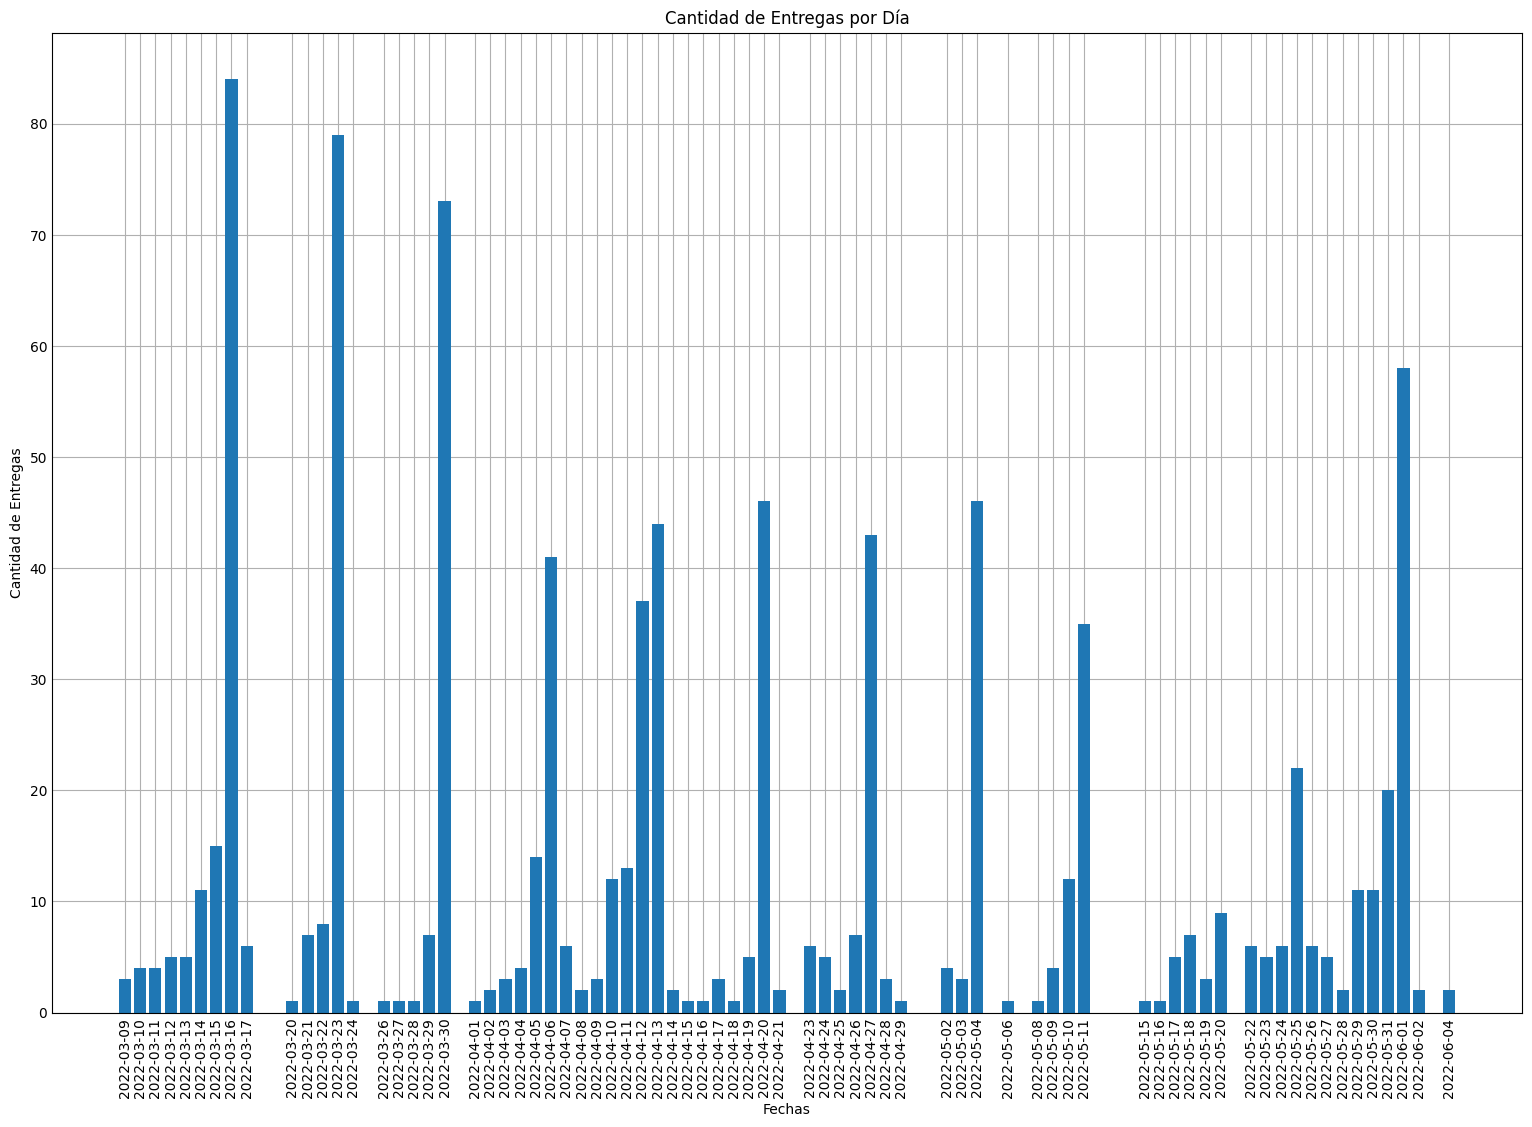

In [20]:
def plot_entregas_por_dia(entregas):
    entregas_por_fecha_como_lista_de_tuplas = entregas_por_fecha(entregas)

    plot_barras_desde_lista_de_tuplas(titulo='Cantidad de Entregas por Día', etiqueta_x='Fechas', 
                                      etiqueta_y='Cantidad de Entregas', 
                                      tuplas=entregas_por_fecha_como_lista_de_tuplas)
    
plot_entregas_por_dia(entregas=UnitSubmission.objects.all())

Teniendo en cuenta que las clases comenzaron el día 9 de Marzo del 2022, podemos ver que ya hubo entregas desde ese día. Los picos posteriores más altos se corresponden mayormente con los días de las clases (16/03, 23/03, 30/03). 

Las fechas correspondientes al 06/04 fueron de clase de Repaso-Parcial. Y los picos del 12/04 y 13/04 corresponden a la primer clase post parcial. 

Pero luego, tanto el 20/04, 27/04, 04/05 y 11/05 corresponden a los días de clases. 

Luego hubo dos semanas del Censo 2022 y Feriado correspondientes a 18/05 y 25/05, para ya terminar el 01/06 con el segundo Repaso-Parcial, motivo por el que se ven las últimas entregas. 

Esta visualización, sin embargo, nos muestra la cantidad de entregas realizadas por día. Sin embargo, no está escondiendo la cantidad de entregas de una misma persona realizadas en ese día (dado que todos pueden entregar varias veces). 

Analicemos a continuación si contamos las personas que entregaron por día en vez de la cantidad de entregas realizadas.

In [21]:
def alumnos_distintos_por_fecha_para(entregas):
    alumnos_por_fecha = {}
    for entrega in entregas: 
        fecha_de_entrega = entrega.datetime.date()
        if fecha_de_entrega in alumnos_por_fecha.keys():
            alumnos_por_fecha[fecha_de_entrega].append(entrega.student_record_id)
        else:
            alumnos_por_fecha[fecha_de_entrega] = [entrega.student_record_id]

    alumnos_distintos_por_fecha = {fecha: len(set(alumnos)) for fecha, alumnos in alumnos_por_fecha.items()}
    return alumnos_distintos_por_fecha


def plot_cantidad_de_alumnos_que_entregan_por_dia(entregas):
    alumnos_distintos_por_fecha = alumnos_distintos_por_fecha_para(entregas)

    plot_barras_desde_diccionario(titulo='Cantidad de Alumnos que entregaron por Día', etiqueta_x='Fechas', 
                                      etiqueta_y='Cantidad de Alumnos', 
                                      diccionario=alumnos_distintos_por_fecha)

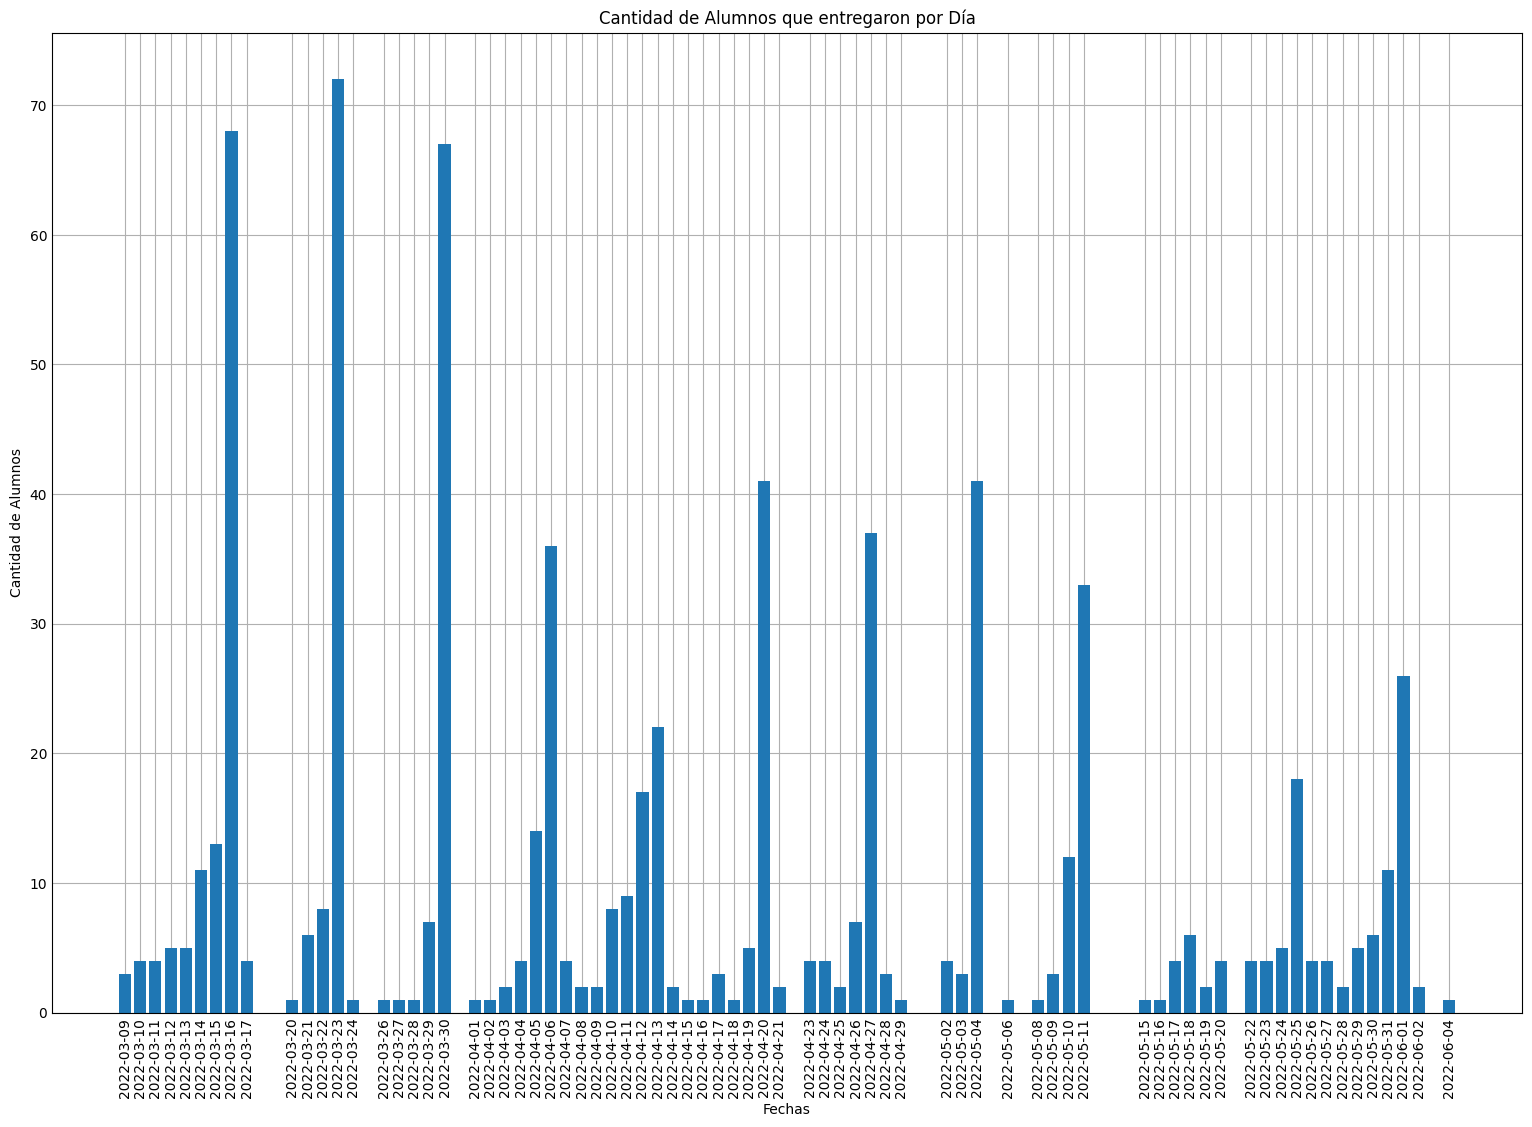

In [22]:
plot_cantidad_de_alumnos_que_entregan_por_dia(entregas=UnitSubmission.objects.all())

Podemos ver que el comportamiento de entrega que podemos es similar al del gráfico anterior pero en valores absolutos más chicos. 

Se pueden ver un par de eventos en particular como los cercanos a la fecha de la primera clase después del primer parcial (13/04), como los valores absolutos no se comparan con el resto de la semana a diferencia del gráfico anterior. Situación similar ocurre con las fechas de las últimas entregas (fecha del segundo parcial el día 01/06).

Sería interesante revisar la cantidad de entregas de cada una de las unidades por día para entender el comportamiento. La hipótesis es que la mayor parte de las entregas de cada capítulo se darán continuas a la fecha de la clase y su correspondiente día de entrega. A final del semestre puede suceder algo distinto porque la gente entregará lo que debe del cuatrimestre. Sin embargo, entender a esas personas (que no pudieron estar al día) puede darnos una idea analizar en particular su comportamiento con el sistema. Otro punto interesante a encontrar para luego analizar específicamente es si hay gente entregando atrasado a lo largo del cuatrimestre.  

In [23]:
fechas_de_entregas = UnitSubmission.objects.order_by('datetime').values('datetime')

fecha_primera_entrega = fechas_de_entregas.first()['datetime'].date()
fecha_ultima_entrega = fechas_de_entregas.last()['datetime'].date()

todas_las_fechas = [fecha_primera_entrega + timedelta(days=i) for i in range((fecha_ultima_entrega - fecha_primera_entrega).days)]

def agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_as_dict, todas_las_fechas):
    resultado = {}
    
    for fecha in todas_las_fechas:
        if fecha in entregas_por_fecha_as_dict.keys():
            resultado[fecha] = entregas_por_fecha_as_dict[fecha]
        else:
            resultado[fecha] = 0
            
    return resultado

In [24]:
entregas_1 = UnitSubmission.objects.filter(unit=1)
entregas_2 = UnitSubmission.objects.filter(unit=2)
entregas_3 = UnitSubmission.objects.filter(unit=3)
entregas_4 = UnitSubmission.objects.filter(unit=4)
entregas_5 = UnitSubmission.objects.filter(unit=5)
entregas_6 = UnitSubmission.objects.filter(unit=6)
entregas_7 = UnitSubmission.objects.filter(unit=7)
entregas_8 = UnitSubmission.objects.filter(unit=8)
entregas_9 = UnitSubmission.objects.filter(unit=9)

entregas_por_fecha_unidad_1 = entregas_por_fecha_as_dict(entregas_1)
entregas_por_fecha_unidad_2 = entregas_por_fecha_as_dict(entregas_2)
entregas_por_fecha_unidad_3 = entregas_por_fecha_as_dict(entregas_3)
entregas_por_fecha_unidad_4 = entregas_por_fecha_as_dict(entregas_4)
entregas_por_fecha_unidad_5 = entregas_por_fecha_as_dict(entregas_5)
entregas_por_fecha_unidad_6 = entregas_por_fecha_as_dict(entregas_6)
entregas_por_fecha_unidad_7 = entregas_por_fecha_as_dict(entregas_7)
entregas_por_fecha_unidad_8 = entregas_por_fecha_as_dict(entregas_8)
entregas_por_fecha_unidad_9 = entregas_por_fecha_as_dict(entregas_9)

entregas_por_fecha_unidad_1 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_1, todas_las_fechas)
entregas_por_fecha_unidad_2 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_2, todas_las_fechas)
entregas_por_fecha_unidad_3 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_3, todas_las_fechas)
entregas_por_fecha_unidad_4 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_4, todas_las_fechas)
entregas_por_fecha_unidad_5 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_5, todas_las_fechas)
entregas_por_fecha_unidad_6 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_6, todas_las_fechas)
entregas_por_fecha_unidad_7 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_7, todas_las_fechas)
entregas_por_fecha_unidad_8 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_8, todas_las_fechas)
entregas_por_fecha_unidad_9 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_9, todas_las_fechas)

In [25]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_fechas, entregas_por_fecha_unidad_1.values(), entregas_por_fecha_unidad_2.values(), 
                  entregas_por_fecha_unidad_3.values(), entregas_por_fecha_unidad_4.values(), 
                  entregas_por_fecha_unidad_5.values(), entregas_por_fecha_unidad_6.values(), 
                  entregas_por_fecha_unidad_7.values(), entregas_por_fecha_unidad_8.values(),
                  entregas_por_fecha_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Fecha', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Fecha,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,2022-03-09,3,0,0,0,0,0,0,0,0
1,2022-03-10,4,0,0,0,0,0,0,0,0
2,2022-03-11,4,0,0,0,0,0,0,0,0
3,2022-03-12,5,0,0,0,0,0,0,0,0
4,2022-03-13,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
82,2022-05-30,0,0,0,0,2,2,1,3,3
83,2022-05-31,0,0,0,0,3,3,4,3,7
84,2022-06-01,0,1,3,2,7,8,10,10,17
85,2022-06-02,0,0,0,0,0,0,0,0,2


<AxesSubplot: title={'center': 'Stacked Bar Graph by dataframe'}, xlabel='Fecha'>

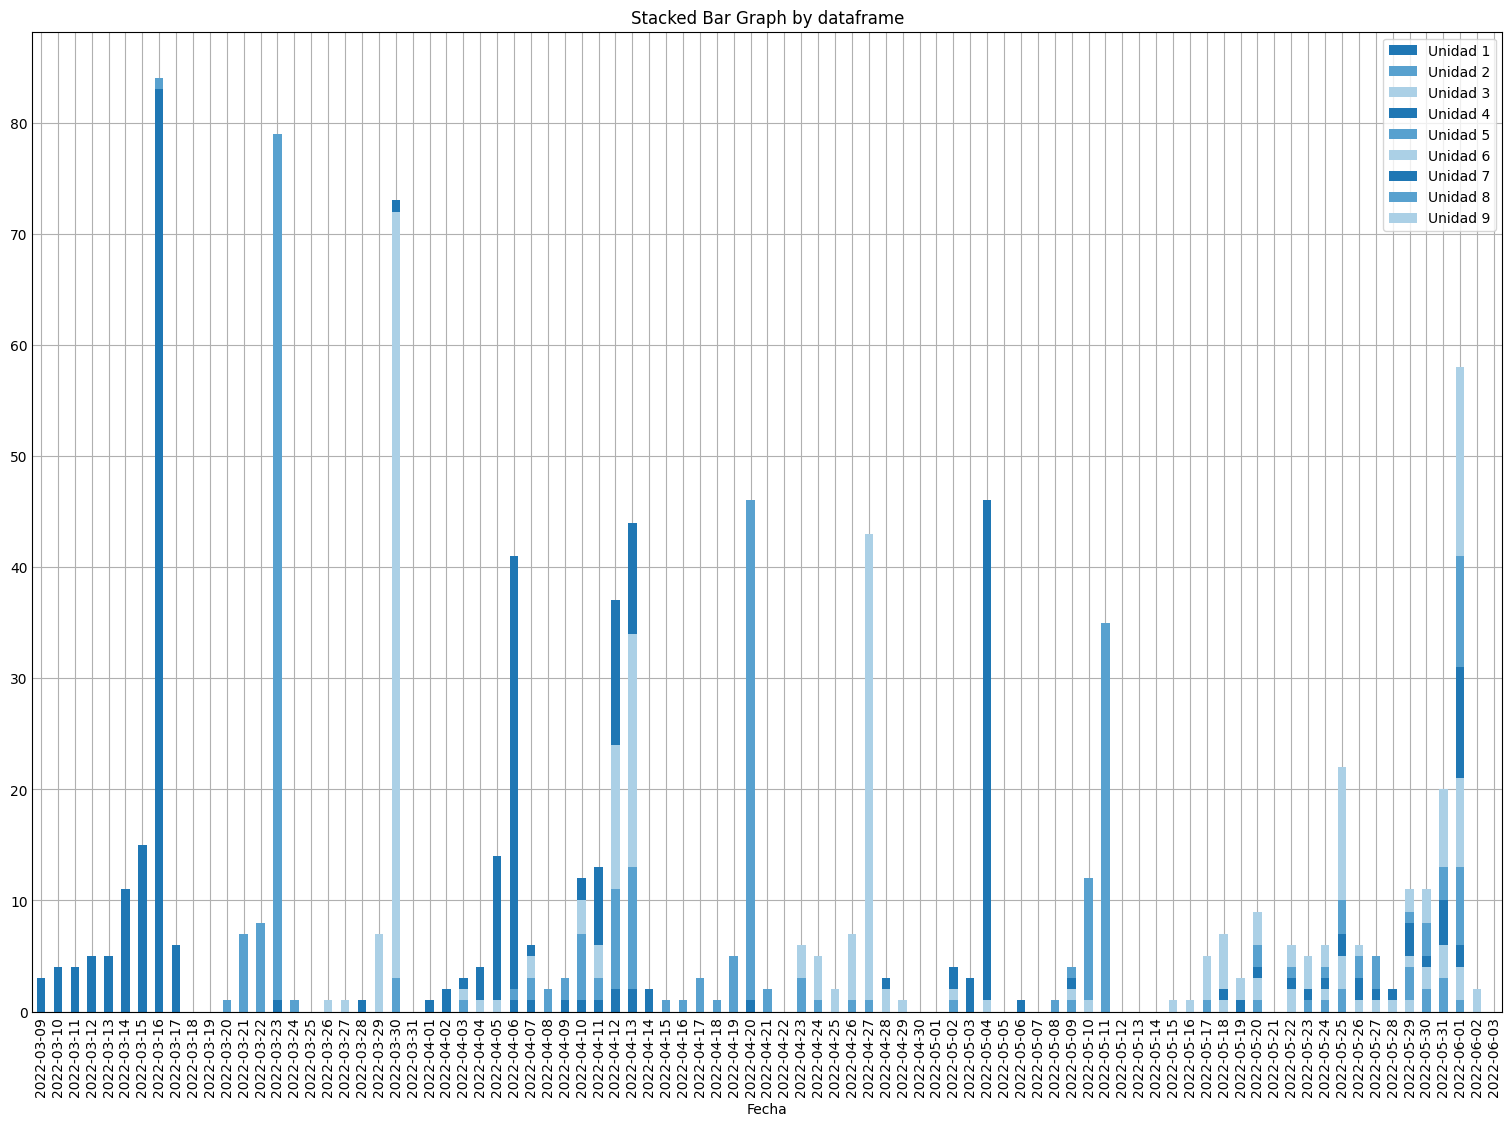

In [26]:
# plot data in stack manner of bar type
df.plot(x='Fecha', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(15, 10))

Primeras conclusiones que podemos ver de estos gráficos. Claramente la mayor cantidad de entregas que sucede es sobre la fecha que deben entregar. Sin embargo, en la mayor parte de los casos podemos encontrar alguna entrega de alguna unidad anterior el mismo día. Son pocos los casos, pero tal vez son interesantes para analizar y ver si retrasarse en las entregas nos dice algo sobre si la persona terminará dejando o no. 

Por otro lado, las fechas de los exámenes o fin de cursada son de entrega más pareja entre unidades. Tal vez analizar algo de dificultad de la unidad sobre esto? Existen más entregas de unidades más actuales porque son más actuales o porque son más dificiles? 

También podemos ver que no hay tantas entregas de la primera parte de la materia después del primer parcial. Parecería que es casi borrón y cuenta nueva. Hay unos pocos casos de la unidad 3 y la unidad 4 (más difíciles o simplemente la gente se atrasó eso?).


La granularidad por día para este caso no ayuda mucho. Probemos hacer el mismo gráfico por semana.

In [27]:
fechas_de_entregas = UnitSubmission.objects.order_by('datetime').values('datetime')

semana_primera_entrega = fechas_de_entregas.first()['datetime'].isocalendar()[1]
semana_ultima_entrega = fechas_de_entregas.last()['datetime'].isocalendar()[1]

todas_las_semanas = list(range(semana_primera_entrega, semana_ultima_entrega))

def agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_as_dict, todas_las_semanas):
    resultado = {}
    
    for semana in todas_las_semanas:
        if semana in entregas_por_semana_as_dict.keys():
            resultado[semana] = entregas_por_semana_as_dict[semana]
        else:
            resultado[semana] = 0
            
    return resultado

In [28]:
entregas_por_semana_unidad_1 = entregas_por_semana_as_dict(entregas_1)
entregas_por_semana_unidad_2 = entregas_por_semana_as_dict(entregas_2)
entregas_por_semana_unidad_3 = entregas_por_semana_as_dict(entregas_3)
entregas_por_semana_unidad_4 = entregas_por_semana_as_dict(entregas_4)
entregas_por_semana_unidad_5 = entregas_por_semana_as_dict(entregas_5)
entregas_por_semana_unidad_6 = entregas_por_semana_as_dict(entregas_6)
entregas_por_semana_unidad_7 = entregas_por_semana_as_dict(entregas_7)
entregas_por_semana_unidad_8 = entregas_por_semana_as_dict(entregas_8)
entregas_por_semana_unidad_9 = entregas_por_semana_as_dict(entregas_9)

entregas_por_semana_unidad_1 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_1, todas_las_semanas)
entregas_por_semana_unidad_2 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_2, todas_las_semanas)
entregas_por_semana_unidad_3 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_3, todas_las_semanas)
entregas_por_semana_unidad_4 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_4, todas_las_semanas)
entregas_por_semana_unidad_5 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_5, todas_las_semanas)
entregas_por_semana_unidad_6 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_6, todas_las_semanas)
entregas_por_semana_unidad_7 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_7, todas_las_semanas)
entregas_por_semana_unidad_8 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_8, todas_las_semanas)
entregas_por_semana_unidad_9 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_9, todas_las_semanas)

In [29]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_semanas, entregas_por_semana_unidad_1.values(), entregas_por_semana_unidad_2.values(), 
                  entregas_por_semana_unidad_3.values(), entregas_por_semana_unidad_4.values(), 
                  entregas_por_semana_unidad_5.values(), entregas_por_semana_unidad_6.values(), 
                  entregas_por_semana_unidad_7.values(), entregas_por_semana_unidad_8.values(),
                  entregas_por_semana_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Semana', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Semana,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,10,21,0,0,0,0,0,0,0,0
1,11,115,2,0,0,0,0,0,0,0
2,12,1,94,2,0,0,0,0,0,0
3,13,1,4,77,5,0,0,0,0,0
4,14,4,13,7,58,0,0,0,0,0
5,15,5,22,37,32,5,0,0,0,0
6,16,0,0,0,1,57,7,0,0,0
7,17,0,0,1,0,2,52,1,0,0
8,18,0,0,0,0,1,2,51,1,0
9,19,0,0,0,0,1,2,1,47,1


<AxesSubplot: title={'center': 'Entregas por semana y por unidad'}, xlabel='Semana'>

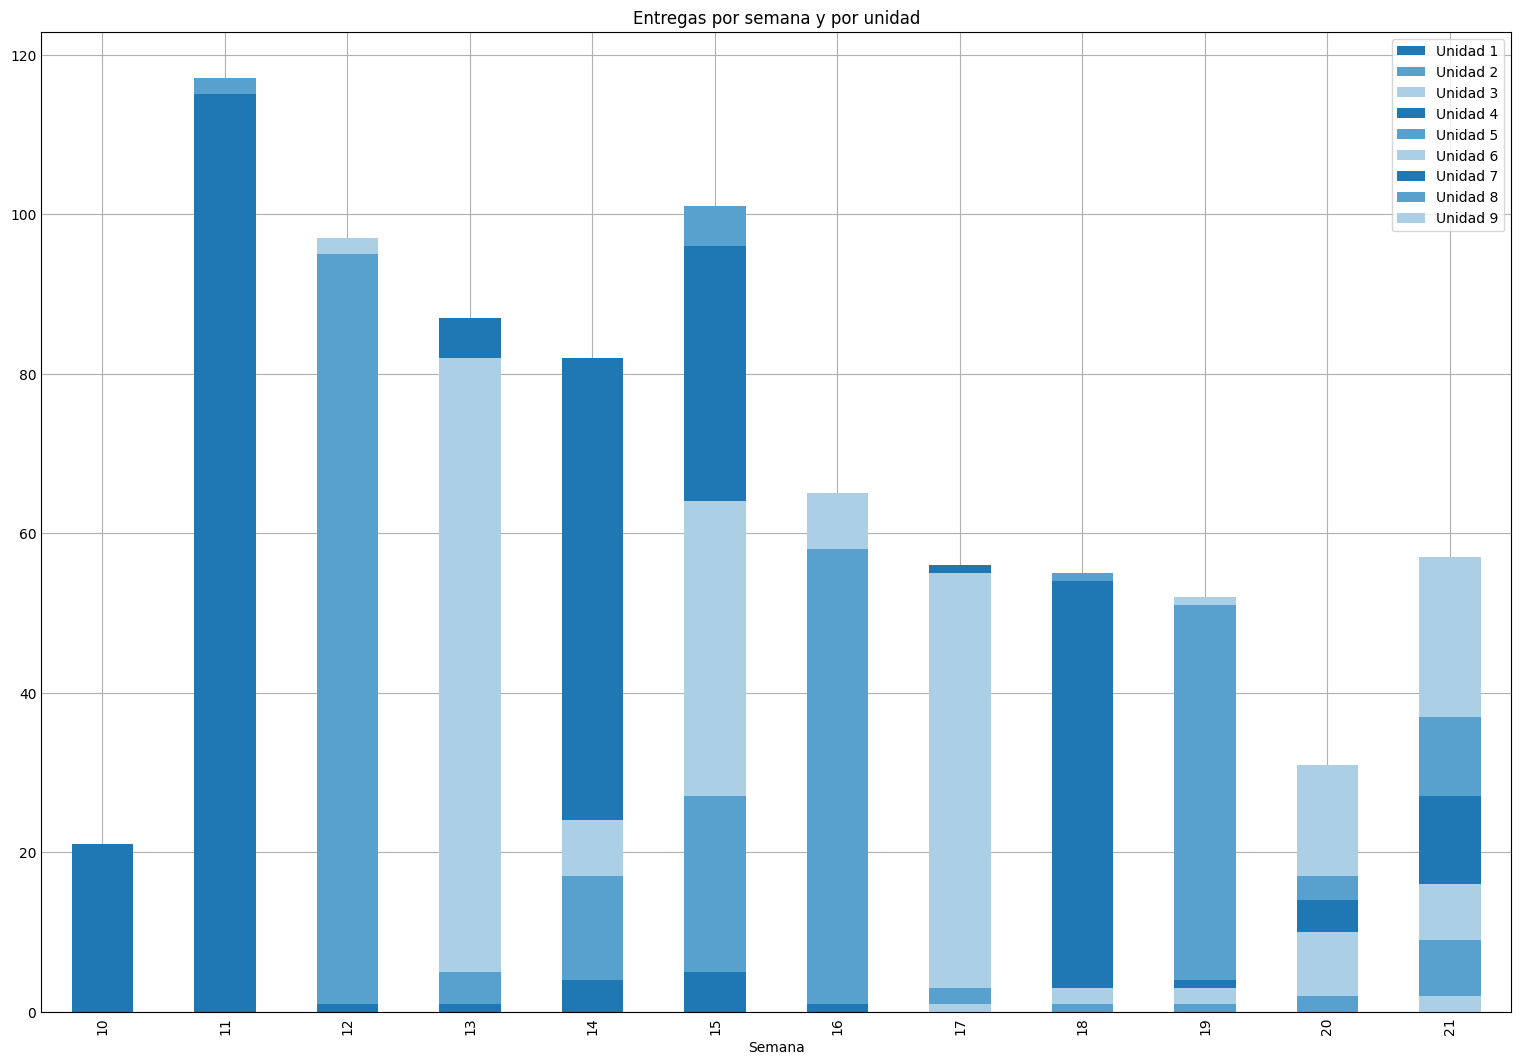

In [30]:
# plot data in stack manner of bar type
df.plot(x='Semana', kind='bar', stacked=True,
        title='Entregas por semana y por unidad', figsize=(15, 10))

La representación por semana es a partir de semana calendario y no las semanas de cursada (de miércoles a miércoles). Por eso es importante ver quienes "se adelantan" haciendo la semana anterior a la entrega (que es la que da mayor cantidad. Y también es interesante poder ver como la gente se empieza a atrasar. Por ahí esos casos nos pueden llegar a servir para identificar gente que puede llegar a dejar. 

Hagamos el mismo análisis hecho hasta ahora pero solo tomando los alumnos aprobados para ver como fue su comportamiento. 

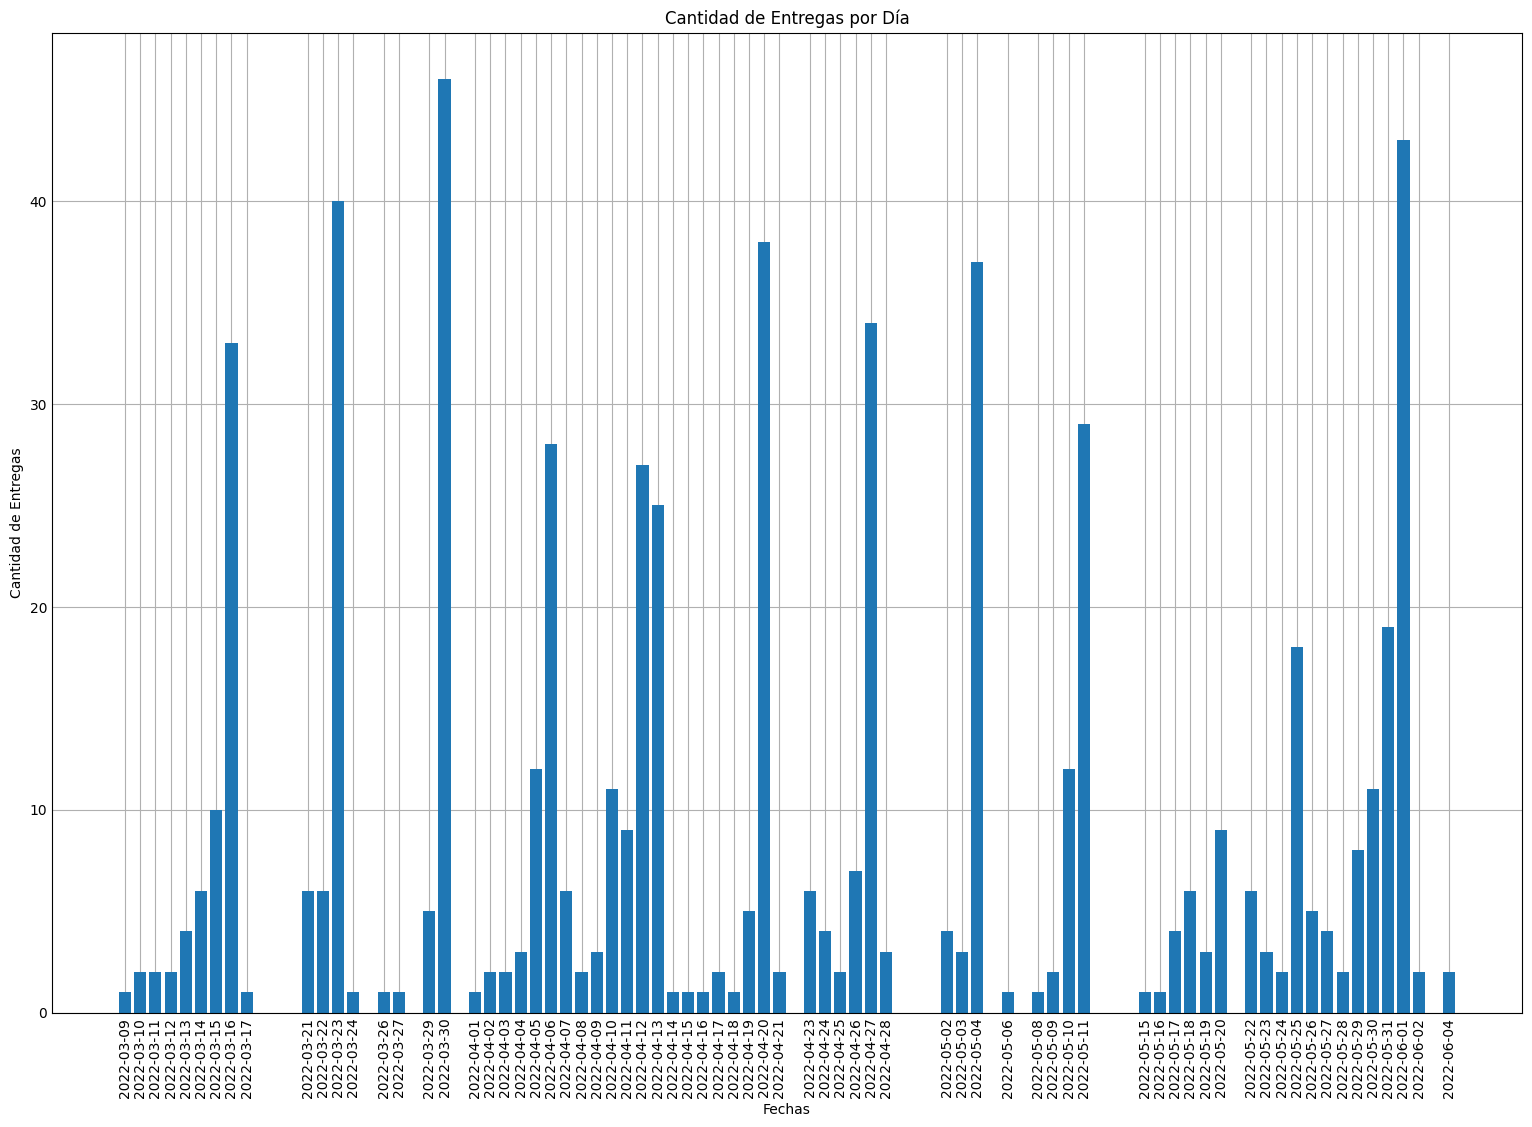

In [31]:
entregas_aprobados = UnitSubmission.objects.filter(student_record__in=alumnos_aprobados)

plot_entregas_por_dia(entregas=entregas_aprobados)


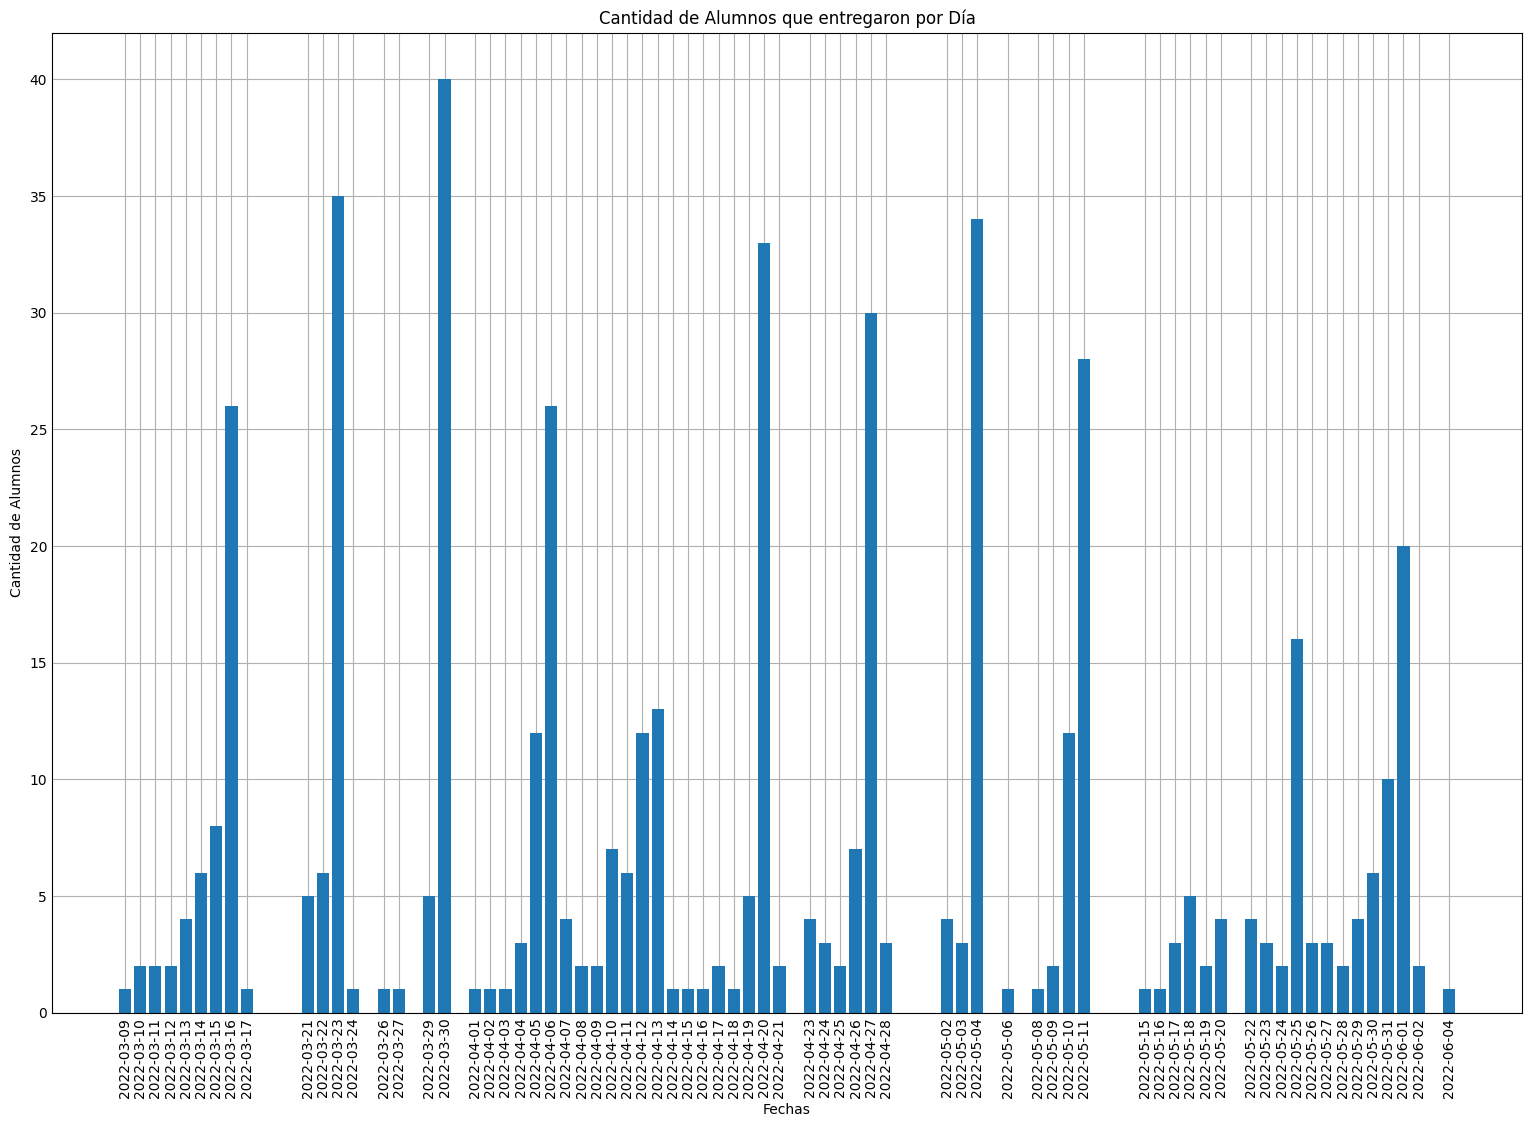

In [32]:
plot_cantidad_de_alumnos_que_entregan_por_dia(entregas=entregas_aprobados)

In [33]:
# Revisar como sacar código repetido

entregas_1 = entregas_aprobados.filter(unit=1)
entregas_2 = entregas_aprobados.filter(unit=2)
entregas_3 = entregas_aprobados.filter(unit=3)
entregas_4 = entregas_aprobados.filter(unit=4)
entregas_5 = entregas_aprobados.filter(unit=5)
entregas_6 = entregas_aprobados.filter(unit=6)
entregas_7 = entregas_aprobados.filter(unit=7)
entregas_8 = entregas_aprobados.filter(unit=8)
entregas_9 = entregas_aprobados.filter(unit=9)

entregas_por_fecha_unidad_1 = entregas_por_fecha_as_dict(entregas_1)
entregas_por_fecha_unidad_2 = entregas_por_fecha_as_dict(entregas_2)
entregas_por_fecha_unidad_3 = entregas_por_fecha_as_dict(entregas_3)
entregas_por_fecha_unidad_4 = entregas_por_fecha_as_dict(entregas_4)
entregas_por_fecha_unidad_5 = entregas_por_fecha_as_dict(entregas_5)
entregas_por_fecha_unidad_6 = entregas_por_fecha_as_dict(entregas_6)
entregas_por_fecha_unidad_7 = entregas_por_fecha_as_dict(entregas_7)
entregas_por_fecha_unidad_8 = entregas_por_fecha_as_dict(entregas_8)
entregas_por_fecha_unidad_9 = entregas_por_fecha_as_dict(entregas_9)

entregas_por_fecha_unidad_1 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_1, todas_las_fechas)
entregas_por_fecha_unidad_2 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_2, todas_las_fechas)
entregas_por_fecha_unidad_3 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_3, todas_las_fechas)
entregas_por_fecha_unidad_4 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_4, todas_las_fechas)
entregas_por_fecha_unidad_5 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_5, todas_las_fechas)
entregas_por_fecha_unidad_6 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_6, todas_las_fechas)
entregas_por_fecha_unidad_7 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_7, todas_las_fechas)
entregas_por_fecha_unidad_8 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_8, todas_las_fechas)
entregas_por_fecha_unidad_9 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_9, todas_las_fechas)

In [34]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_fechas, entregas_por_fecha_unidad_1.values(), entregas_por_fecha_unidad_2.values(), 
                  entregas_por_fecha_unidad_3.values(), entregas_por_fecha_unidad_4.values(), 
                  entregas_por_fecha_unidad_5.values(), entregas_por_fecha_unidad_6.values(), 
                  entregas_por_fecha_unidad_7.values(), entregas_por_fecha_unidad_8.values(),
                  entregas_por_fecha_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Fecha', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Fecha,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,2022-03-09,1,0,0,0,0,0,0,0,0
1,2022-03-10,2,0,0,0,0,0,0,0,0
2,2022-03-11,2,0,0,0,0,0,0,0,0
3,2022-03-12,2,0,0,0,0,0,0,0,0
4,2022-03-13,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
82,2022-05-30,0,0,0,0,2,2,1,3,3
83,2022-05-31,0,0,0,0,3,2,4,3,7
84,2022-06-01,0,1,2,1,6,5,7,6,15
85,2022-06-02,0,0,0,0,0,0,0,0,2


<AxesSubplot: title={'center': 'Stacked Bar Graph by dataframe'}, xlabel='Fecha'>

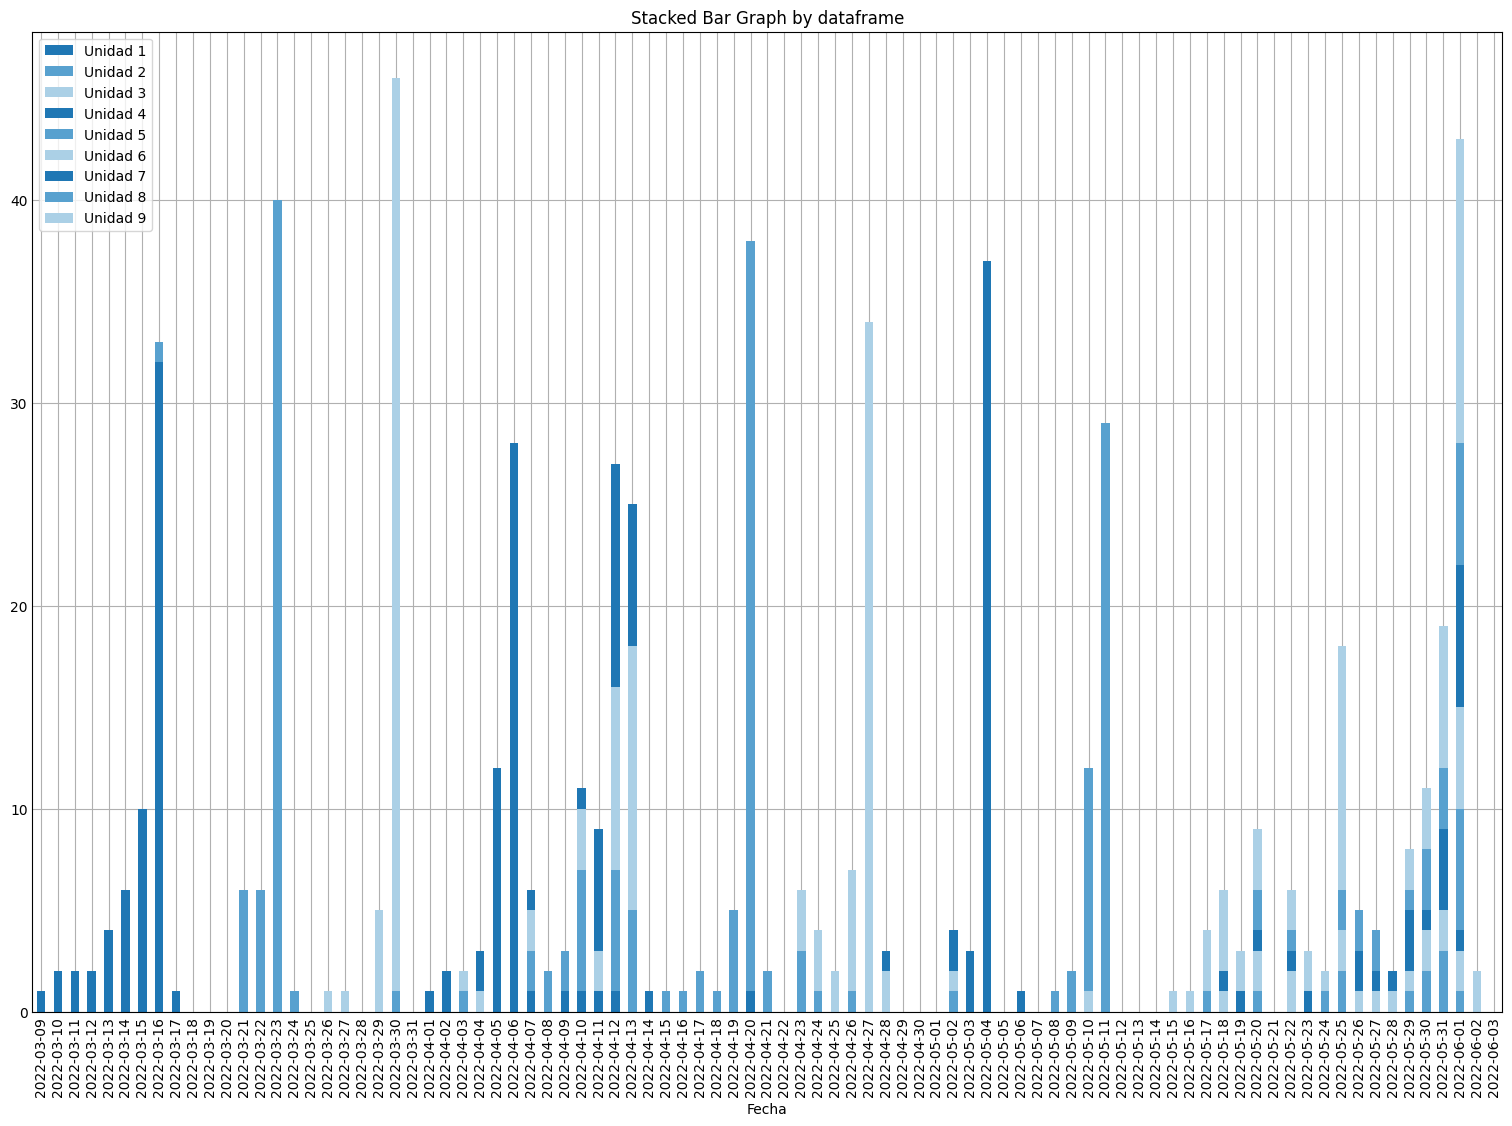

In [35]:
# plot data in stack manner of bar type
df.plot(x='Fecha', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(15, 10))

### PREGUNTA PARA RESOLVER WIP TODO
Por qué sube de la unidad 1 a la 3? La gente está llegando más tarde a entregar?

Habria que mirar color por color

In [36]:
entregas_por_semana_unidad_1 = entregas_por_semana_as_dict(entregas_1)
entregas_por_semana_unidad_2 = entregas_por_semana_as_dict(entregas_2)
entregas_por_semana_unidad_3 = entregas_por_semana_as_dict(entregas_3)
entregas_por_semana_unidad_4 = entregas_por_semana_as_dict(entregas_4)
entregas_por_semana_unidad_5 = entregas_por_semana_as_dict(entregas_5)
entregas_por_semana_unidad_6 = entregas_por_semana_as_dict(entregas_6)
entregas_por_semana_unidad_7 = entregas_por_semana_as_dict(entregas_7)
entregas_por_semana_unidad_8 = entregas_por_semana_as_dict(entregas_8)
entregas_por_semana_unidad_9 = entregas_por_semana_as_dict(entregas_9)

entregas_por_semana_unidad_1 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_1, todas_las_semanas)
entregas_por_semana_unidad_2 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_2, todas_las_semanas)
entregas_por_semana_unidad_3 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_3, todas_las_semanas)
entregas_por_semana_unidad_4 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_4, todas_las_semanas)
entregas_por_semana_unidad_5 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_5, todas_las_semanas)
entregas_por_semana_unidad_6 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_6, todas_las_semanas)
entregas_por_semana_unidad_7 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_7, todas_las_semanas)
entregas_por_semana_unidad_8 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_8, todas_las_semanas)
entregas_por_semana_unidad_9 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_9, todas_las_semanas)

In [37]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_semanas, entregas_por_semana_unidad_1.values(), entregas_por_semana_unidad_2.values(), 
                  entregas_por_semana_unidad_3.values(), entregas_por_semana_unidad_4.values(), 
                  entregas_por_semana_unidad_5.values(), entregas_por_semana_unidad_6.values(), 
                  entregas_por_semana_unidad_7.values(), entregas_por_semana_unidad_8.values(),
                  entregas_por_semana_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Semana', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Semana,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,10,11,0,0,0,0,0,0,0,0
1,11,49,1,0,0,0,0,0,0,0
2,12,0,53,2,0,0,0,0,0,0
3,13,0,2,51,3,0,0,0,0,0
4,14,3,12,6,44,0,0,0,0,0
5,15,2,11,24,25,4,0,0,0,0
6,16,0,0,0,1,49,6,0,0,0
7,17,0,0,0,0,1,44,1,0,0
8,18,0,0,0,0,1,1,43,1,0
9,19,0,0,0,0,1,1,0,41,1


<AxesSubplot: title={'center': 'Entregas por semana y por unidad'}, xlabel='Semana'>

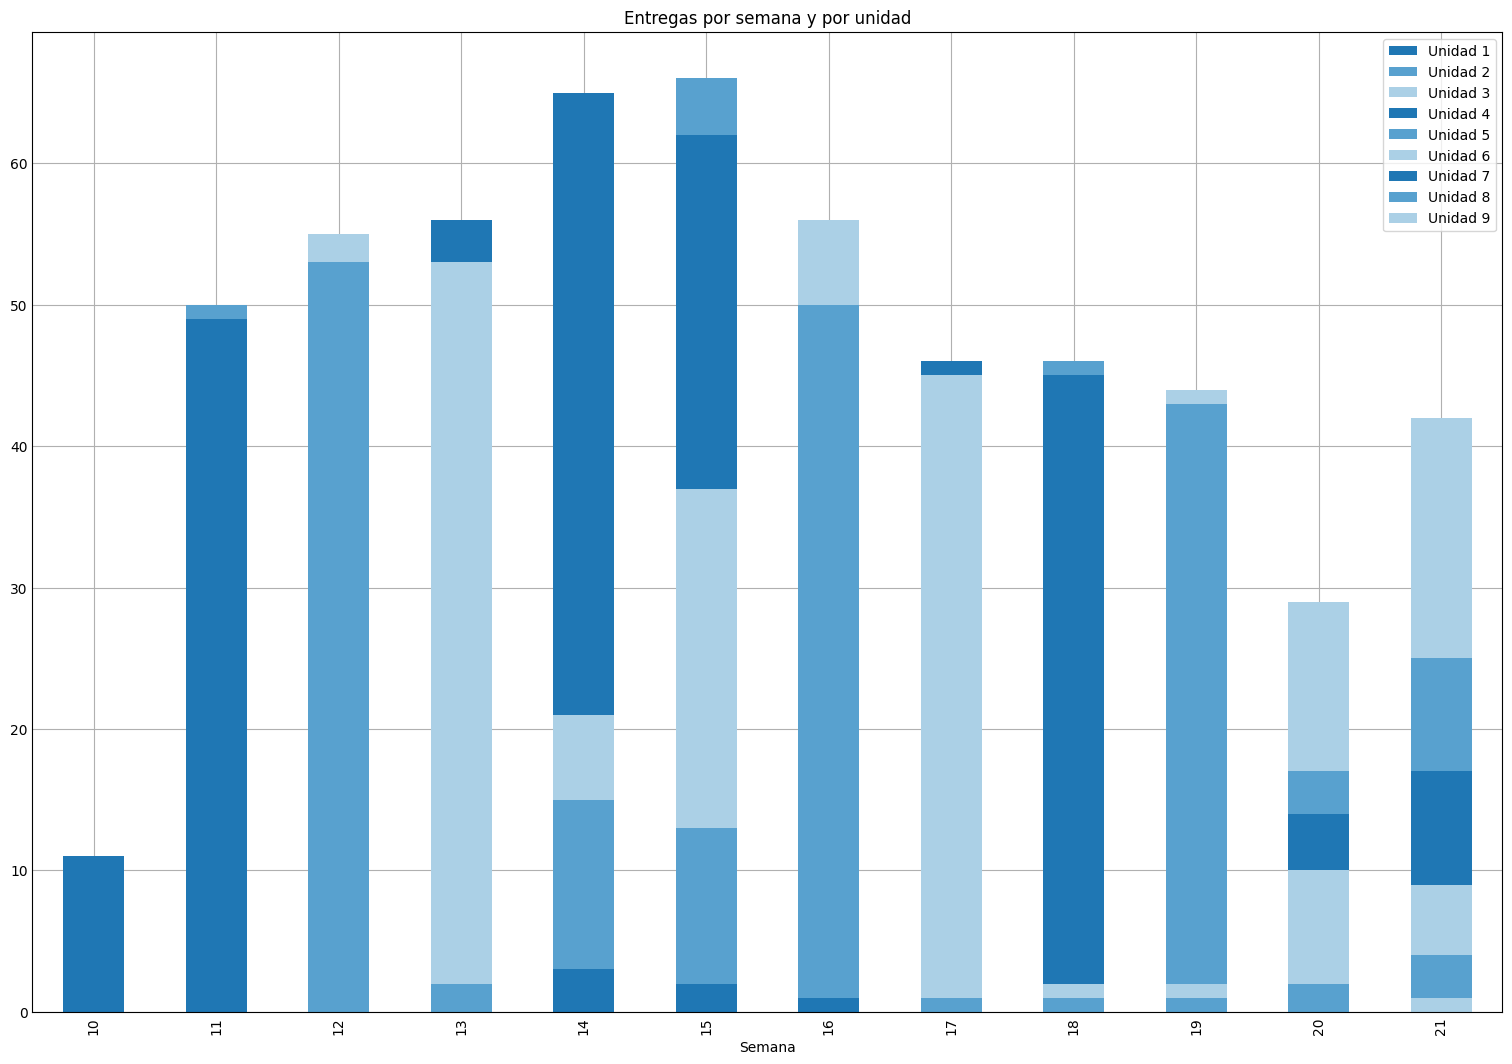

In [38]:
# plot data in stack manner of bar type
df.plot(x='Semana', kind='bar', stacked=True,
        title='Entregas por semana y por unidad', figsize=(15, 10))

Hagamos lo mismo para los alumnos desaprobados

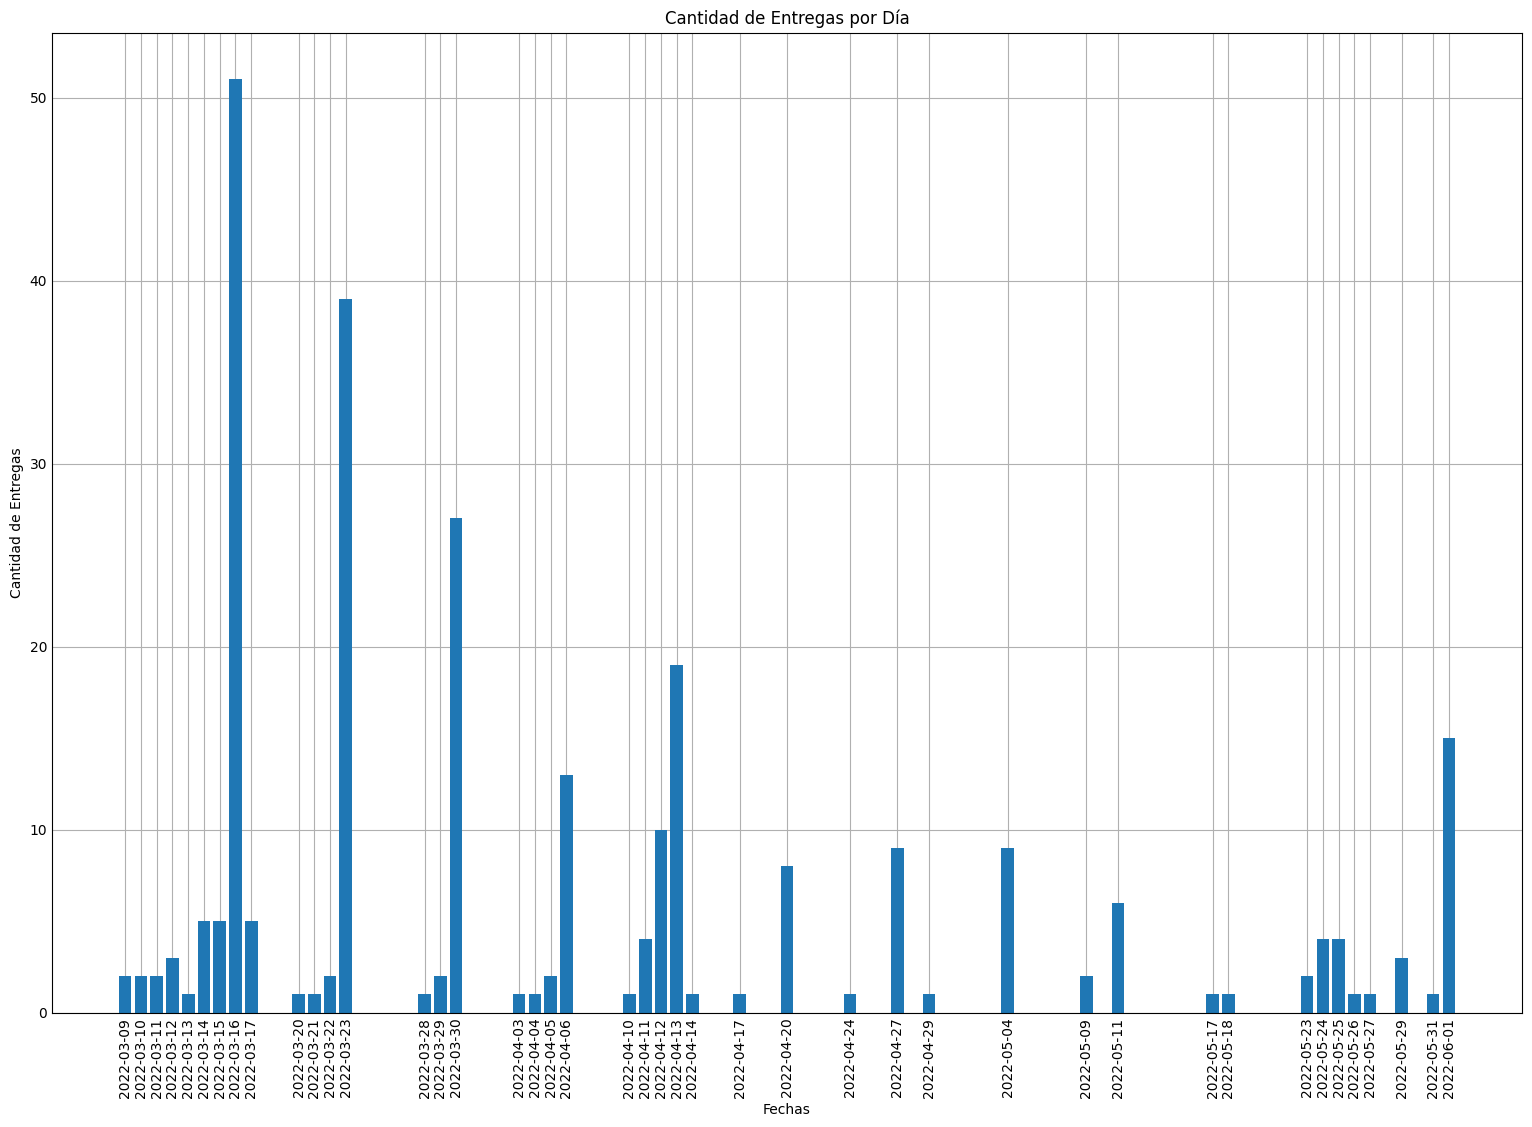

In [39]:
entregas_desaprobados = UnitSubmission.objects.filter(student_record__in=alumnos_desaprobados)

plot_entregas_por_dia(entregas=entregas_desaprobados)


In [40]:
entregas_por_semana_unidad_1 = entregas_por_semana_as_dict(entregas_1)
entregas_por_semana_unidad_2 = entregas_por_semana_as_dict(entregas_2)
entregas_por_semana_unidad_3 = entregas_por_semana_as_dict(entregas_3)
entregas_por_semana_unidad_4 = entregas_por_semana_as_dict(entregas_4)
entregas_por_semana_unidad_5 = entregas_por_semana_as_dict(entregas_5)
entregas_por_semana_unidad_6 = entregas_por_semana_as_dict(entregas_6)
entregas_por_semana_unidad_7 = entregas_por_semana_as_dict(entregas_7)
entregas_por_semana_unidad_8 = entregas_por_semana_as_dict(entregas_8)
entregas_por_semana_unidad_9 = entregas_por_semana_as_dict(entregas_9)

entregas_por_semana_unidad_1 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_1, todas_las_semanas)
entregas_por_semana_unidad_2 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_2, todas_las_semanas)
entregas_por_semana_unidad_3 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_3, todas_las_semanas)
entregas_por_semana_unidad_4 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_4, todas_las_semanas)
entregas_por_semana_unidad_5 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_5, todas_las_semanas)
entregas_por_semana_unidad_6 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_6, todas_las_semanas)
entregas_por_semana_unidad_7 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_7, todas_las_semanas)
entregas_por_semana_unidad_8 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_8, todas_las_semanas)
entregas_por_semana_unidad_9 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_9, todas_las_semanas)

In [41]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_semanas, entregas_por_semana_unidad_1.values(), entregas_por_semana_unidad_2.values(), 
                  entregas_por_semana_unidad_3.values(), entregas_por_semana_unidad_4.values(), 
                  entregas_por_semana_unidad_5.values(), entregas_por_semana_unidad_6.values(), 
                  entregas_por_semana_unidad_7.values(), entregas_por_semana_unidad_8.values(),
                  entregas_por_semana_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Semana', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Semana,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,10,11,0,0,0,0,0,0,0,0
1,11,49,1,0,0,0,0,0,0,0
2,12,0,53,2,0,0,0,0,0,0
3,13,0,2,51,3,0,0,0,0,0
4,14,3,12,6,44,0,0,0,0,0
5,15,2,11,24,25,4,0,0,0,0
6,16,0,0,0,1,49,6,0,0,0
7,17,0,0,0,0,1,44,1,0,0
8,18,0,0,0,0,1,1,43,1,0
9,19,0,0,0,0,1,1,0,41,1


<AxesSubplot: title={'center': 'Entregas por semana y por unidad'}, xlabel='Semana'>

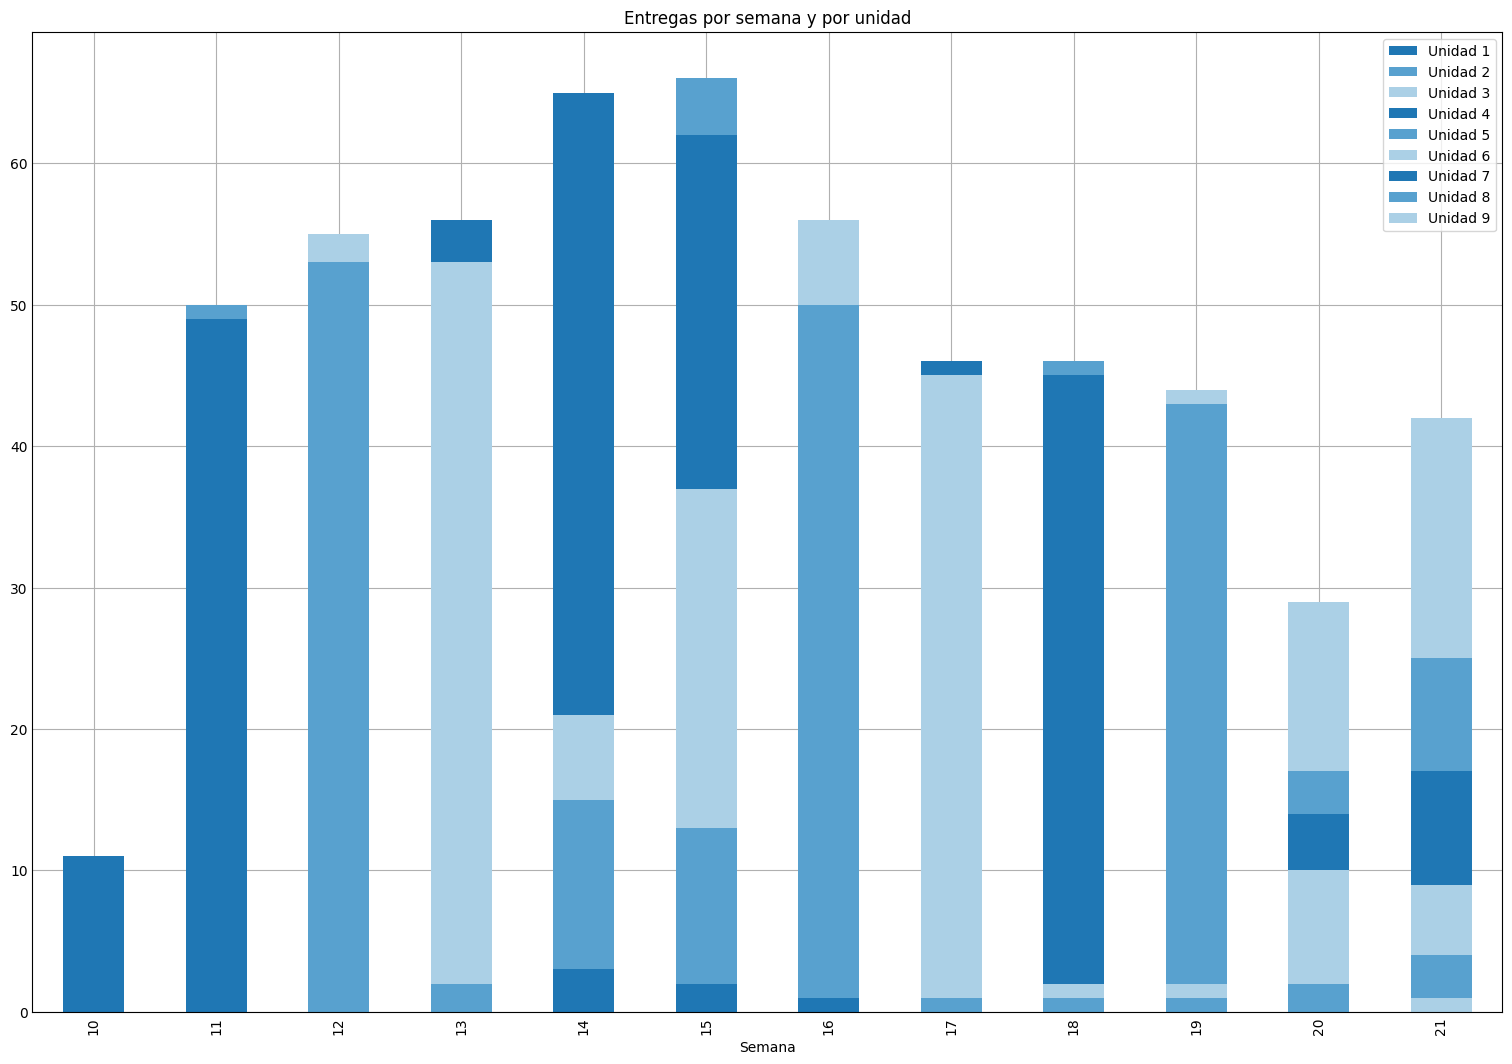

In [42]:
# plot data in stack manner of bar type
df.plot(x='Semana', kind='bar', stacked=True,
        title='Entregas por semana y por unidad', figsize=(15, 10))

## Reentregas

Hagamos el mismo análisis pero no tomemos todas las entregas. Tomemos solamente la última entrega de cada unidad, para interpretar "hasta este momento estuve con la unidad".

In [43]:
def entregas_a_partir_de(entregas_por_persona_y_unidad):
    entregas = []
    
    for estudiante, entregas_por_unidad in entregas_por_persona_y_unidad.items(): 
        for unidad, entrega in entregas_por_unidad.items():
            entregas.append(entrega)
            
    return UnitSubmission.objects.filter(id__in=[entrega.id for entrega in entregas])

In [44]:
todas_las_entregas = UnitSubmission.objects.all()

ultimas_entregas_por_persona_y_unidad = {}

for entrega in todas_las_entregas: 
    if entrega.student_record_id in ultimas_entregas_por_persona_y_unidad.keys():
        if entrega.unit in ultimas_entregas_por_persona_y_unidad[entrega.student_record_id].keys():
            if ultimas_entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit].datetime < entrega.datetime:
                ultimas_entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit] = entrega
        else:
            ultimas_entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit] = entrega
    else:
        ultimas_entregas_por_persona_y_unidad[entrega.student_record_id] = {entrega.unit: entrega}

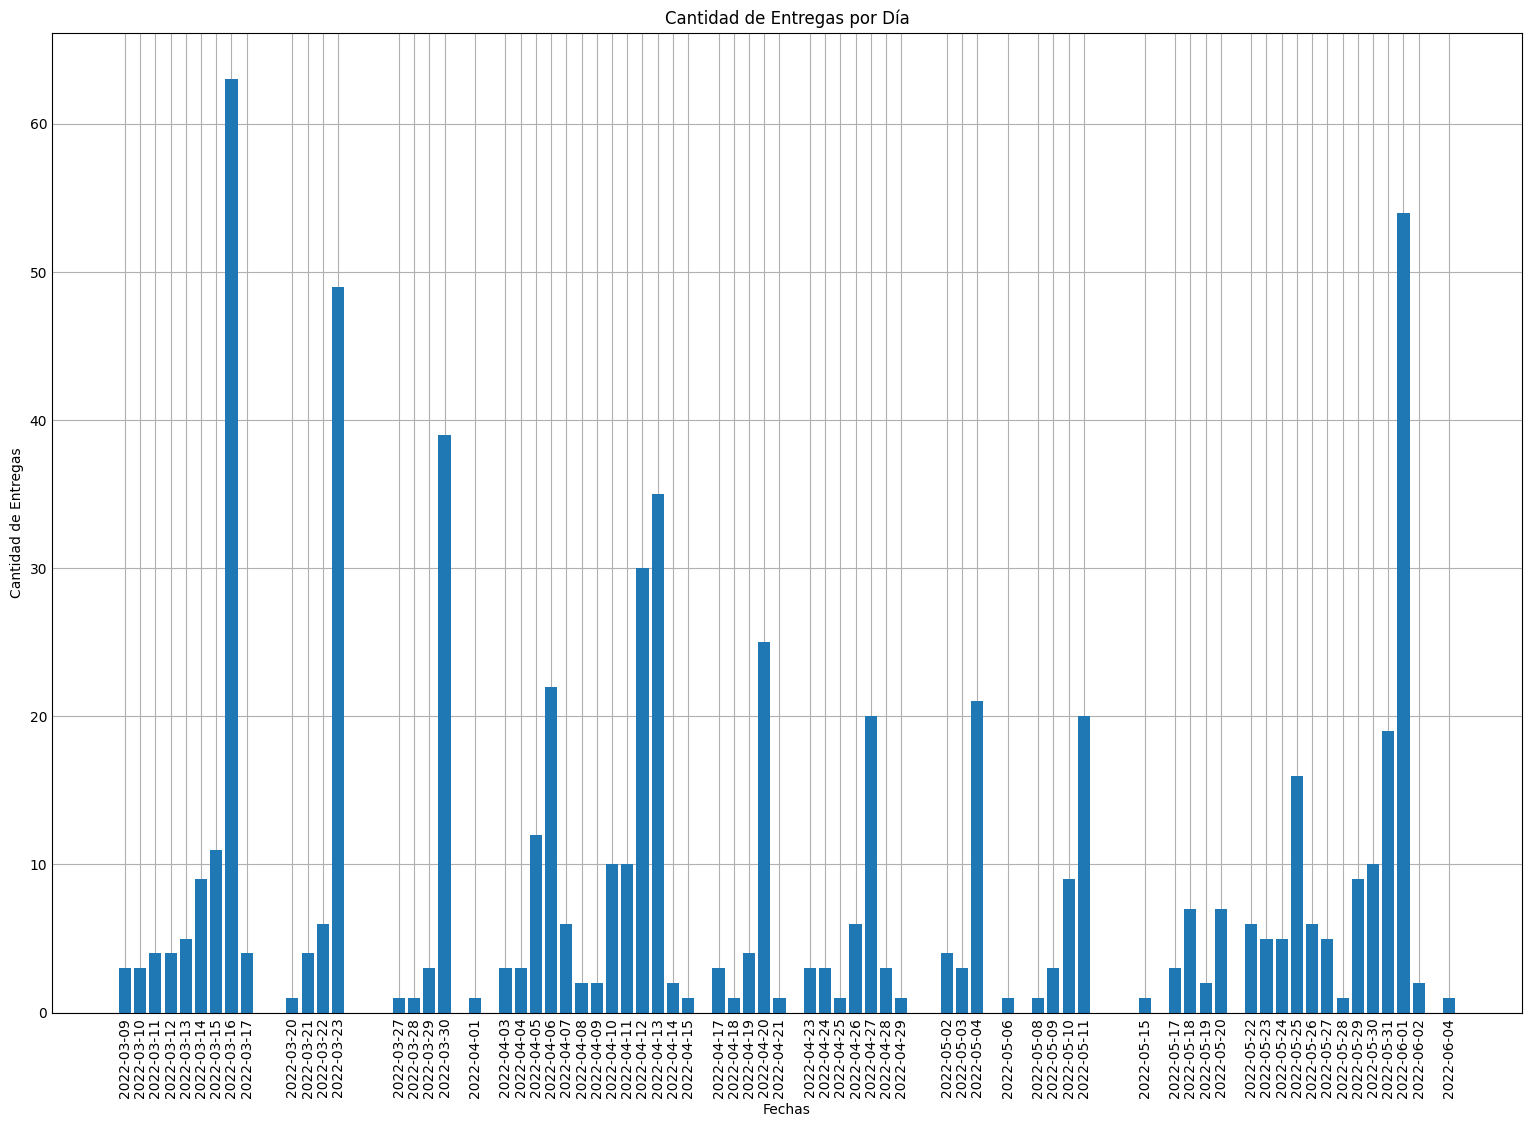

In [45]:
ultimas_entregas = entregas_a_partir_de(ultimas_entregas_por_persona_y_unidad)
plot_entregas_por_dia(entregas=ultimas_entregas)


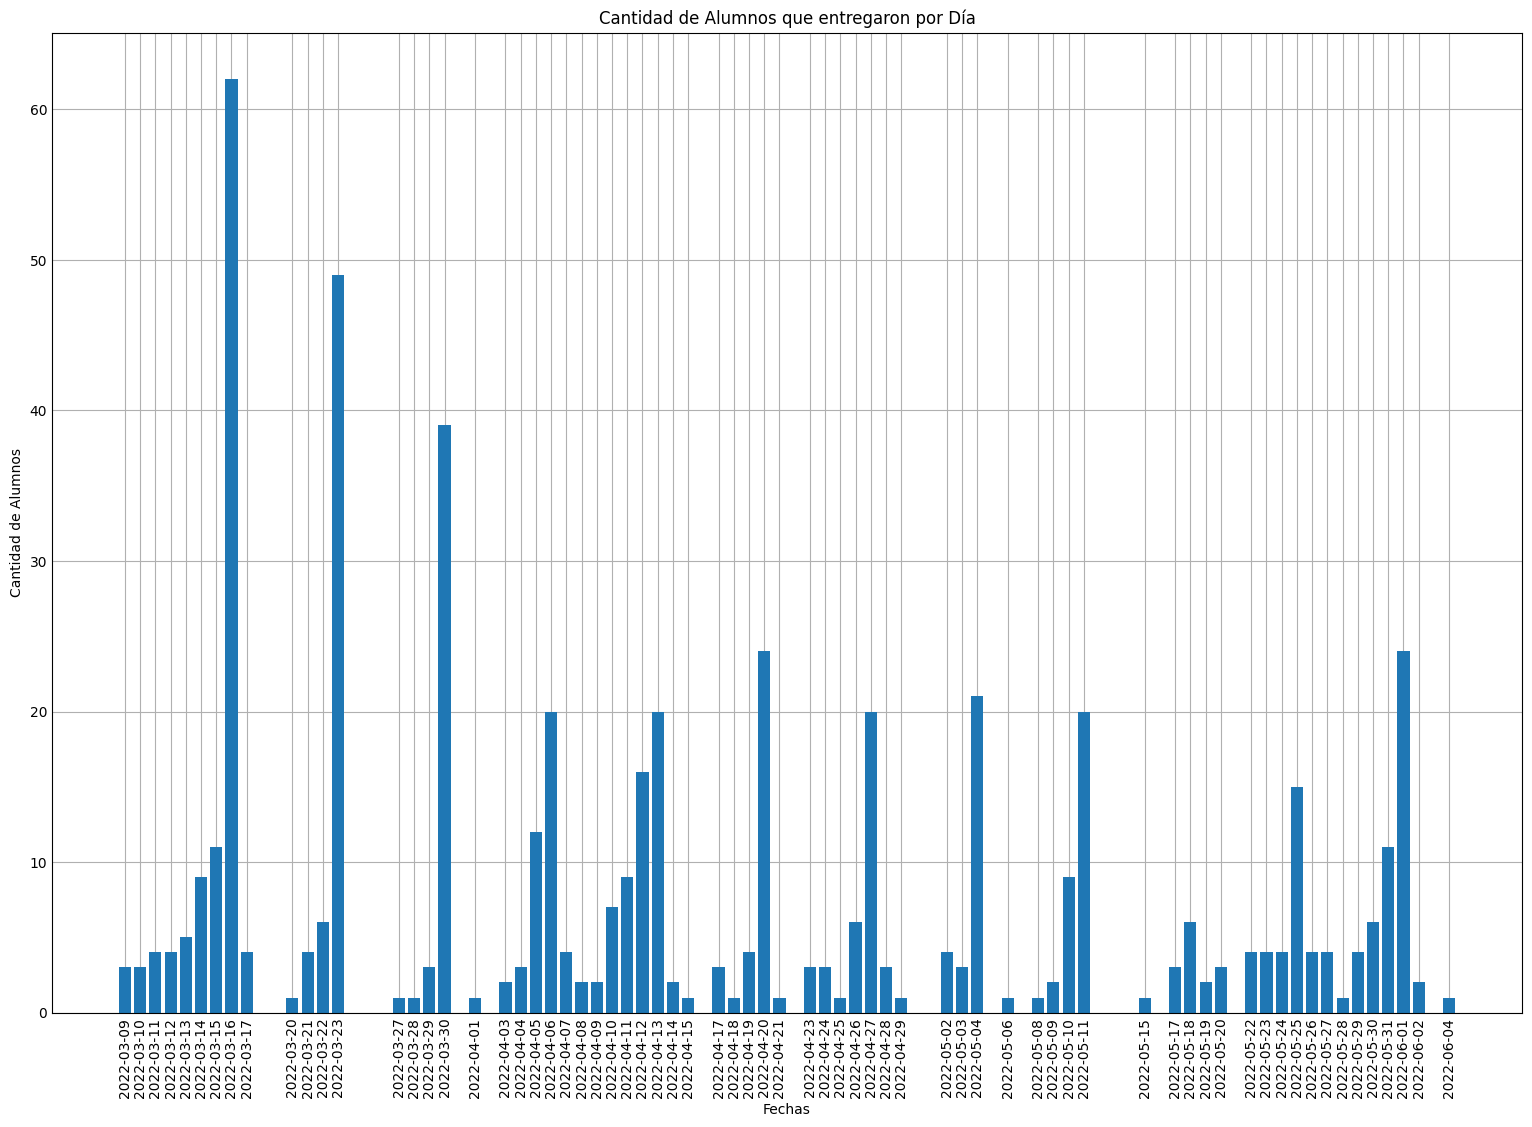

In [46]:
plot_cantidad_de_alumnos_que_entregan_por_dia(entregas=ultimas_entregas)


In [47]:
# Revisar como sacar código repetido

entregas_1 = ultimas_entregas.filter(unit=1)
entregas_2 = ultimas_entregas.filter(unit=2)
entregas_3 = ultimas_entregas.filter(unit=3)
entregas_4 = ultimas_entregas.filter(unit=4)
entregas_5 = ultimas_entregas.filter(unit=5)
entregas_6 = ultimas_entregas.filter(unit=6)
entregas_7 = ultimas_entregas.filter(unit=7)
entregas_8 = ultimas_entregas.filter(unit=8)
entregas_9 = ultimas_entregas.filter(unit=9)

entregas_por_fecha_unidad_1 = entregas_por_fecha_as_dict(entregas_1)
entregas_por_fecha_unidad_2 = entregas_por_fecha_as_dict(entregas_2)
entregas_por_fecha_unidad_3 = entregas_por_fecha_as_dict(entregas_3)
entregas_por_fecha_unidad_4 = entregas_por_fecha_as_dict(entregas_4)
entregas_por_fecha_unidad_5 = entregas_por_fecha_as_dict(entregas_5)
entregas_por_fecha_unidad_6 = entregas_por_fecha_as_dict(entregas_6)
entregas_por_fecha_unidad_7 = entregas_por_fecha_as_dict(entregas_7)
entregas_por_fecha_unidad_8 = entregas_por_fecha_as_dict(entregas_8)
entregas_por_fecha_unidad_9 = entregas_por_fecha_as_dict(entregas_9)

entregas_por_fecha_unidad_1 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_1, todas_las_fechas)
entregas_por_fecha_unidad_2 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_2, todas_las_fechas)
entregas_por_fecha_unidad_3 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_3, todas_las_fechas)
entregas_por_fecha_unidad_4 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_4, todas_las_fechas)
entregas_por_fecha_unidad_5 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_5, todas_las_fechas)
entregas_por_fecha_unidad_6 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_6, todas_las_fechas)
entregas_por_fecha_unidad_7 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_7, todas_las_fechas)
entregas_por_fecha_unidad_8 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_8, todas_las_fechas)
entregas_por_fecha_unidad_9 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_9, todas_las_fechas)


In [48]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_fechas, entregas_por_fecha_unidad_1.values(), entregas_por_fecha_unidad_2.values(), 
                  entregas_por_fecha_unidad_3.values(), entregas_por_fecha_unidad_4.values(), 
                  entregas_por_fecha_unidad_5.values(), entregas_por_fecha_unidad_6.values(), 
                  entregas_por_fecha_unidad_7.values(), entregas_por_fecha_unidad_8.values(),
                  entregas_por_fecha_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Fecha', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Fecha,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,2022-03-09,3,0,0,0,0,0,0,0,0
1,2022-03-10,3,0,0,0,0,0,0,0,0
2,2022-03-11,4,0,0,0,0,0,0,0,0
3,2022-03-12,4,0,0,0,0,0,0,0,0
4,2022-03-13,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
82,2022-05-30,0,0,0,0,2,2,1,3,2
83,2022-05-31,0,0,0,0,3,3,3,3,7
84,2022-06-01,0,1,3,2,7,8,10,10,13
85,2022-06-02,0,0,0,0,0,0,0,0,2


<AxesSubplot: title={'center': 'Stacked Bar Graph by dataframe'}, xlabel='Fecha'>

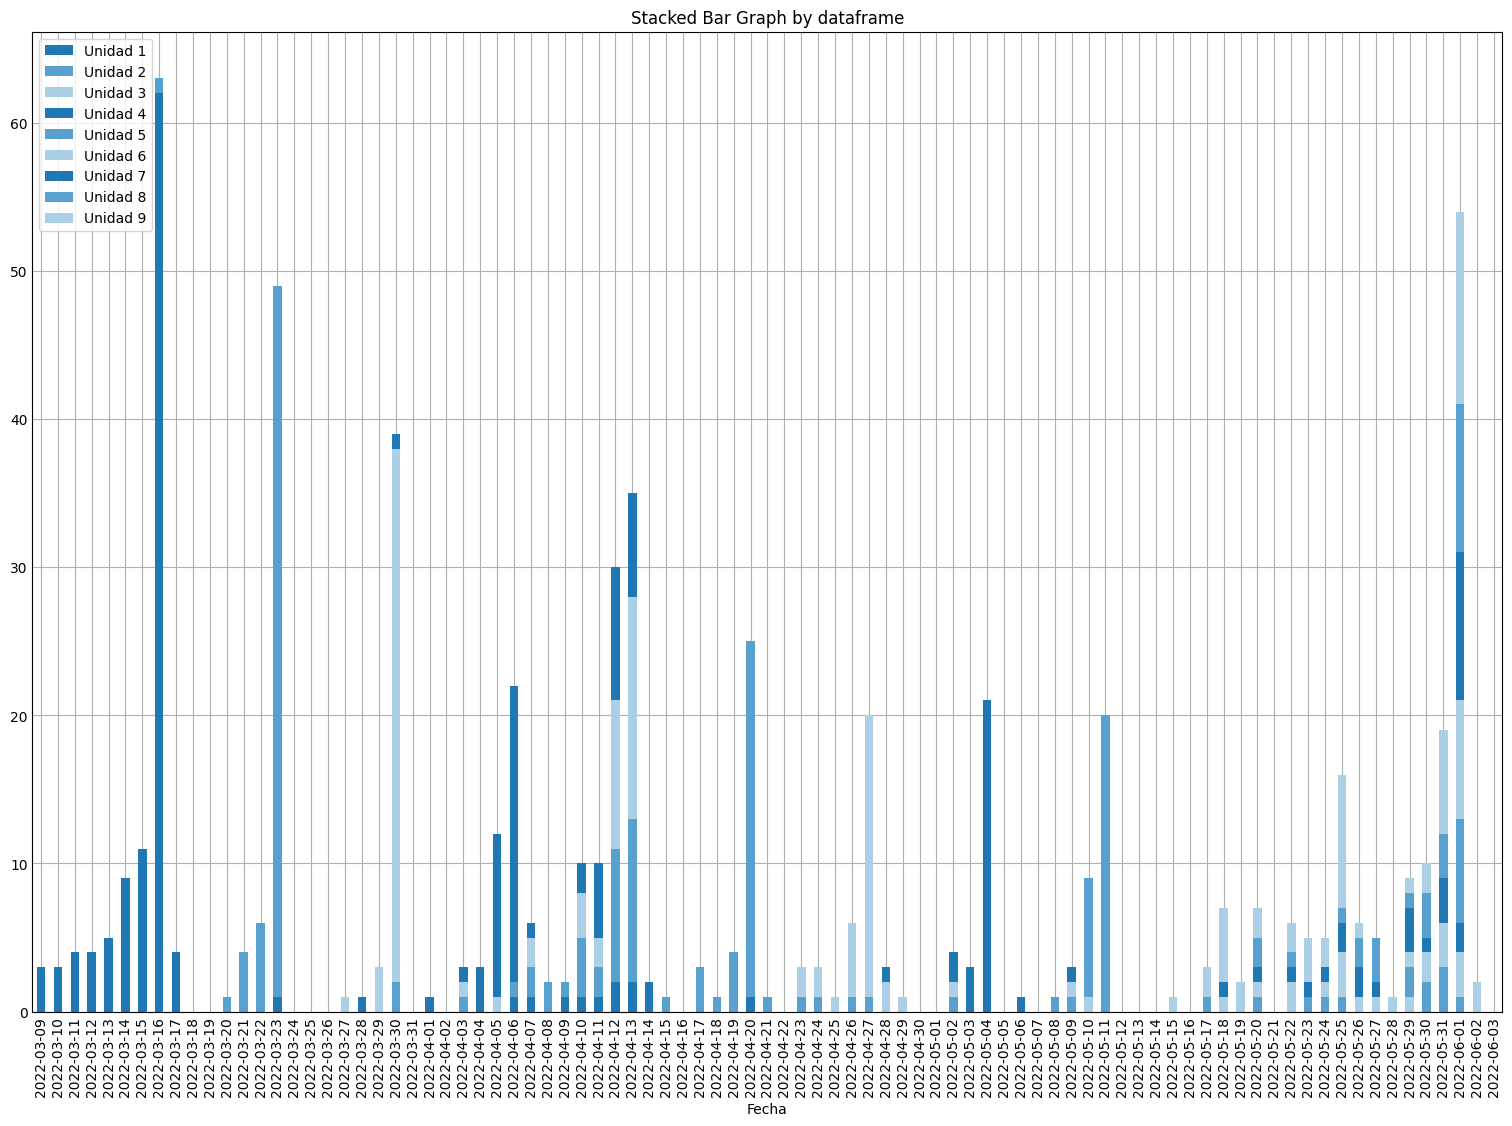

In [49]:
# plot data in stack manner of bar type
df.plot(x='Fecha', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(15, 10))

In [50]:
entregas_por_semana_unidad_1 = entregas_por_semana_as_dict(entregas_1)
entregas_por_semana_unidad_2 = entregas_por_semana_as_dict(entregas_2)
entregas_por_semana_unidad_3 = entregas_por_semana_as_dict(entregas_3)
entregas_por_semana_unidad_4 = entregas_por_semana_as_dict(entregas_4)
entregas_por_semana_unidad_5 = entregas_por_semana_as_dict(entregas_5)
entregas_por_semana_unidad_6 = entregas_por_semana_as_dict(entregas_6)
entregas_por_semana_unidad_7 = entregas_por_semana_as_dict(entregas_7)
entregas_por_semana_unidad_8 = entregas_por_semana_as_dict(entregas_8)
entregas_por_semana_unidad_9 = entregas_por_semana_as_dict(entregas_9)

entregas_por_semana_unidad_1 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_1, todas_las_semanas)
entregas_por_semana_unidad_2 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_2, todas_las_semanas)
entregas_por_semana_unidad_3 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_3, todas_las_semanas)
entregas_por_semana_unidad_4 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_4, todas_las_semanas)
entregas_por_semana_unidad_5 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_5, todas_las_semanas)
entregas_por_semana_unidad_6 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_6, todas_las_semanas)
entregas_por_semana_unidad_7 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_7, todas_las_semanas)
entregas_por_semana_unidad_8 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_8, todas_las_semanas)
entregas_por_semana_unidad_9 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_9, todas_las_semanas)

In [51]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_semanas, entregas_por_semana_unidad_1.values(), entregas_por_semana_unidad_2.values(), 
                  entregas_por_semana_unidad_3.values(), entregas_por_semana_unidad_4.values(), 
                  entregas_por_semana_unidad_5.values(), entregas_por_semana_unidad_6.values(), 
                  entregas_por_semana_unidad_7.values(), entregas_por_semana_unidad_8.values(),
                  entregas_por_semana_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Semana', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Semana,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,10,19,0,0,0,0,0,0,0,0
1,11,86,2,0,0,0,0,0,0,0
2,12,1,58,1,0,0,0,0,0,0
3,13,1,3,40,3,0,0,0,0,0
4,14,4,10,6,37,0,0,0,0,0
5,15,5,22,27,23,4,0,0,0,0
6,16,0,0,0,1,32,4,0,0,0
7,17,0,0,1,0,2,27,1,0,0
8,18,0,0,0,0,1,1,27,1,0
9,19,0,0,0,0,1,2,1,28,1


<AxesSubplot: title={'center': 'Entregas por semana y por unidad'}, xlabel='Semana'>

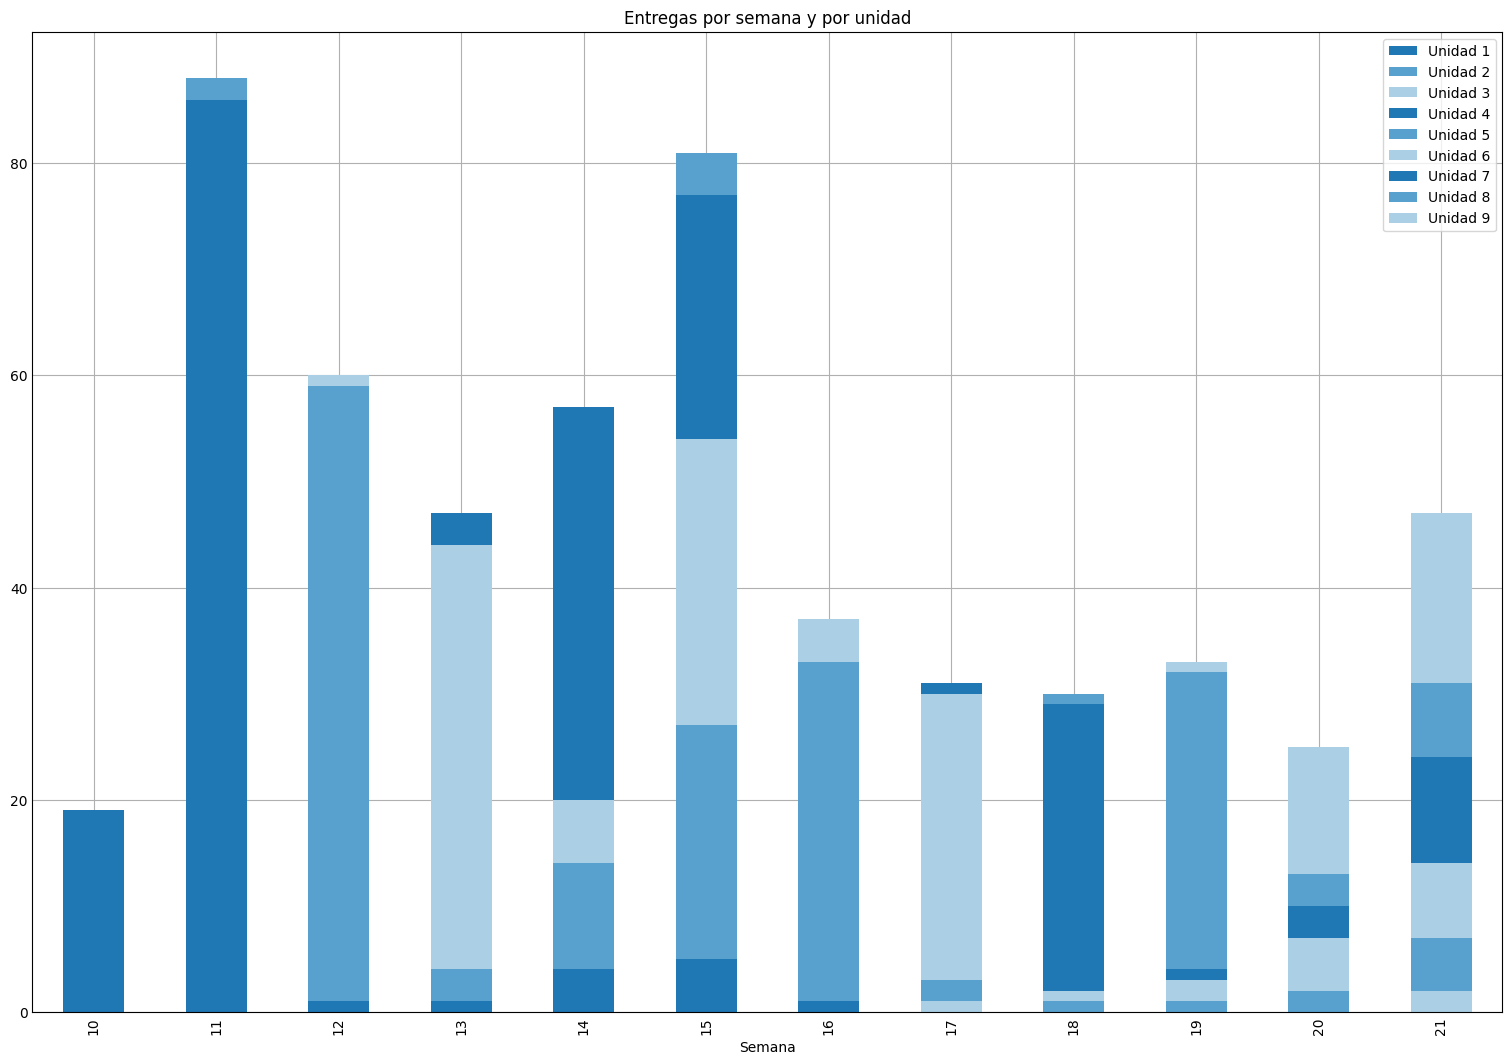

In [52]:
# plot data in stack manner of bar type
df.plot(x='Semana', kind='bar', stacked=True,
        title='Entregas por semana y por unidad', figsize=(15, 10))

Un par de detalles que pudimos observar comparando contra los gráficos de "todas las entregas" es que la cantidad de "ultimas" entregas de las unidades para la primera parte de la materia, caen bastante más rapido. Pareceria que hay más gente entregando varias veces para las primeras unidades que terminan distribuidas a las fechas cercanas al primer parcial. Dejaron de trabajar la unidad 2 y 3 xq ya no llegaron a entregarlas "correctamente" en fecha. 
POR QUE VUELVEN A ENTREGAR?

En la primera unidad, tenes un valor absoluto de 20 de diferencia que tienen que estar distribuidos en dias posteriores. 

La segunda parte de la materia se cae bastante en valores. Por lo menos comparados contra el punto de referencia del primer parcial. Tiene algo de sentido porque el final del cuatrimestre tiene una entrega masica y muy arbitraria de unidades por fecha porque se termina la materia y "hay que entregar lo que falta". 

Vamos a hacer ahora el mismo analisis pero tomando como importante la primera entrega. El significado es: "la primera vez que entrego es porque le estoy poniendo ese nivel de ganas a la materia".

In [53]:
todas_las_entregas = UnitSubmission.objects.all()

primeras_entregas_por_persona_y_unidad = {}

for entrega in todas_las_entregas: 
    if entrega.student_record_id in primeras_entregas_por_persona_y_unidad.keys():
        if entrega.unit in primeras_entregas_por_persona_y_unidad[entrega.student_record_id].keys():
            if primeras_entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit].datetime > entrega.datetime:
                primeras_entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit] = entrega
        else:
            primeras_entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit] = entrega
    else:
        primeras_entregas_por_persona_y_unidad[entrega.student_record_id] = {entrega.unit: entrega}

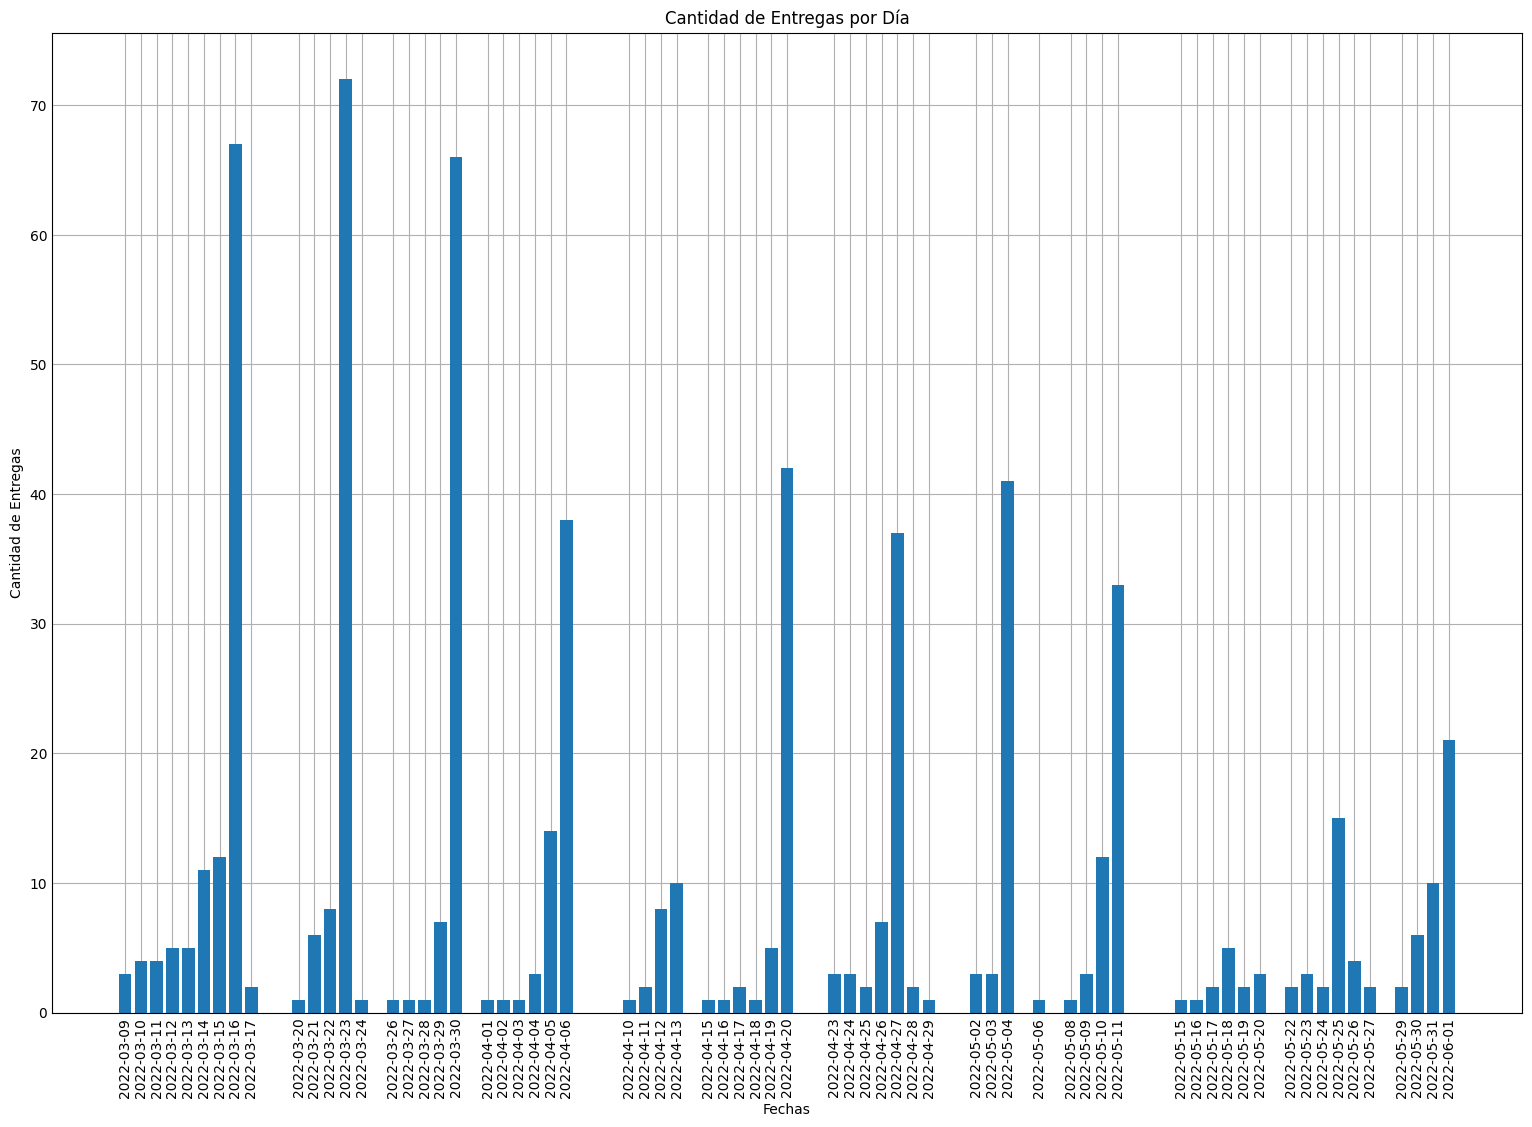

In [54]:
primeras_entregas = entregas_a_partir_de(primeras_entregas_por_persona_y_unidad)
plot_entregas_por_dia(entregas=primeras_entregas)


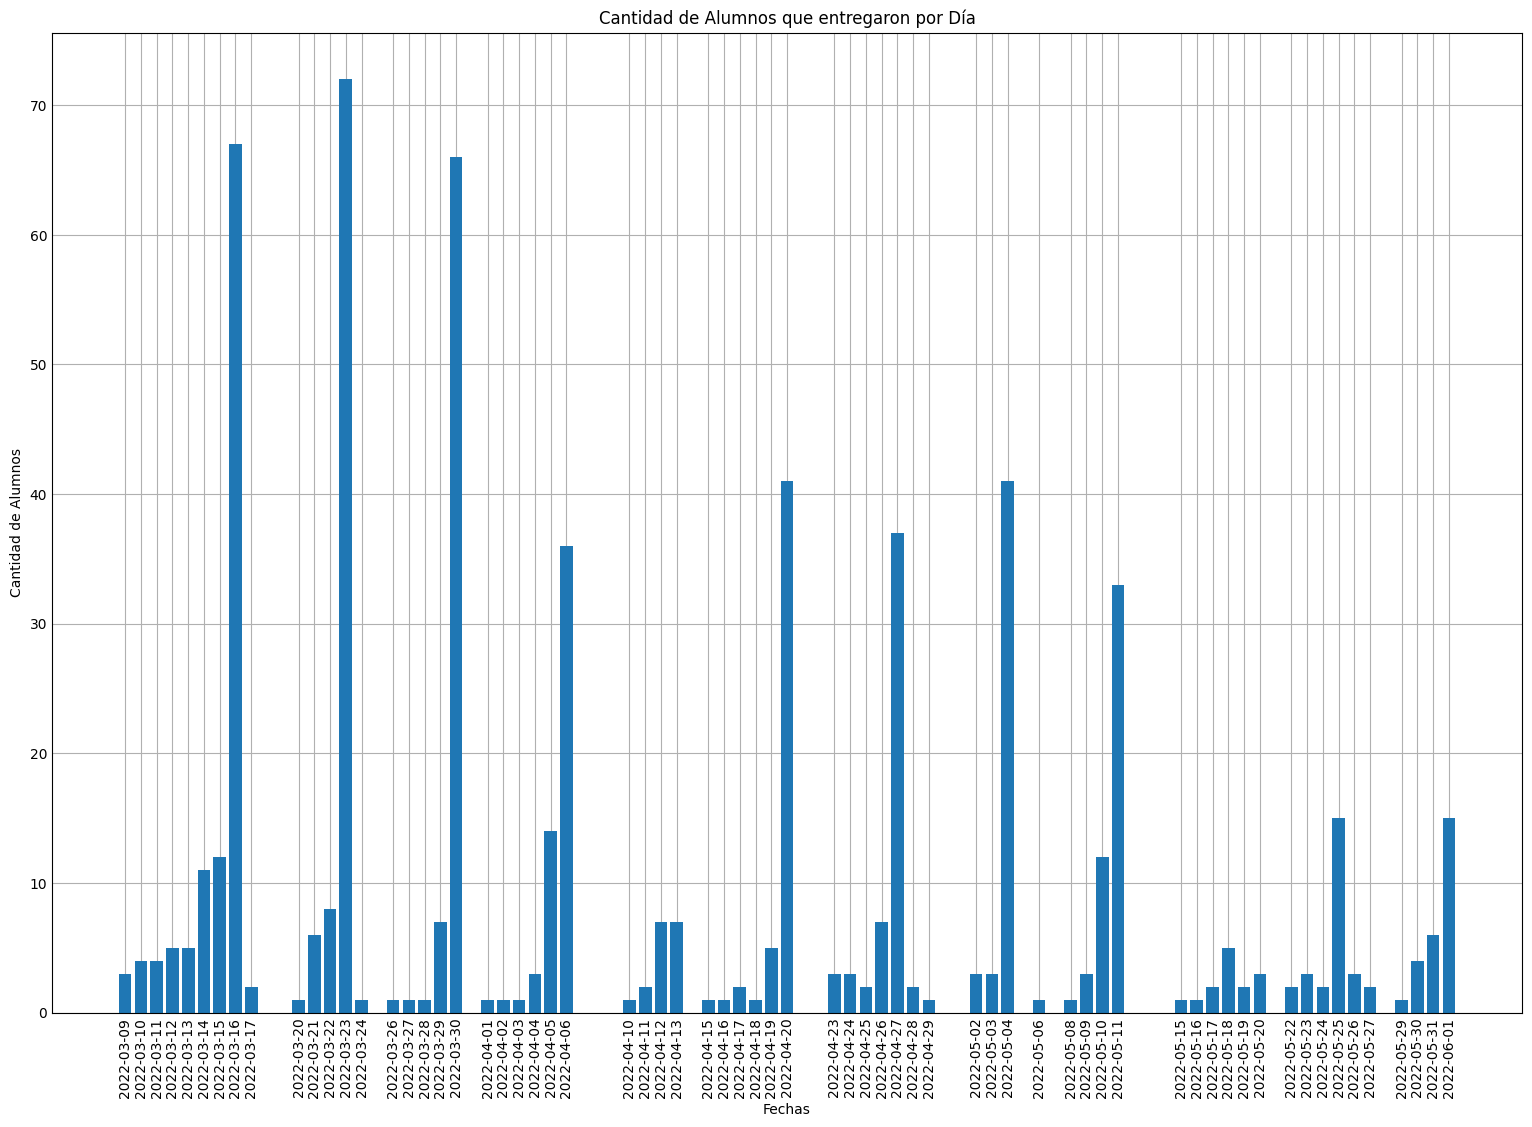

In [55]:
plot_cantidad_de_alumnos_que_entregan_por_dia(entregas=primeras_entregas)


In [56]:
# Revisar como sacar código repetido

entregas_1 = primeras_entregas.filter(unit=1)
entregas_2 = primeras_entregas.filter(unit=2)
entregas_3 = primeras_entregas.filter(unit=3)
entregas_4 = primeras_entregas.filter(unit=4)
entregas_5 = primeras_entregas.filter(unit=5)
entregas_6 = primeras_entregas.filter(unit=6)
entregas_7 = primeras_entregas.filter(unit=7)
entregas_8 = primeras_entregas.filter(unit=8)
entregas_9 = primeras_entregas.filter(unit=9)

entregas_por_fecha_unidad_1 = entregas_por_fecha_as_dict(entregas_1)
entregas_por_fecha_unidad_2 = entregas_por_fecha_as_dict(entregas_2)
entregas_por_fecha_unidad_3 = entregas_por_fecha_as_dict(entregas_3)
entregas_por_fecha_unidad_4 = entregas_por_fecha_as_dict(entregas_4)
entregas_por_fecha_unidad_5 = entregas_por_fecha_as_dict(entregas_5)
entregas_por_fecha_unidad_6 = entregas_por_fecha_as_dict(entregas_6)
entregas_por_fecha_unidad_7 = entregas_por_fecha_as_dict(entregas_7)
entregas_por_fecha_unidad_8 = entregas_por_fecha_as_dict(entregas_8)
entregas_por_fecha_unidad_9 = entregas_por_fecha_as_dict(entregas_9)

entregas_por_fecha_unidad_1 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_1, todas_las_fechas)
entregas_por_fecha_unidad_2 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_2, todas_las_fechas)
entregas_por_fecha_unidad_3 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_3, todas_las_fechas)
entregas_por_fecha_unidad_4 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_4, todas_las_fechas)
entregas_por_fecha_unidad_5 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_5, todas_las_fechas)
entregas_por_fecha_unidad_6 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_6, todas_las_fechas)
entregas_por_fecha_unidad_7 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_7, todas_las_fechas)
entregas_por_fecha_unidad_8 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_8, todas_las_fechas)
entregas_por_fecha_unidad_9 = agregar_valor_nulo_a_fechas_faltantes(entregas_por_fecha_unidad_9, todas_las_fechas)


In [57]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_fechas, entregas_por_fecha_unidad_1.values(), entregas_por_fecha_unidad_2.values(), 
                  entregas_por_fecha_unidad_3.values(), entregas_por_fecha_unidad_4.values(), 
                  entregas_por_fecha_unidad_5.values(), entregas_por_fecha_unidad_6.values(), 
                  entregas_por_fecha_unidad_7.values(), entregas_por_fecha_unidad_8.values(),
                  entregas_por_fecha_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Fecha', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Fecha,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,2022-03-09,3,0,0,0,0,0,0,0,0
1,2022-03-10,4,0,0,0,0,0,0,0,0
2,2022-03-11,4,0,0,0,0,0,0,0,0
3,2022-03-12,5,0,0,0,0,0,0,0,0
4,2022-03-13,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
82,2022-05-30,0,0,0,0,1,0,1,2,2
83,2022-05-31,0,0,0,0,2,0,2,1,5
84,2022-06-01,0,0,0,0,0,3,2,2,14
85,2022-06-02,0,0,0,0,0,0,0,0,0


<AxesSubplot: title={'center': 'Stacked Bar Graph by dataframe'}, xlabel='Fecha'>

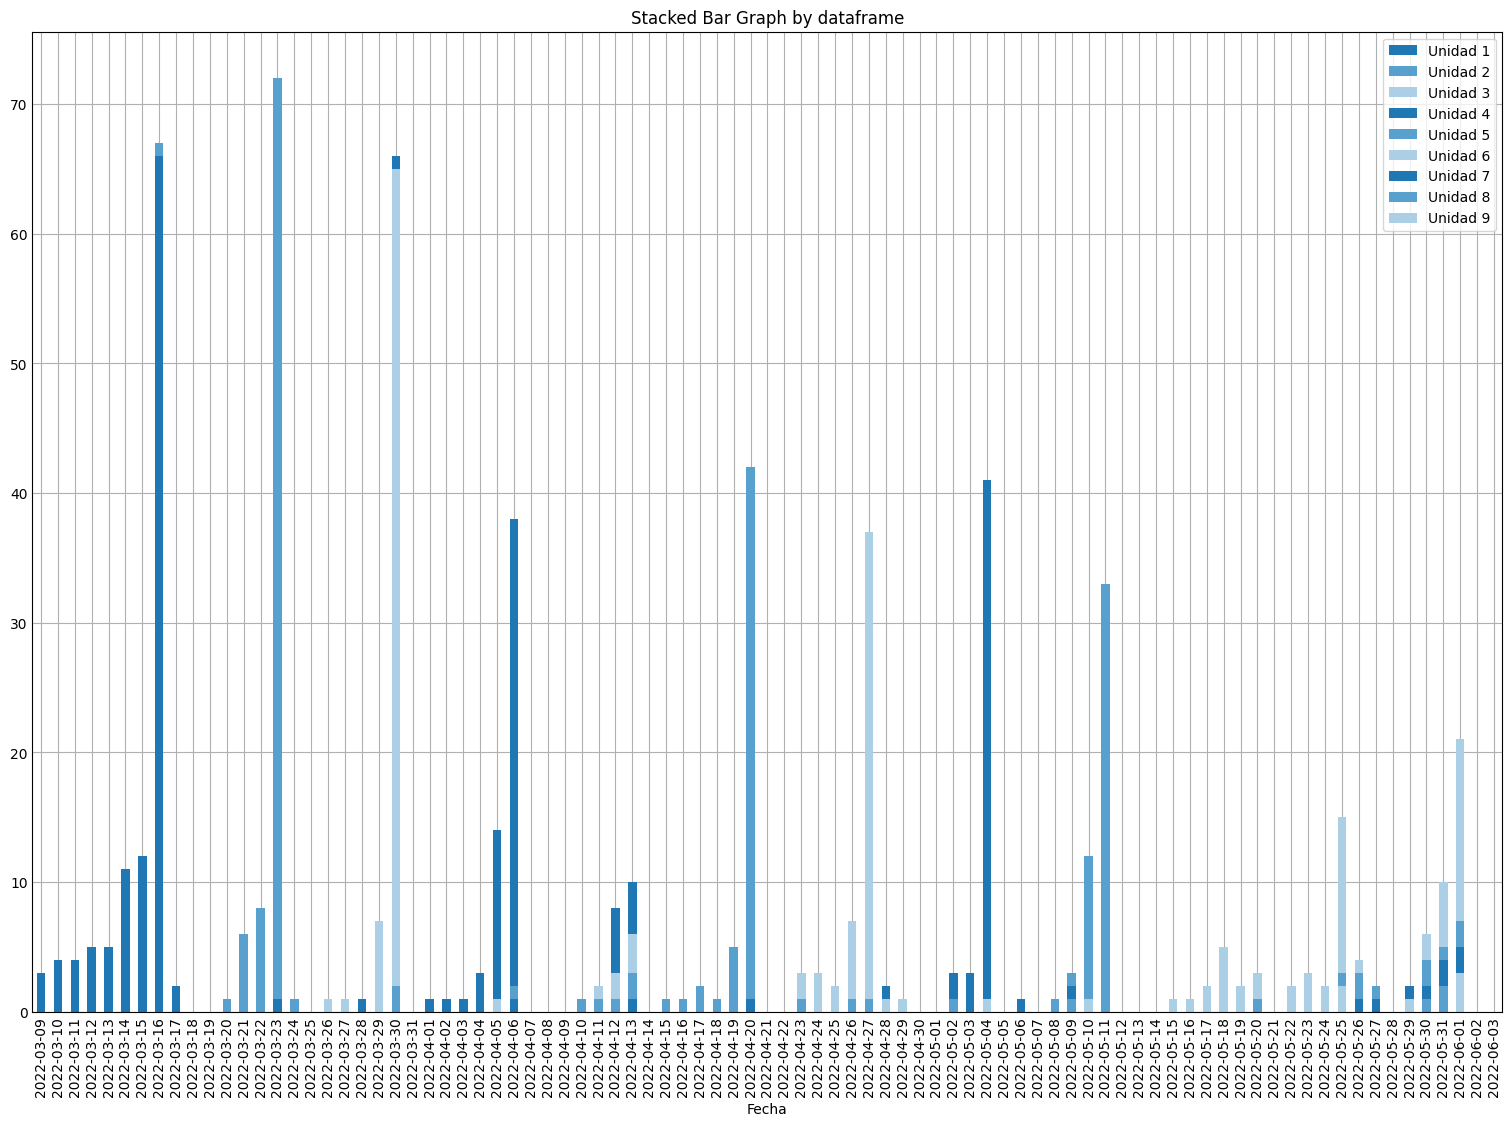

In [58]:
# plot data in stack manner of bar type
df.plot(x='Fecha', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(15, 10))

In [59]:
entregas_por_semana_unidad_1 = entregas_por_semana_as_dict(entregas_1)
entregas_por_semana_unidad_2 = entregas_por_semana_as_dict(entregas_2)
entregas_por_semana_unidad_3 = entregas_por_semana_as_dict(entregas_3)
entregas_por_semana_unidad_4 = entregas_por_semana_as_dict(entregas_4)
entregas_por_semana_unidad_5 = entregas_por_semana_as_dict(entregas_5)
entregas_por_semana_unidad_6 = entregas_por_semana_as_dict(entregas_6)
entregas_por_semana_unidad_7 = entregas_por_semana_as_dict(entregas_7)
entregas_por_semana_unidad_8 = entregas_por_semana_as_dict(entregas_8)
entregas_por_semana_unidad_9 = entregas_por_semana_as_dict(entregas_9)

entregas_por_semana_unidad_1 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_1, todas_las_semanas)
entregas_por_semana_unidad_2 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_2, todas_las_semanas)
entregas_por_semana_unidad_3 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_3, todas_las_semanas)
entregas_por_semana_unidad_4 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_4, todas_las_semanas)
entregas_por_semana_unidad_5 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_5, todas_las_semanas)
entregas_por_semana_unidad_6 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_6, todas_las_semanas)
entregas_por_semana_unidad_7 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_7, todas_las_semanas)
entregas_por_semana_unidad_8 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_8, todas_las_semanas)
entregas_por_semana_unidad_9 = agregar_valor_nulo_a_semanas_faltantes(entregas_por_semana_unidad_9, todas_las_semanas)

In [60]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(todas_las_semanas, entregas_por_semana_unidad_1.values(), entregas_por_semana_unidad_2.values(), 
                  entregas_por_semana_unidad_3.values(), entregas_por_semana_unidad_4.values(), 
                  entregas_por_semana_unidad_5.values(), entregas_por_semana_unidad_6.values(), 
                  entregas_por_semana_unidad_7.values(), entregas_por_semana_unidad_8.values(),
                  entregas_por_semana_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Semana', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Semana,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,10,21,0,0,0,0,0,0,0,0
1,11,91,2,0,0,0,0,0,0,0
2,12,1,86,2,0,0,0,0,0,0
3,13,1,2,70,4,0,0,0,0,0
4,14,1,2,1,52,0,0,0,0,0
5,15,1,4,6,9,4,0,0,0,0
6,16,0,0,0,1,48,5,0,0,0
7,17,0,0,1,0,2,45,1,0,0
8,18,0,0,0,0,1,1,46,1,0
9,19,0,0,0,0,1,1,1,45,1


<AxesSubplot: title={'center': 'Entregas por semana y por unidad'}, xlabel='Semana'>

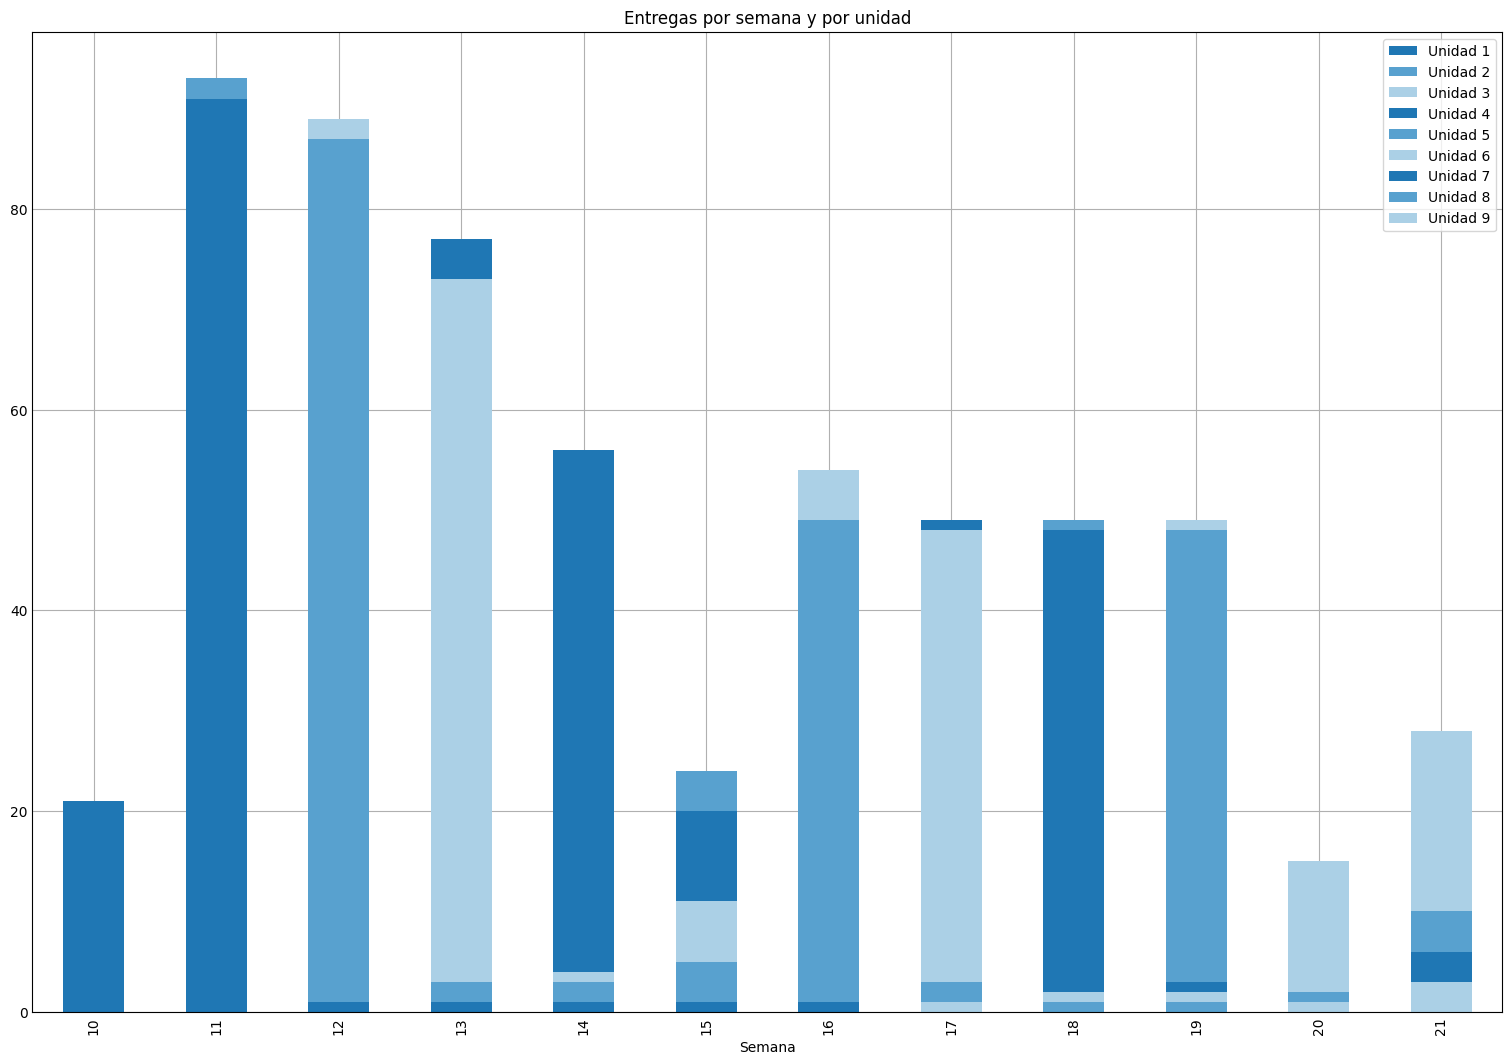

In [61]:
# plot data in stack manner of bar type
df.plot(x='Semana', kind='bar', stacked=True,
        title='Entregas por semana y por unidad', figsize=(15, 10))

Lo primero y más fácil de ver es que si solo contamos las primeras entregas de cada unidad, perdemos el ruido que tenemos al final del cuatrimestre. Ahi el mayor número de entregas son de la última unidad y desaparecen muchas entregas que terminaron siendo reentrega. Tenes algunos casos de primeras entregas de unidades 5, 6, 7, 8 (todo segunda parte de la materia) pero son personas que a priori "terminaron", así no es tan interesante de revisar eso. 

Si vamos al primer semestre, notamos un par de cosas. La primera, que tiene bastante sentido, es que el patrón de las primeras entregas se parece bastante al patrón de cantidad de alumnos. Eso significaría que al principio de la materia reentregan varias veces el mismo día (o tal vez es porque están aprendiendo a usar el sistema). 
Lo segundo interesante, es que se repite lo que pasa en el final del semestre a la altura del primer parcial. Esas semanas son semanas donde la gente se pone al día y la mayoría de las entregas que se dieron ahí, son reentregas y no primeras entregas. Por eso en vez de estar por encima de las 40 entregas, menos de 10 fueron primeras entregas justo después de rendir el primer parcial. 

Vamos a graficar ahora la cantidad de reentregas por estudiante que haya. Luego, trataremos de correlacionarlo con los estudiantes que terminaron la cursada y los que no la terminaron.

In [62]:
### ESTO PUEDE LLEGAR A NECESITAR SUBIRSE Y USARSE EN OTROS LUGARES

todas_las_entregas = UnitSubmission.objects.all()

entregas_por_persona_y_unidad = {}

for entrega in todas_las_entregas: 
    if entrega.student_record_id in entregas_por_persona_y_unidad.keys():
        if entrega.unit in entregas_por_persona_y_unidad[entrega.student_record_id].keys():
            entregas_por_persona_y_unidad[entrega.student_record_id][entrega.unit].append(entrega)
        else:
            entregas_por_persona_y_unidad[entrega.student_record_id].update({entrega.unit: [entrega]})
    else:
        entregas_por_persona_y_unidad[entrega.student_record_id] = {entrega.unit: [entrega]}
        
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>,
   <UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@g

In [63]:
cantidad_de_reentregas_por_persona = {}

for persona, entregas_por_unidad in entregas_por_persona_y_unidad.items():
    cantidad_de_reentregas = 0
    for unidad, entregas in entregas_por_unidad.items():
        if len(entregas) > 1:
            cantidad_de_reentregas += len(entregas) - 1
    cantidad_de_reentregas_por_persona.update({persona: cantidad_de_reentregas})
    
cantidad_de_reentregas_por_persona

{390: 0,
 388: 0,
 387: 1,
 247: 2,
 234: 0,
 268: 0,
 380: 2,
 368: 3,
 340: 5,
 343: 2,
 218: 0,
 283: 7,
 227: 5,
 353: 0,
 339: 5,
 292: 0,
 393: 2,
 355: 5,
 230: 1,
 248: 2,
 287: 0,
 264: 1,
 282: 4,
 296: 6,
 358: 0,
 373: 7,
 362: 1,
 370: 2,
 367: 12,
 365: 1,
 338: 0,
 364: 0,
 384: 3,
 402: 5,
 284: 7,
 217: 0,
 377: 2,
 310: 8,
 320: 4,
 240: 2,
 232: 7,
 314: 5,
 351: 6,
 216: 2,
 241: 0,
 398: 0,
 342: 0,
 385: 11,
 303: 0,
 263: 0,
 242: 3,
 289: 5,
 273: 10,
 297: 0,
 252: 0,
 372: 8,
 315: 0,
 379: 8,
 306: 5,
 403: 0,
 392: 4,
 222: 6,
 278: 9,
 245: 0,
 293: 0,
 375: 2,
 374: 6,
 341: 0,
 305: 4,
 266: 0,
 236: 3,
 231: 0,
 331: 0,
 326: 10,
 276: 0,
 381: 4,
 302: 0,
 246: 1,
 311: 3,
 235: 0,
 261: 2,
 258: 0,
 350: 0,
 401: 0,
 274: 6,
 399: 0,
 396: 7,
 277: 0,
 356: 0,
 354: 0,
 400: 0,
 336: 0,
 346: 2,
 223: 0,
 226: 1,
 238: 2,
 249: 0,
 378: 1,
 329: 0,
 288: 5,
 360: 0,
 228: 0,
 357: 4,
 397: 4,
 244: 0,
 323: 0,
 275: 0,
 322: 0,
 253: 2,
 281: 0,
 363: 

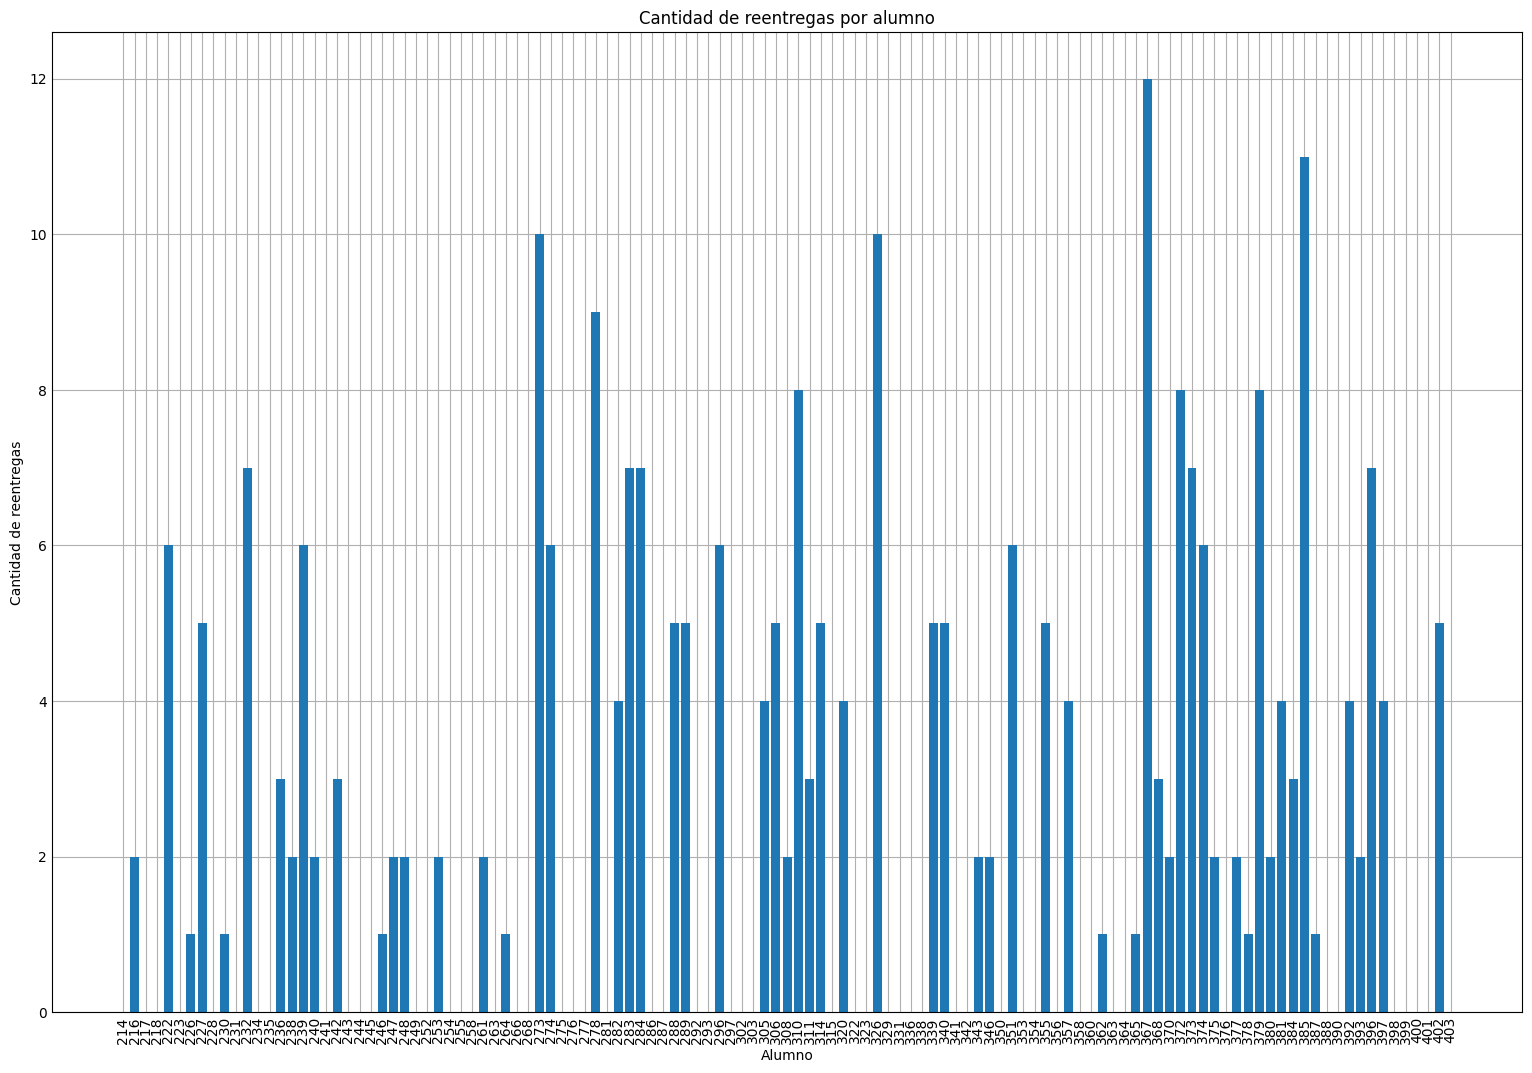

In [64]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(cantidad_de_reentregas_por_persona.items(), key=operator.itemgetter(0))


items_x = [str(alumno) for alumno, cantidad_de_entregas in x_sorted]
items_y = [cantidad_de_entregas for alumno, cantidad_de_entregas in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de reentregas')
ax.set_title('Cantidad de reentregas por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

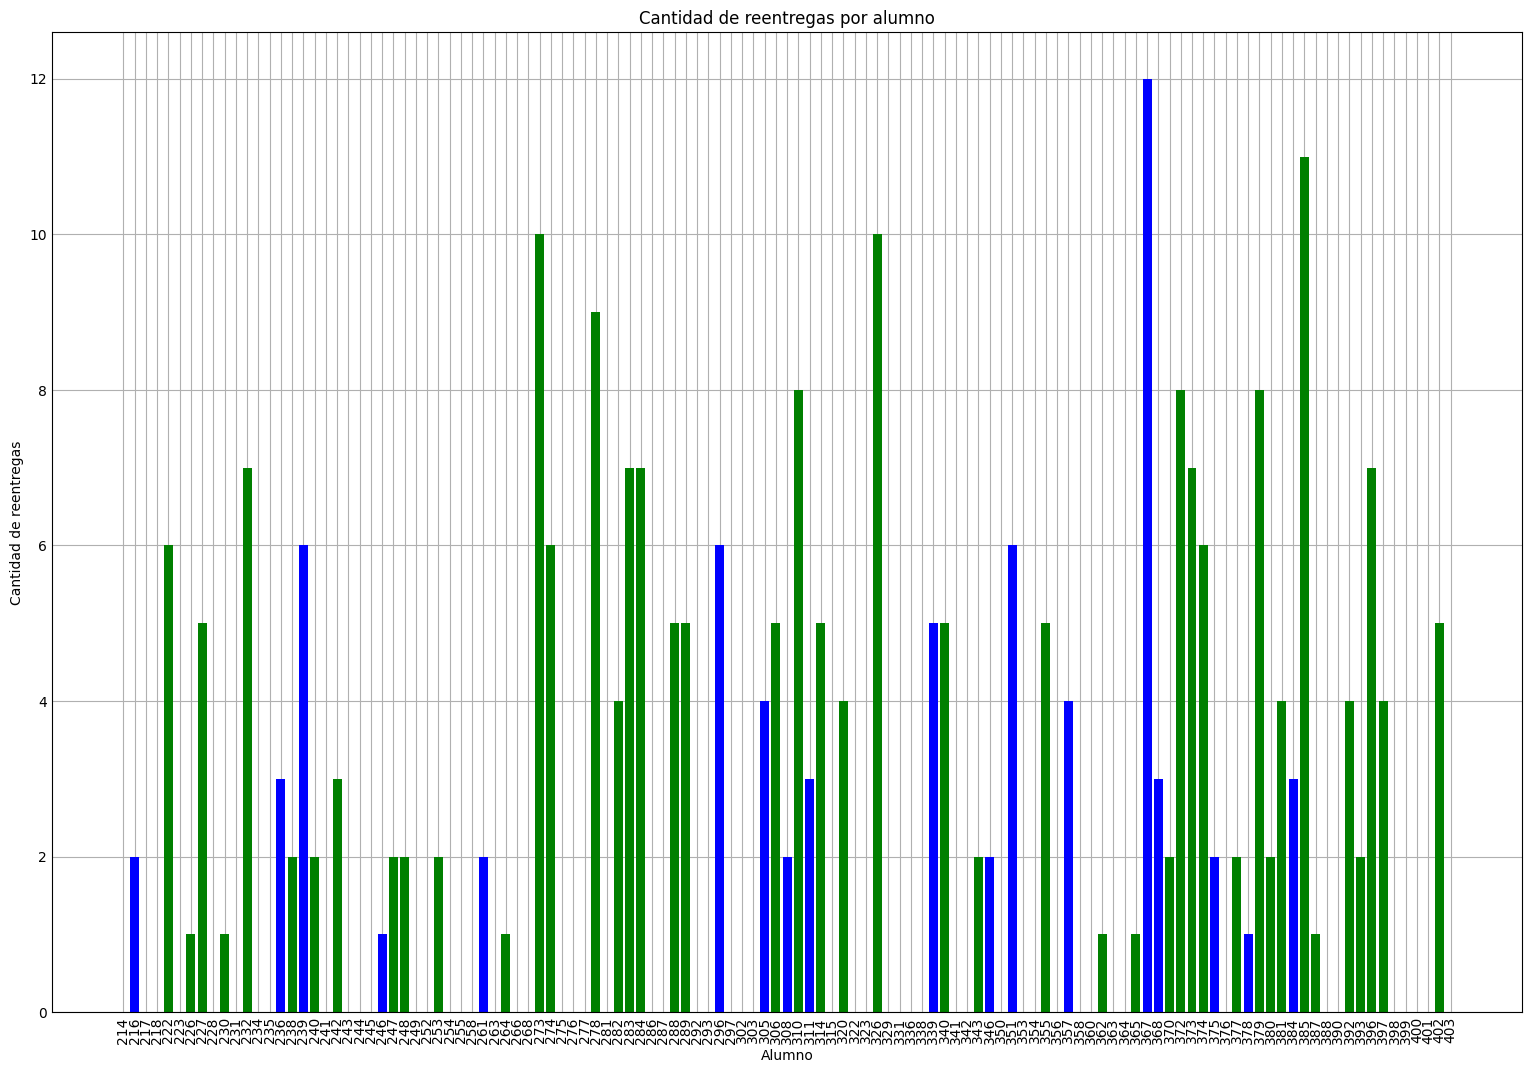

In [65]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES Y ORDENAMIENTO
import operator 
x_sorted = sorted(cantidad_de_reentregas_por_persona.items(), key=operator.itemgetter(0))


items_x = [str(alumno) for alumno, cantidad_de_entregas in x_sorted]
items_y = [cantidad_de_entregas for alumno, cantidad_de_entregas in x_sorted]


colors = []
for estudiante in items_x:
    if int(estudiante) in alumnos_ids_aprobados:
        colors.append('green')
    else:
        colors.append('blue')

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y, color=colors)

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de reentregas')
ax.set_title('Cantidad de reentregas por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Vamos a probar diferenciando por las reentregas por unidad y por alumno. A ver si se pueden encontrar casos de muchas entregas de una unidad particular para un alumno.

In [66]:
#STACKED BAR de reentregas por unidad
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>,
   <UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@g

In [67]:
def cantidad_de_reentregas_por_persona_para(unidad):
    
    cantidad_de_reentregas_de_la_unidad_por_persona = {}

    for persona, entregas_por_unidad in entregas_por_persona_y_unidad.items():
        cantidad_de_reentregas = 0
        entregas_de_la_unidad = entregas_por_unidad.get(unidad, []) 
        
        if len(entregas_de_la_unidad) > 1:
            cantidad_de_reentregas = len(entregas_de_la_unidad) - 1
            cantidad_de_reentregas_de_la_unidad_por_persona.update({persona: cantidad_de_reentregas})
        else:
            cantidad_de_reentregas_de_la_unidad_por_persona.update({persona: 0})

    return cantidad_de_reentregas_de_la_unidad_por_persona

In [68]:
reentregas_por_persona_unidad_1 = cantidad_de_reentregas_por_persona_para(1)
reentregas_por_persona_unidad_2 = cantidad_de_reentregas_por_persona_para(2)
reentregas_por_persona_unidad_3 = cantidad_de_reentregas_por_persona_para(3)
reentregas_por_persona_unidad_4 = cantidad_de_reentregas_por_persona_para(4)
reentregas_por_persona_unidad_5 = cantidad_de_reentregas_por_persona_para(5)
reentregas_por_persona_unidad_6 = cantidad_de_reentregas_por_persona_para(6)
reentregas_por_persona_unidad_7 = cantidad_de_reentregas_por_persona_para(7)
reentregas_por_persona_unidad_8 = cantidad_de_reentregas_por_persona_para(8)
reentregas_por_persona_unidad_9 = cantidad_de_reentregas_por_persona_para(9)


In [69]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(entregas_por_persona_y_unidad.keys(), reentregas_por_persona_unidad_1.values(), 
                  reentregas_por_persona_unidad_2.values(), 
                  reentregas_por_persona_unidad_3.values(), reentregas_por_persona_unidad_4.values(), 
                  reentregas_por_persona_unidad_5.values(), reentregas_por_persona_unidad_6.values(), 
                  reentregas_por_persona_unidad_7.values(), reentregas_por_persona_unidad_8.values(),
                  reentregas_por_persona_unidad_9.values()))

df = pd.DataFrame(zipped, columns=['Alumno', 'Unidad 1', 'Unidad 2', 'Unidad 3', 'Unidad 4', 'Unidad 5',
                                   'Unidad 6', 'Unidad 7','Unidad 8', 'Unidad 9'])
df

,Alumno,Unidad 1,Unidad 2,Unidad 3,Unidad 4,Unidad 5,Unidad 6,Unidad 7,Unidad 8,Unidad 9
0,390,0,0,0,0,0,0,0,0,0
1,388,0,0,0,0,0,0,0,0,0
2,387,0,1,0,0,0,0,0,0,0
3,247,0,0,2,0,0,0,0,0,0
4,234,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
114,243,0,0,0,0,0,0,0,0,0
115,286,0,0,0,0,0,0,0,0,0
116,254,0,0,0,0,0,0,0,0,0
117,239,0,0,0,0,1,1,3,1,0


<AxesSubplot: title={'center': 'Stacked Bar Graph by dataframe'}, xlabel='Alumno'>

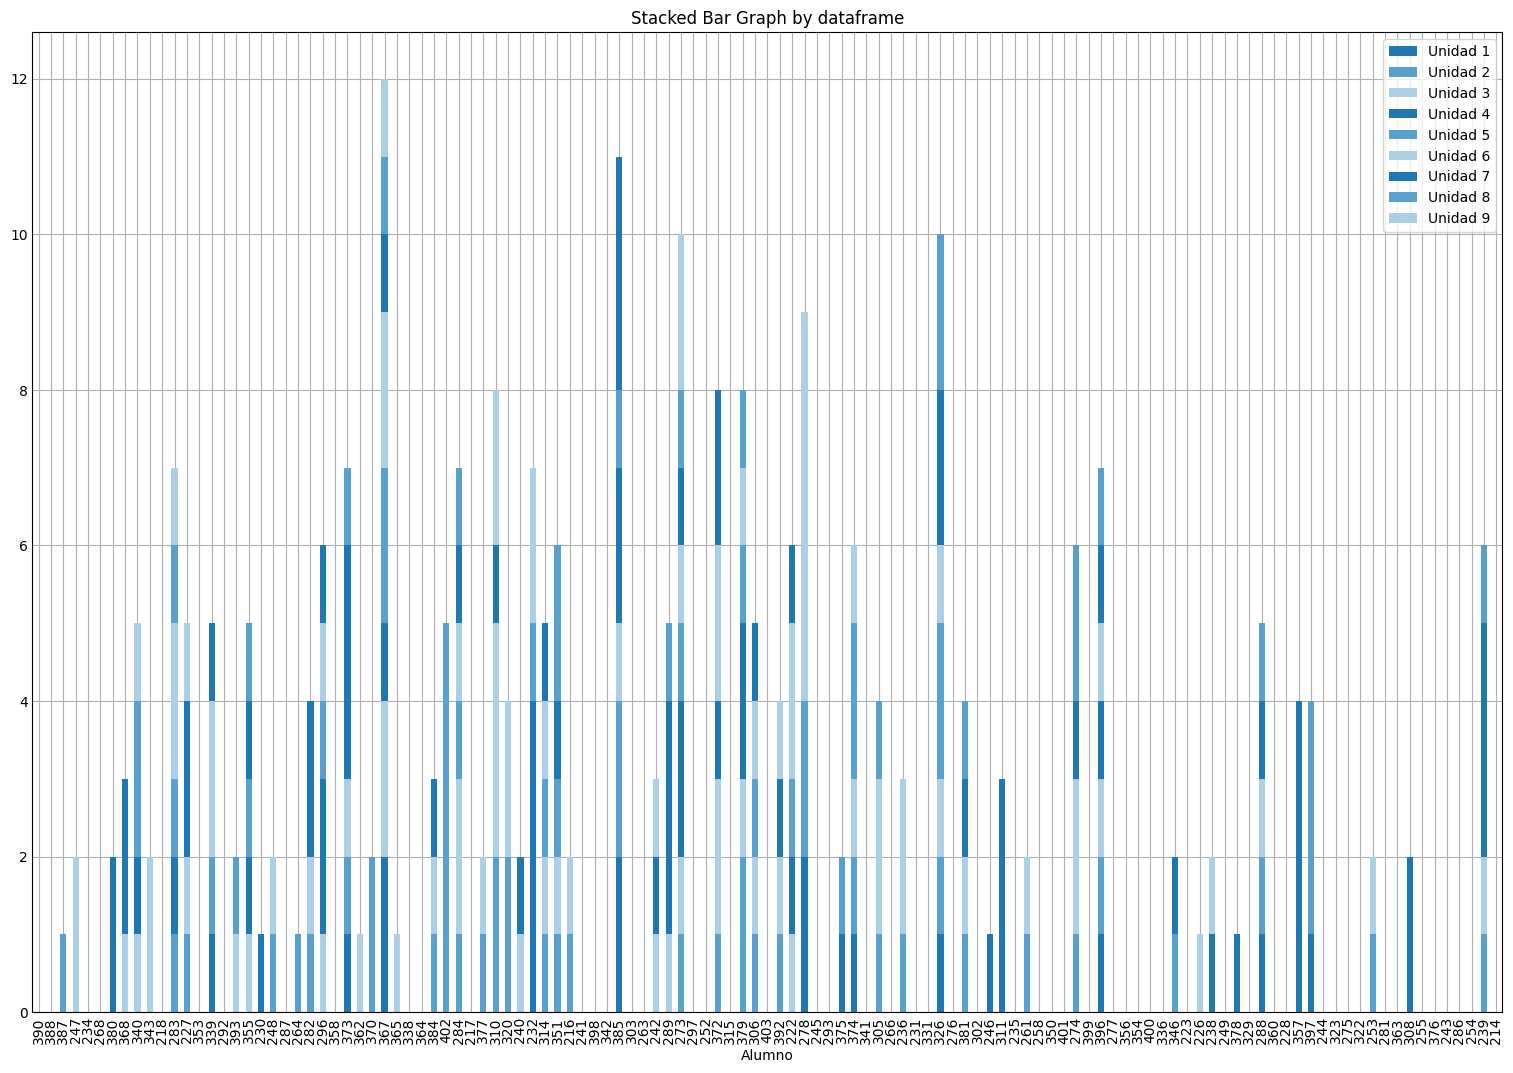

In [70]:
# plot data in stack manner of bar type
df.plot(x='Alumno', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(15, 10))

Caso del alumno 357... Reentrego muchas veces la primera unidad y termino dejando. Alumnos 311, 308 y 246 tambien paso lo mismo. (mas de dos veces) REVISAR

Vamos a revisar la cantidad de reentregas por unidad para ver si hay alguna unidad más difícil que otra y si eso puede llegar a estar atado a abandonar la materia. 

### Profundizar revisando la cantidad de personas que dejaron de entregar por cada una de las unidades

In [71]:
# Bar de reentregas de unidades
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>,
   <UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@g

In [72]:
cantidad_de_reentregas_por_unidad = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for persona, entregas_por_unidad in entregas_por_persona_y_unidad.items():
    for unidad, entregas in entregas_por_unidad.items():
        cantidad_de_reentregas = 0
        if len(entregas) > 1:
            cantidad_de_reentregas = len(entregas) - 1
        cantidad_de_reentregas_por_unidad[unidad] += cantidad_de_reentregas
    
cantidad_de_reentregas_por_unidad

{1: 31, 2: 40, 3: 49, 4: 32, 5: 28, 6: 32, 7: 27, 8: 23, 9: 11}

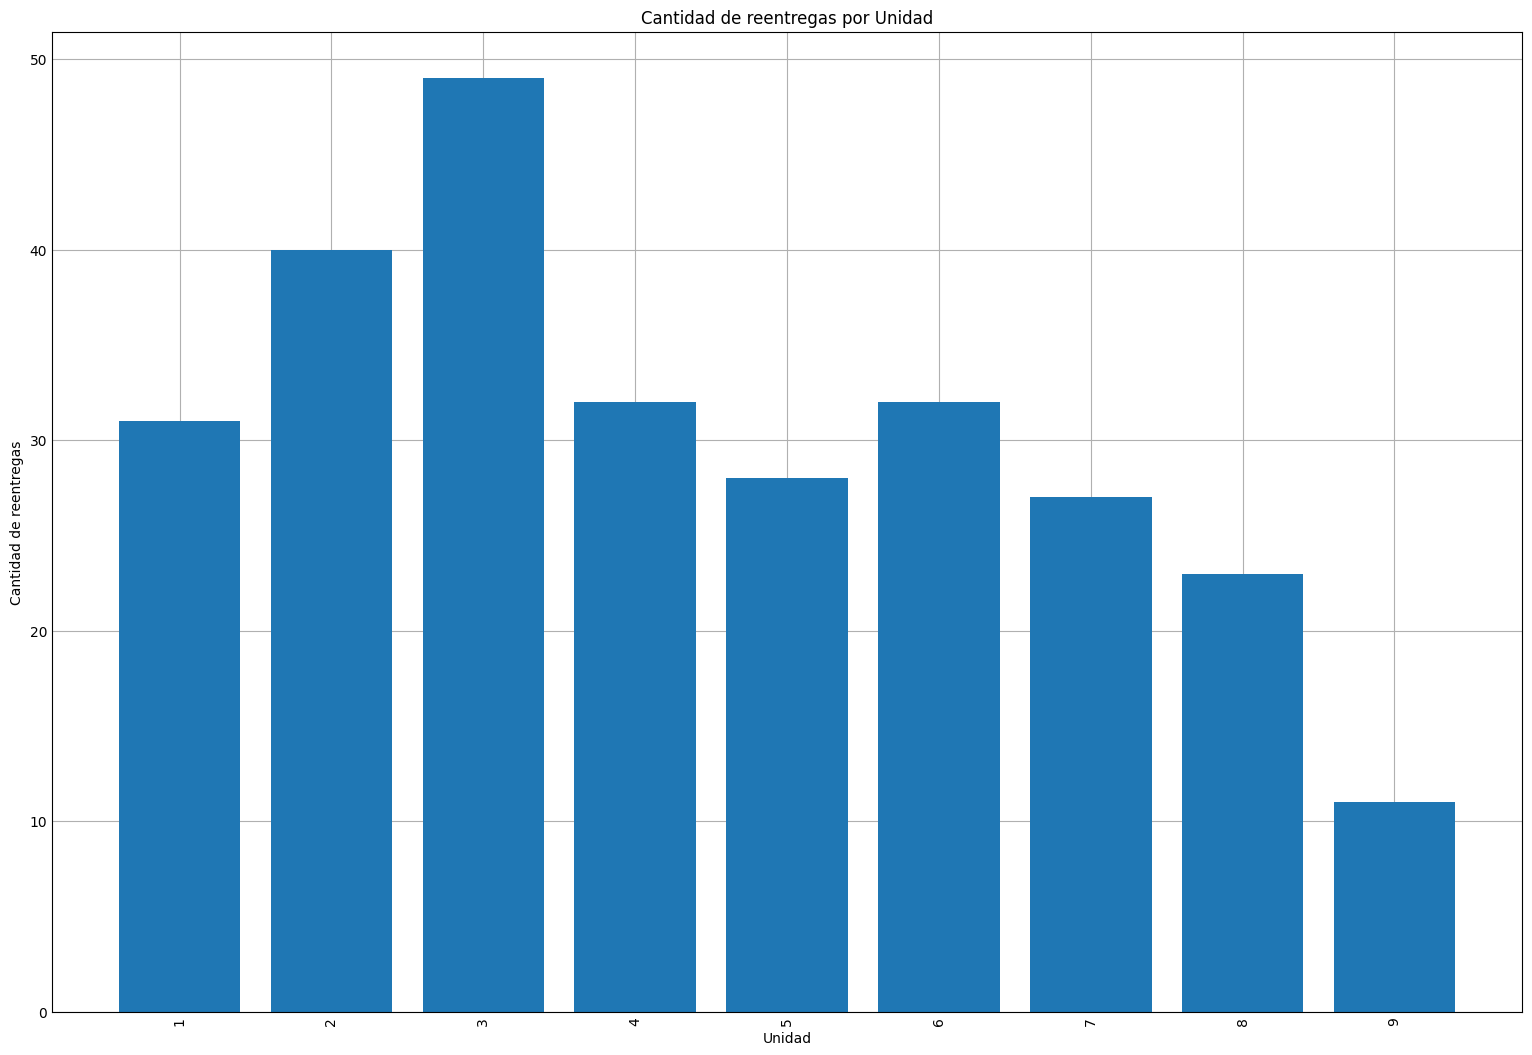

In [73]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(cantidad_de_reentregas_por_unidad.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_entregas in x_sorted]
items_y = [cantidad_de_reentregas for alumno, cantidad_de_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de reentregas')
ax.set_title('Cantidad de reentregas por Unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Armemos el mismo grafico pero separando la cantidad de reentregas por unidad de la gente aprobada y de la desaprobada

In [74]:
#STACKED BAR de reentregas por unidad
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>,
   <UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@g

In [75]:
cantidad_de_reentregas_por_unidad_aprobados = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
cantidad_de_reentregas_por_unidad_desaprobados = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for persona, entregas_por_unidad in entregas_por_persona_y_unidad.items():
    if persona in alumnos_ids_aprobados:
        for unidad, entregas in entregas_por_unidad.items():
            cantidad_de_reentregas = 0
            if len(entregas) > 1:
                cantidad_de_reentregas = len(entregas) - 1
            cantidad_de_reentregas_por_unidad_aprobados[unidad] += cantidad_de_reentregas
    else:
        for unidad, entregas in entregas_por_unidad.items():
            cantidad_de_reentregas = 0
            if len(entregas) > 1:
                cantidad_de_reentregas = len(entregas) - 1
            cantidad_de_reentregas_por_unidad_desaprobados[unidad] += cantidad_de_reentregas
    
print(cantidad_de_reentregas_por_unidad_aprobados)
print(cantidad_de_reentregas_por_unidad_desaprobados)

{1: 16, 2: 31, 3: 37, 4: 25, 5: 23, 6: 26, 7: 20, 8: 18, 9: 10}
{1: 15, 2: 9, 3: 12, 4: 7, 5: 5, 6: 6, 7: 7, 8: 5, 9: 1}


In [76]:
#https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
# Vos podes armar un dataframe a partir de muchos vectores no? 
# https://datagy.io/pandas-dataframe-from-list/
zipped = list(zip(cantidad_de_reentregas_por_unidad_aprobados.keys(), 
                  cantidad_de_reentregas_por_unidad_aprobados.values(), 
                  cantidad_de_reentregas_por_unidad_desaprobados.values()))

df = pd.DataFrame(zipped, columns=['Unidad', 'Aprobados', 'Desaprobados'])
df


,Unidad,Aprobados,Desaprobados
0,1,16,15
1,2,31,9
2,3,37,12
3,4,25,7
4,5,23,5
5,6,26,6
6,7,20,7
7,8,18,5
8,9,10,1


<AxesSubplot: title={'center': 'Stacked Bar Graph by dataframe'}, xlabel='Unidad'>

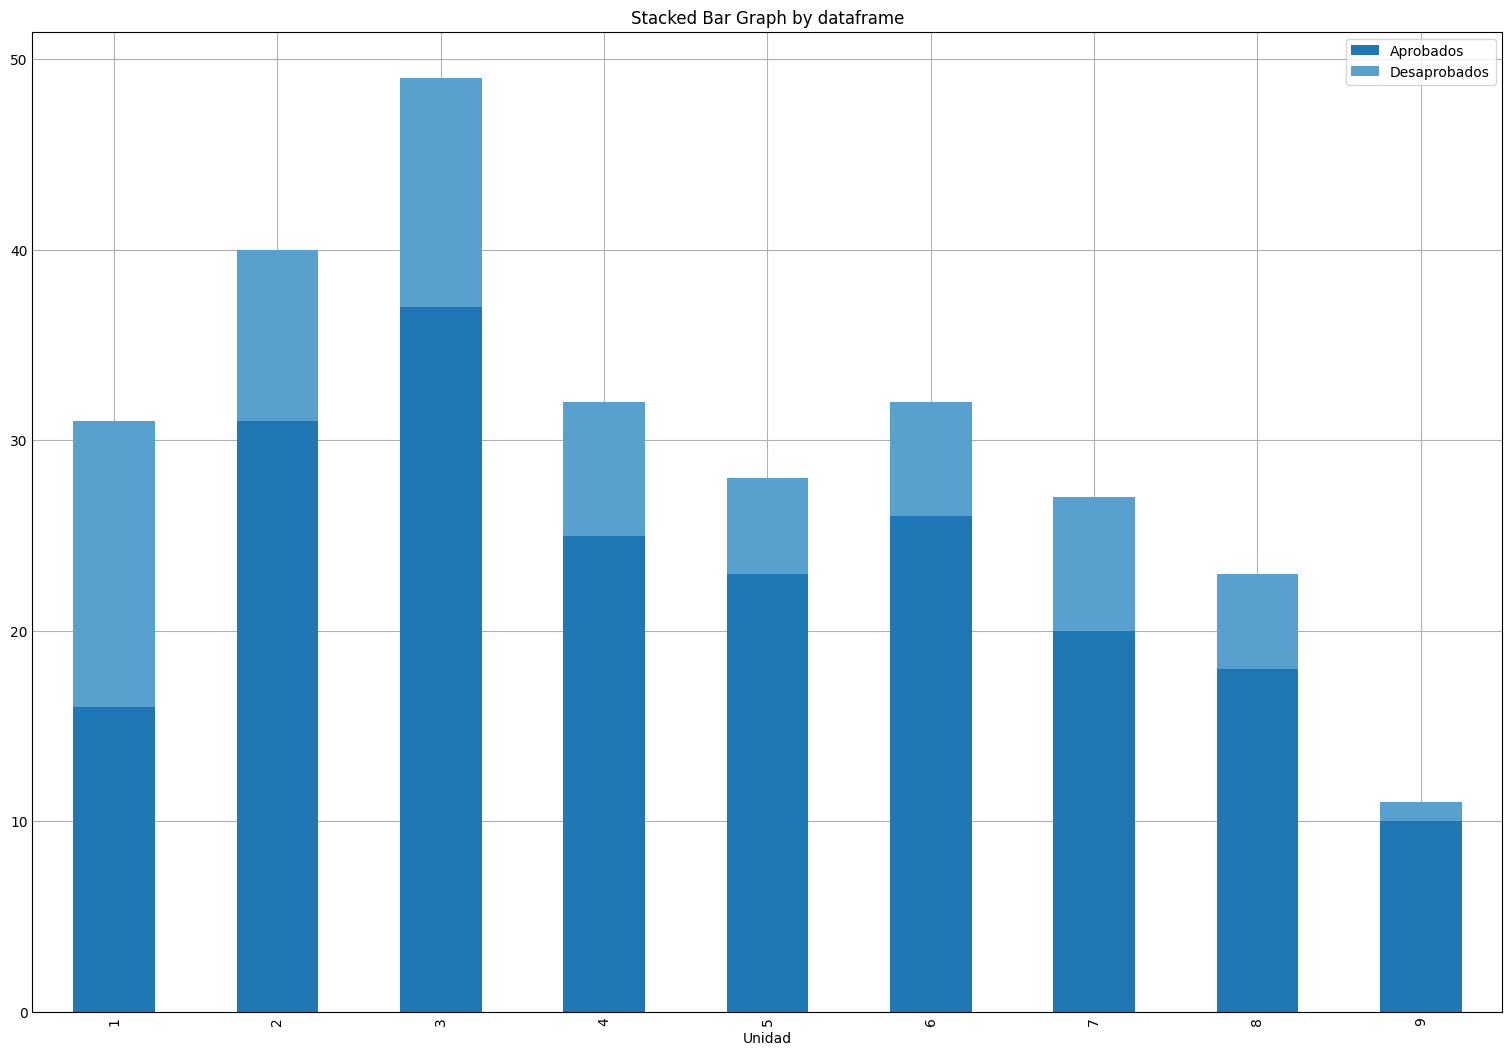

In [77]:
# plot data in stack manner of bar type
df.plot(x='Unidad', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(15, 10))

### Cuándo dejan la materia?

Vamos a probar ver a partir de las entregas cuando la gente dejó. Se va a interpretar como dejar en la última unidad entregada. Se pueden llegar a revisar estos casos con posteriores cruces de datos con eventos. 

La unidad 0 se va a usar para interpretar a todos aquellos que no entregaron nunca.

In [78]:
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>,
   <UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@g

In [79]:
def unidad_en_la_que_dejo(alumno):
    return max(entregas_por_persona_y_unidad.get(alumno.id, {}).keys(), default=0)
    

In [80]:
alumnos_por_unidad_que_dejaron = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno in alumnos:
    unidad_en_que_se_dejo = unidad_en_la_que_dejo(alumno)
    alumnos_por_unidad_que_dejaron[unidad_en_que_se_dejo] += 1
    
alumnos_por_unidad_que_dejaron

{0: 46, 1: 20, 2: 18, 3: 14, 4: 6, 5: 1, 6: 3, 7: 1, 8: 3, 9: 53}

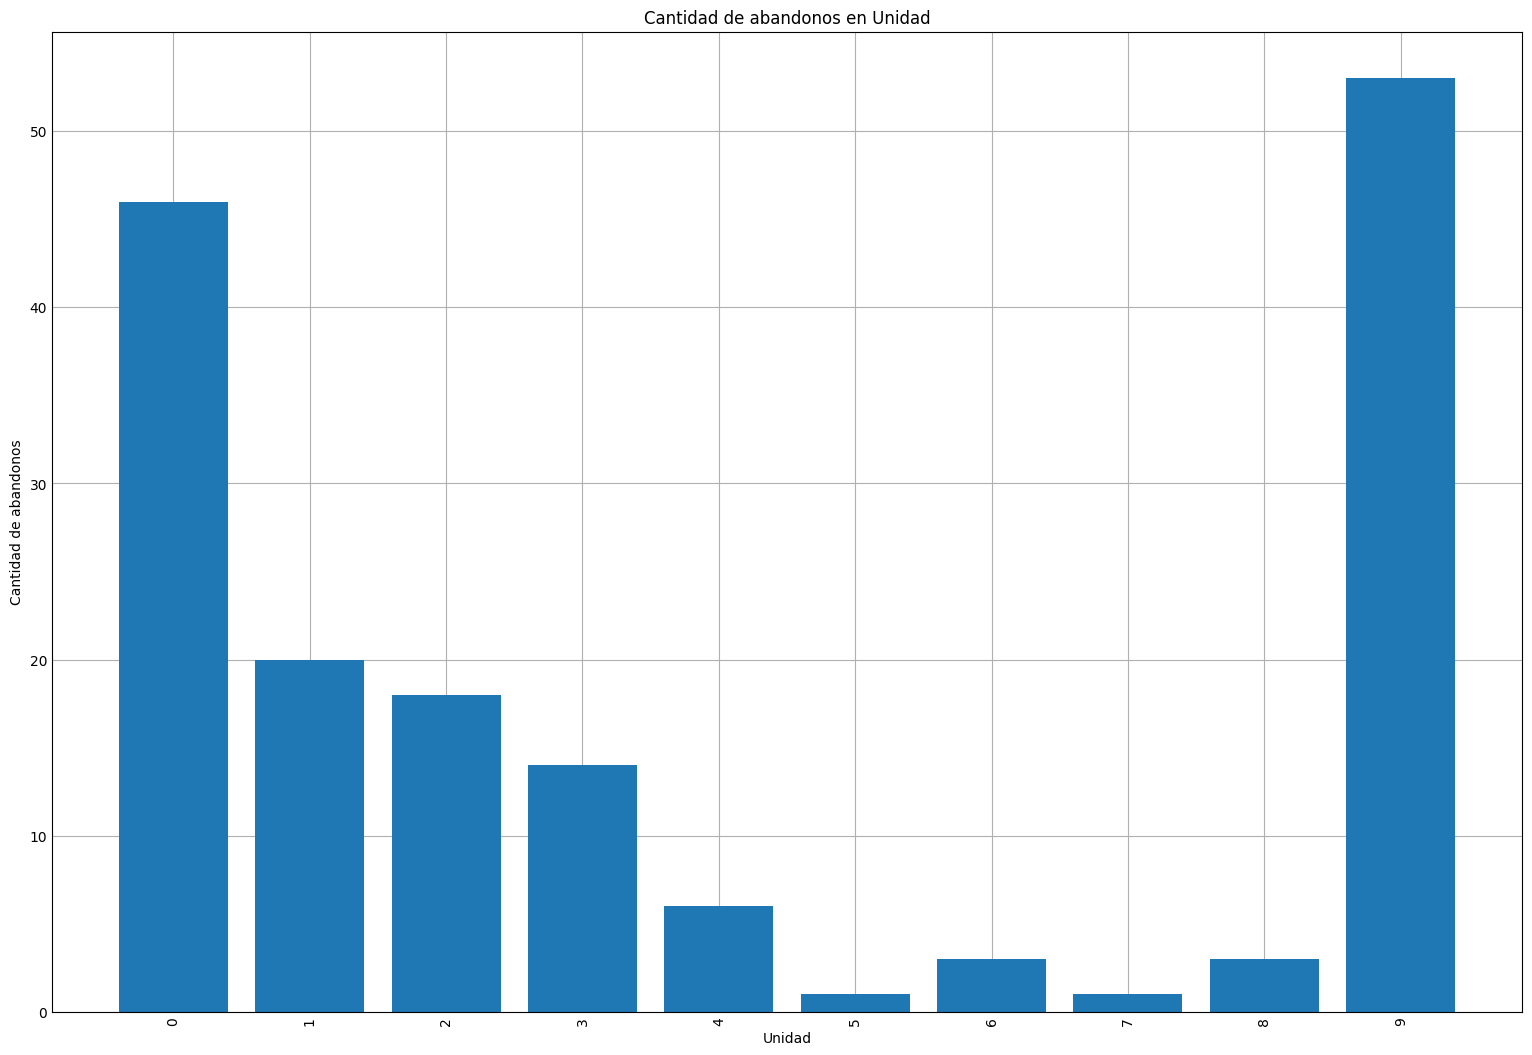

In [81]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(alumnos_por_unidad_que_dejaron.items(), key=operator.itemgetter(0))


items_x = [str(unidad) for unidad, cantidad_de_abandonos in x_sorted]
items_y = [cantidad_de_abandonos for unidad, cantidad_de_abandonos in x_sorted]

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de abandonos')
ax.set_title('Cantidad de abandonos en Unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()


Veamos cada alumno hasta que unidad llegó en la materia. 

Esto nos es útil para comparar posteriormente los datos de eventos. Se puede bloquear desde el navegador el uso de Google Analytics por lo que pueden existir casos que no tenemos la información real en los excel. Queremos tener esa información para filtrar los casos inconsistentes

In [82]:
entregas_por_persona_y_unidad

{390: {1: [<UnitSubmission: otromailmas@gmail.com: Unidad 1>]},
 388: {1: [<UnitSubmission: unmail@gmail.com: Unidad 1>]},
 387: {1: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 1>],
  2: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 2>,
   <UnitSubmission: juan.manu2699@gmail.com: Unidad 2>],
  3: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 3>],
  4: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 4>],
  5: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 5>],
  6: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 6>],
  7: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 7>],
  8: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 8>],
  9: [<UnitSubmission: juan.manu2699@gmail.com: Unidad 9>]},
 247: {1: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 1>],
  2: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 2>],
  3: [<UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
   <UnitSubmission: rdledesma1995@g

In [83]:
# Se utiliza el user para poder comparar con los eventos, que estan medidos con el user id y no el del StudentRecord

unidad_en_la_que_dejaron_los_alumnos = {}

for alumno in alumnos:
    unidad_en_que_se_dejo = unidad_en_la_que_dejo(alumno)
    unidad_en_la_que_dejaron_los_alumnos[alumno.user.id] = unidad_en_que_se_dejo
    
unidad_en_la_que_dejaron_los_alumnos

{108: 9,
 110: 9,
 117: 0,
 119: 0,
 121: 9,
 122: 1,
 123: 8,
 125: 2,
 126: 1,
 127: 0,
 128: 0,
 130: 3,
 94: 9,
 96: 2,
 97: 0,
 100: 3,
 101: 4,
 103: 3,
 104: 9,
 105: 9,
 106: 4,
 107: 9,
 132: 0,
 133: 9,
 137: 0,
 142: 9,
 143: 9,
 144: 0,
 151: 0,
 188: 9,
 190: 1,
 198: 1,
 206: 6,
 207: 9,
 259: 9,
 260: 2,
 270: 0,
 264: 9,
 256: 0,
 283: 3,
 109: 0,
 118: 3,
 120: 3,
 124: 0,
 129: 1,
 131: 3,
 134: 0,
 136: 0,
 138: 9,
 140: 0,
 148: 0,
 150: 9,
 156: 2,
 192: 9,
 201: 2,
 22: 9,
 24: 2,
 27: 2,
 28: 9,
 43: 9,
 55: 9,
 69: 0,
 70: 5,
 71: 3,
 83: 0,
 84: 0,
 89: 4,
 93: 9,
 98: 7,
 99: 1,
 272: 1,
 280: 4,
 135: 0,
 139: 8,
 145: 1,
 166: 1,
 167: 9,
 173: 0,
 200: 0,
 202: 9,
 246: 3,
 265: 0,
 267: 0,
 269: 1,
 271: 0,
 278: 0,
 279: 0,
 21: 9,
 25: 9,
 26: 0,
 30: 1,
 32: 1,
 35: 0,
 38: 9,
 40: 0,
 44: 9,
 46: 1,
 48: 0,
 49: 0,
 59: 0,
 60: 2,
 67: 0,
 79: 0,
 81: 1,
 92: 3,
 95: 0,
 149: 0,
 158: 1,
 163: 1,
 164: 3,
 189: 6,
 204: 0,
 208: 9,
 251: 2,
 282: 2,
 1

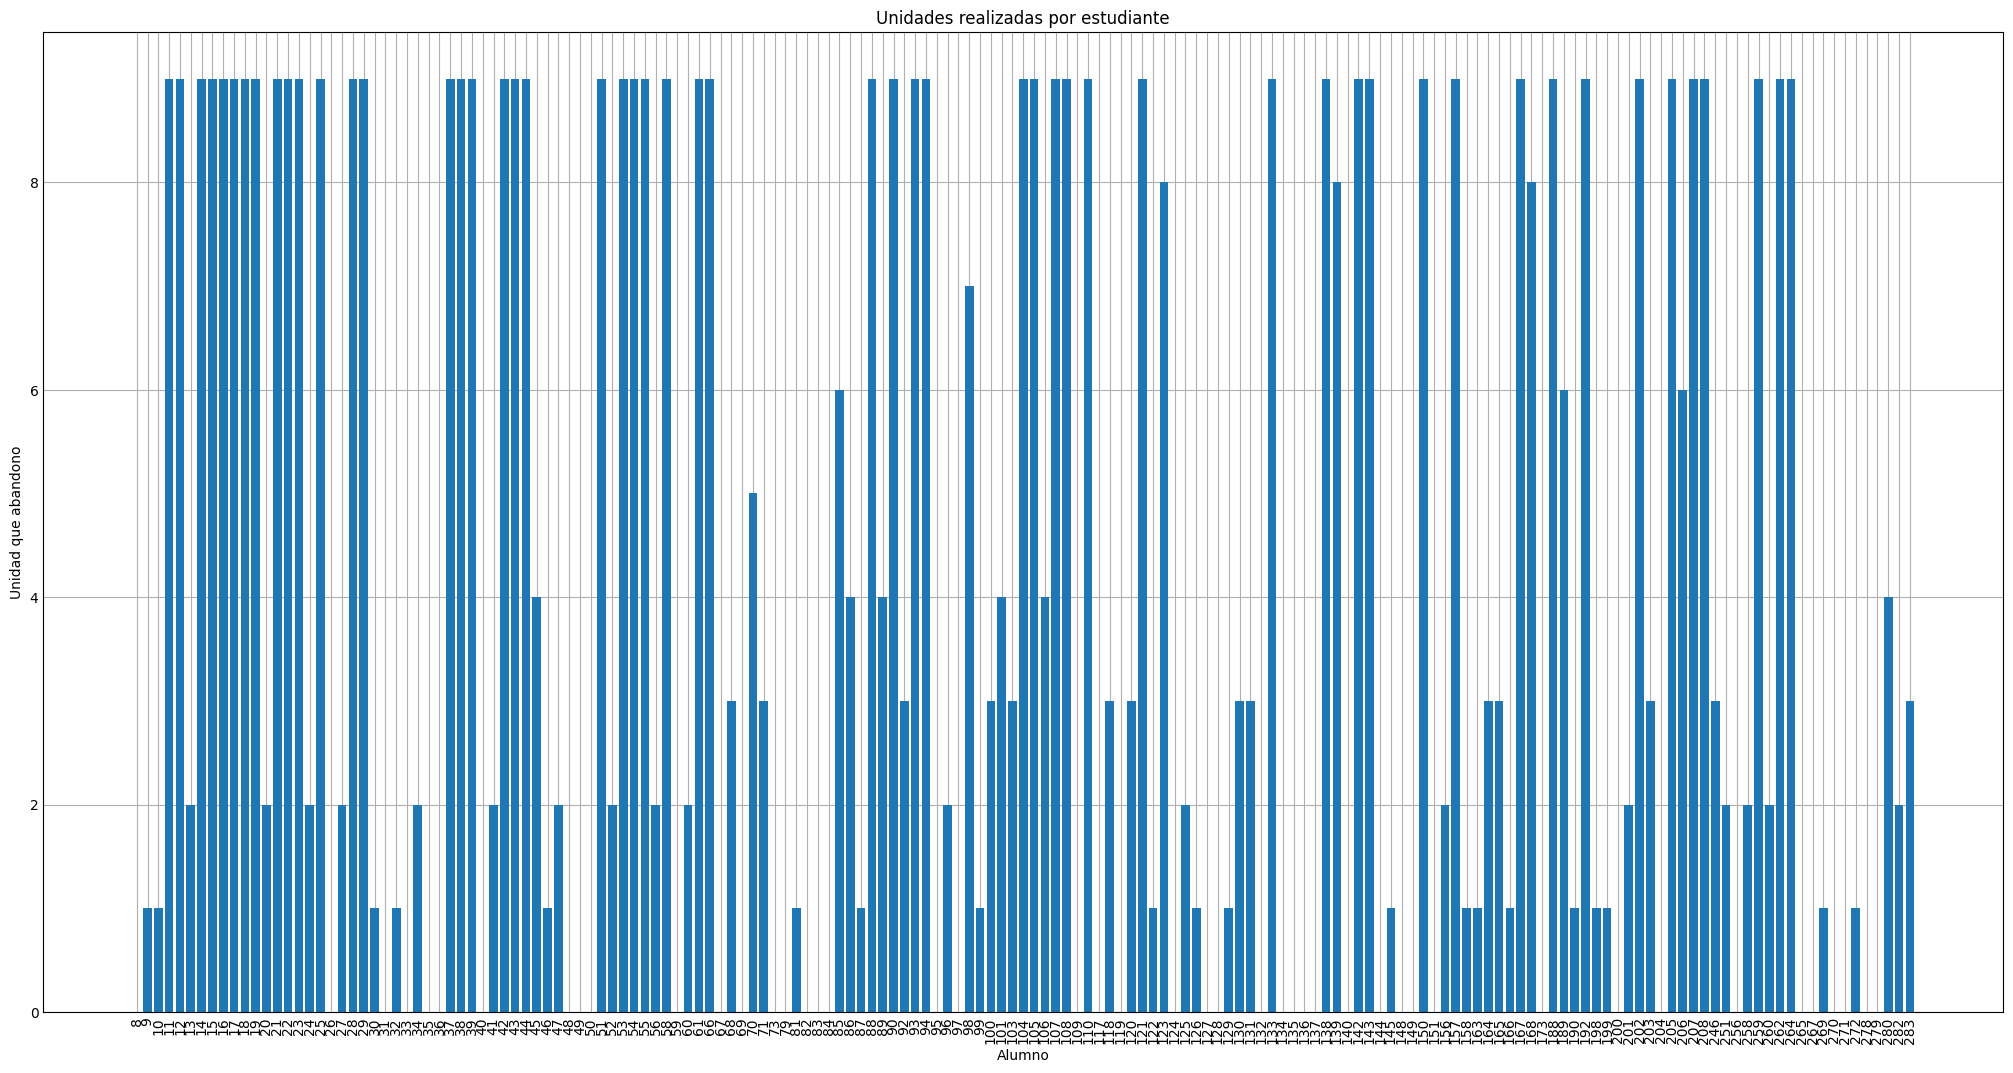

In [84]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(unidad_en_la_que_dejaron_los_alumnos.items(), key=operator.itemgetter(0))


items_x = [str(user) for user, unidad_que_abandono in x_sorted]
items_y = [unidad_que_abandono for user, unidad_que_abandono in x_sorted]

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Alumno')
ax.set_ylabel('Unidad que abandono')
ax.set_title('Unidades realizadas por estudiante')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

### Ejercicios

Empecemos a revisar las entregas pero por ejercicio y no por entrega en general. Pueden haber casos de multiples entregas pero que entregaron ejercicios por separado. 

In [85]:
todos_los_ejercicios = Exercise.objects.all()
todos_los_ejercicios.count()

3020

In [86]:
ejercicios_por_alumno = {}

for ejercicio in todos_los_ejercicios:
    alumno_id = ejercicio.student_record().id
    if alumno_id in ejercicios_por_alumno.keys():
        ejercicios_por_alumno[alumno_id].append(ejercicio)
    else:
        ejercicios_por_alumno[alumno_id] = [ejercicio]

ejercicios_por_alumno


{390: [<Exercise: Ejercicio rebotes.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio esfera.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio geringoso.py de otromailmas@gmail.com>],
 388: [<Exercise: Ejercicio rebotes.py de unmail@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de unmail@gmail.com>,
  <Exercise: Ejercicio esfera.py de unmail@gmail.com>,
  <Exercise: Ejercicio geringoso.py de unmail@gmail.com>],
 387: [<Exercise: Ejercicio rebotes.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio esfera.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio geringoso.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio buscar_precios.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio costo_camion.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio camion_commandline.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio diccionario_geringoso.

In [87]:
ejercicios_por_unidad = {}

for ejercicio in todos_los_ejercicios:
    unidad = ejercicio.unit()
    if unidad in ejercicios_por_unidad.keys():
        ejercicios_por_unidad[unidad].append(ejercicio)
    else:
        ejercicios_por_unidad[unidad] = [ejercicio]

ejercicios_por_unidad

{1: [<Exercise: Ejercicio rebotes.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio esfera.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio geringoso.py de otromailmas@gmail.com>,
  <Exercise: Ejercicio rebotes.py de unmail@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de unmail@gmail.com>,
  <Exercise: Ejercicio esfera.py de unmail@gmail.com>,
  <Exercise: Ejercicio geringoso.py de unmail@gmail.com>,
  <Exercise: Ejercicio rebotes.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio esfera.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio geringoso.py de juan.manu2699@gmail.com>,
  <Exercise: Ejercicio rebotes.py de rdledesma1995@gmail.com>,
  <Exercise: Ejercicio hipoteca.py de rdledesma1995@gmail.com>,
  <Exercise: Ejercicio esfera.py de rdledesma1995@gmail.com>,
  <Exercise: Ejercicio geringoso.py de rdledesma1995@gmail.com>,
  <Exercise: Ejer

In [88]:
ejercicios_por_alumno_y_unidad = {}

for alumno_id, ejercicios in ejercicios_por_alumno.items():
    ejercicios_por_unidad_local = {}
    for ejercicio in ejercicios: 
        unidad = ejercicio.unit()
        if unidad in ejercicios_por_unidad_local.keys():
            ejercicios_por_unidad_local[unidad].append(ejercicio)
        else:
            ejercicios_por_unidad_local[unidad] = [ejercicio]

    ejercicios_por_alumno_y_unidad[alumno_id] = ejercicios_por_unidad_local
    
ejercicios_por_alumno_y_unidad



{390: {1: [<Exercise: Ejercicio rebotes.py de otromailmas@gmail.com>,
   <Exercise: Ejercicio hipoteca.py de otromailmas@gmail.com>,
   <Exercise: Ejercicio esfera.py de otromailmas@gmail.com>,
   <Exercise: Ejercicio geringoso.py de otromailmas@gmail.com>]},
 388: {1: [<Exercise: Ejercicio rebotes.py de unmail@gmail.com>,
   <Exercise: Ejercicio hipoteca.py de unmail@gmail.com>,
   <Exercise: Ejercicio esfera.py de unmail@gmail.com>,
   <Exercise: Ejercicio geringoso.py de unmail@gmail.com>]},
 387: {1: [<Exercise: Ejercicio rebotes.py de juan.manu2699@gmail.com>,
   <Exercise: Ejercicio hipoteca.py de juan.manu2699@gmail.com>,
   <Exercise: Ejercicio esfera.py de juan.manu2699@gmail.com>,
   <Exercise: Ejercicio geringoso.py de juan.manu2699@gmail.com>],
  2: [<Exercise: Ejercicio buscar_precios.py de juan.manu2699@gmail.com>,
   <Exercise: Ejercicio costo_camion.py de juan.manu2699@gmail.com>,
   <Exercise: Ejercicio camion_commandline.py de juan.manu2699@gmail.com>,
   <Exercise: E

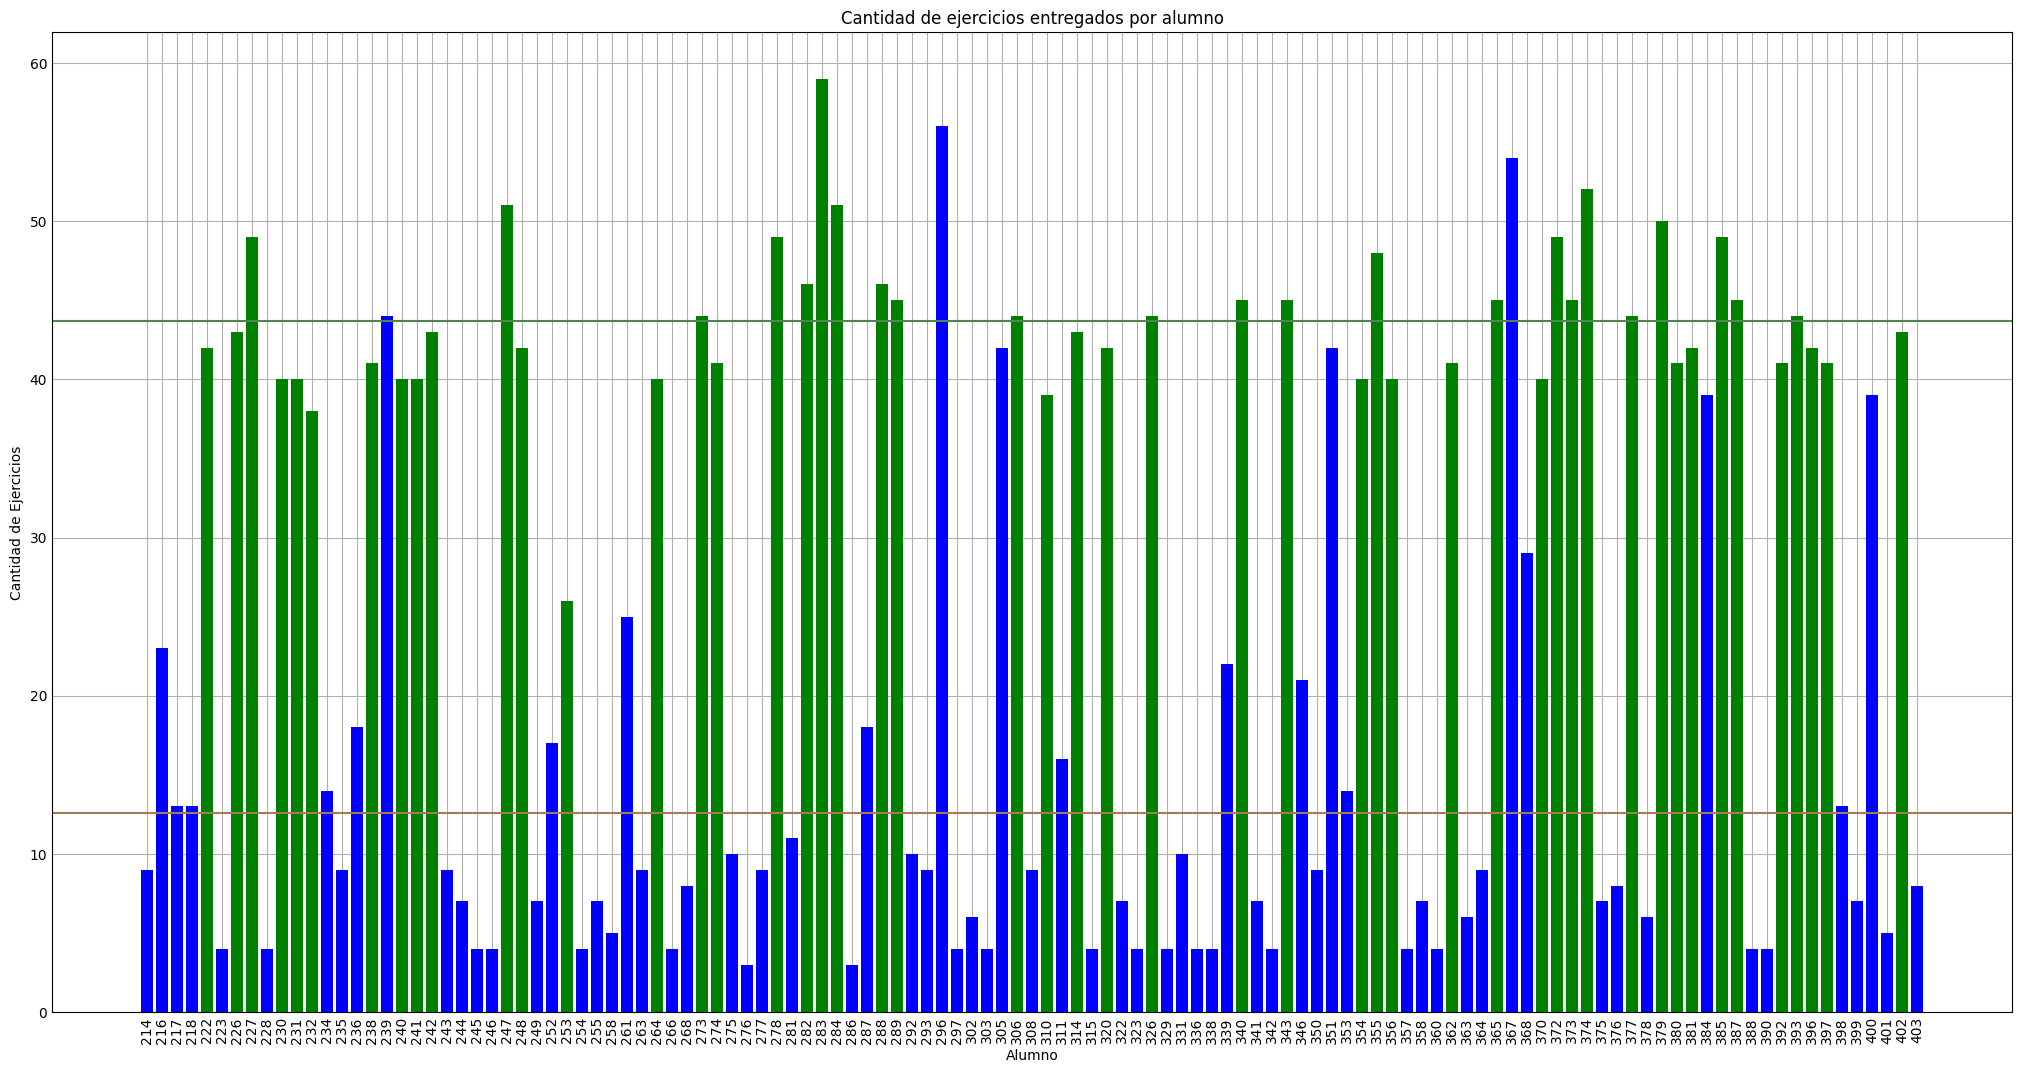

In [89]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(ejercicios_por_alumno.items(), key=operator.itemgetter(0))

items_x = [str(alumno) for alumno, ejercicios in x_sorted]
items_y = [len(ejercicios) for alumno, ejercicios in x_sorted]

colors = []
aprobados = []
desaprobados = []

for alumno in items_x:
    if int(alumno) in alumnos_ids_aprobados:
        colors.append('green')
        aprobados.append(len(ejercicios_por_alumno[int(alumno)]))
    else:
        colors.append('blue')
        desaprobados.append(len(ejercicios_por_alumno[int(alumno)]))
        
media_aprobados = sum(aprobados) / len(aprobados)
media_desaprobados = sum(desaprobados) / len(desaprobados)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y, color=colors)

plt.axhline(y=media_aprobados, color='#518451', linestyle='-')
plt.axhline(y=media_desaprobados, color='#a47b55', linestyle='-')

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de Ejercicios')
ax.set_title('Cantidad de ejercicios entregados por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Naturalmente las personas que aprobaron van a tener mas ejercicios entregados. Posiblemente por haber hecho más unidades que la gente que dejo. Pero puede llegar a ser interesante ver los casos de las personas que entregar por encima del promedio de entregas de los aprobados pero desaprobaron. 

Veamos los ejercicios entregados del alumno 296

In [90]:
ejercicios_por_alumno_y_unidad[296]

{1: [<Exercise: Ejercicio rebotes.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio hipoteca.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio esfera.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio geringoso.py de jonathan.moreno.87@hotmail.com>],
 2: [<Exercise: Ejercicio buscar_precios.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio costo_camion.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio camion_commandline.py de jonathan.moreno.87@hotmail.com>],
 4: [<Exercise: Ejercicio busqueda_en_listas.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio invlista.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio propaga.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio arboles.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio busqueda_en_listas.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio invlista.py de jonathan.moreno.87@hotmail.com>,
  <Exercise: Ejercicio propaga

Es un alumno que llegó hasta el final de la cursada pero no aprobó. Entregó varias veces en algunas unidades. Puede ser eso un patrón para la gente que está al final de la cursada. Hay que darle temporalidad a este análisis.

Vamos a ver la cantidad de ejercicios por unidad. Va a ser natural que haya muchos ejercicios más en la primera parte de la materia. Pero después podemos jugar con la cantidad de personas que entregaron y la cantidad de ejercicios por unidad que hay.

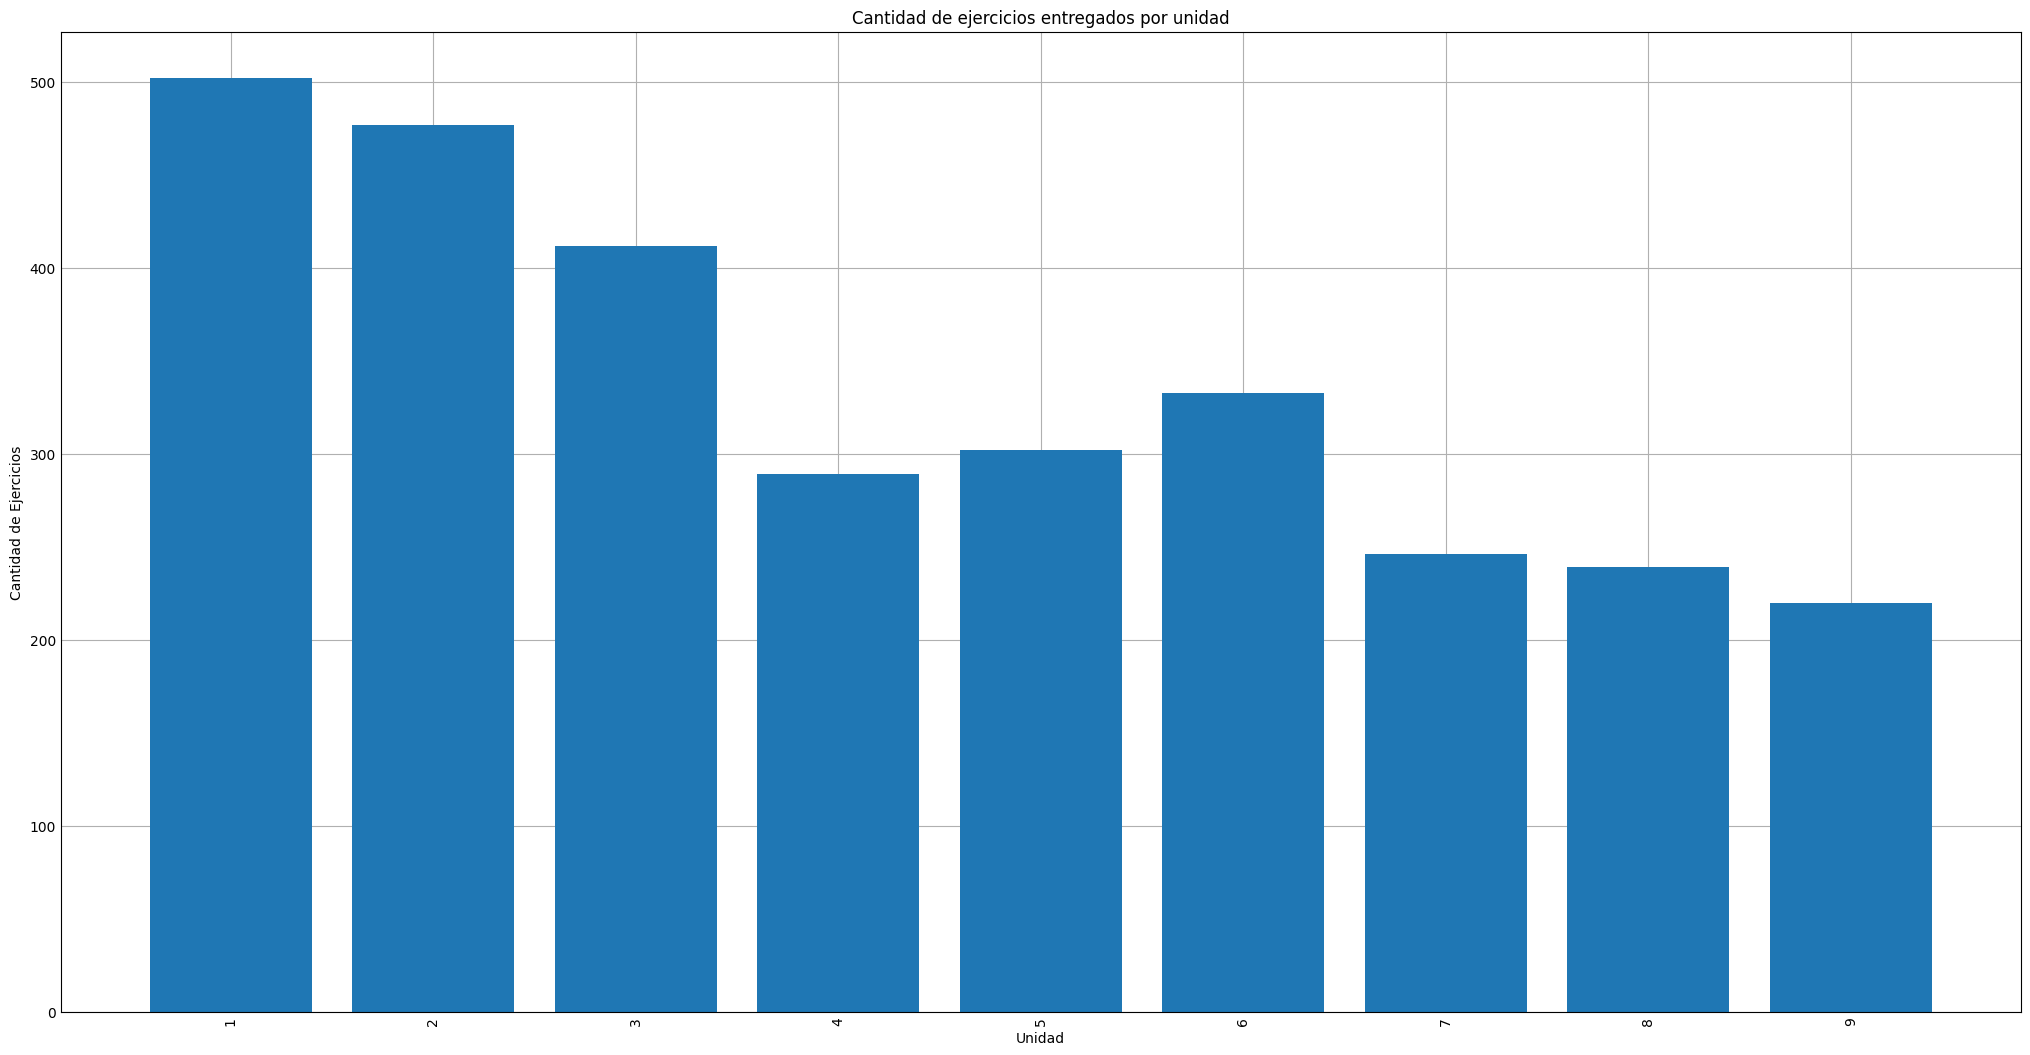

In [91]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(ejercicios_por_unidad.items(), key=operator.itemgetter(0))

items_x = [str(unidad) for unidad, ejercicios in x_sorted]
items_y = [len(ejercicios) for alumno, ejercicios in x_sorted]

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de Ejercicios')
ax.set_title('Cantidad de ejercicios entregados por unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

#### Revisar
Estaria bueno meter aca un dividido la cantidad de alumnos que entregaron ejercicio de la unidad, pero sin contar reentregas creo. 

Vamos a ponderar cada unidad con la cantidad de ejercicios que había para entregar.

In [92]:
ejercicios_entregables_por_unidad = {1:4, 2:5, 3:5, 4:4, 5:5, 6:5, 7:4, 8:4, 9:5}

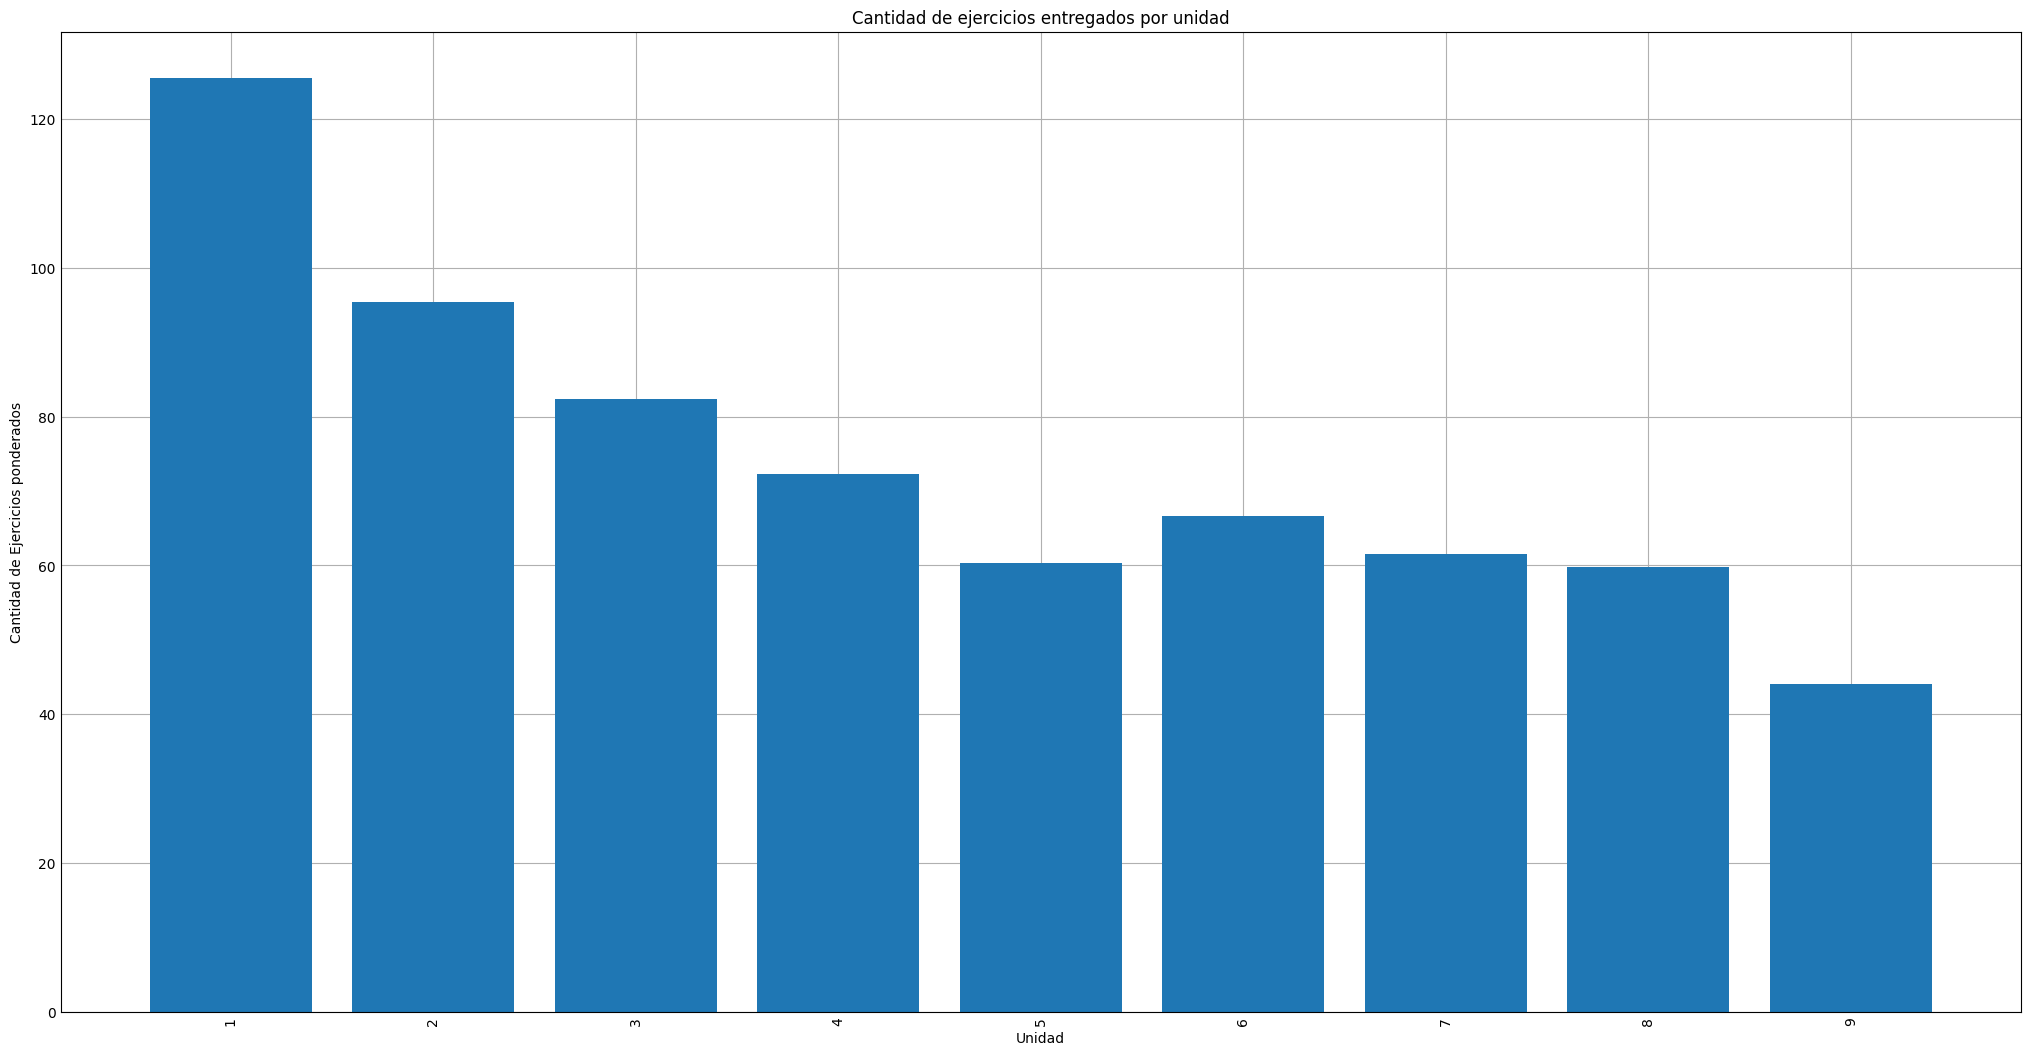

In [93]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(ejercicios_por_unidad.items(), key=operator.itemgetter(0))

items_x = [str(unidad) for unidad, ejercicios in x_sorted]
items_y = [len(ejercicios)/ejercicios_entregables_por_unidad[unidad] for unidad, ejercicios in x_sorted]

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de Ejercicios ponderados')
ax.set_title('Cantidad de ejercicios entregados por unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Veamos la cantidad de reentregas por ejercicios de cada unidad

In [94]:
reentregas_por_unidad = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for alumno, ejercicios_por_unidad in ejercicios_por_alumno_y_unidad.items():
    for unidad, ejercicios in ejercicios_por_unidad.items():
        nombres_de_ejercicios = [ejercicio.name for ejercicio in ejercicios]
        reentregas_por_unidad[unidad] += len(nombres_de_ejercicios) - len(set(nombres_de_ejercicios))
        
reentregas_por_unidad



{1: 51, 2: 45, 3: 60, 4: 33, 5: 23, 6: 50, 7: 24, 8: 19, 9: 11}

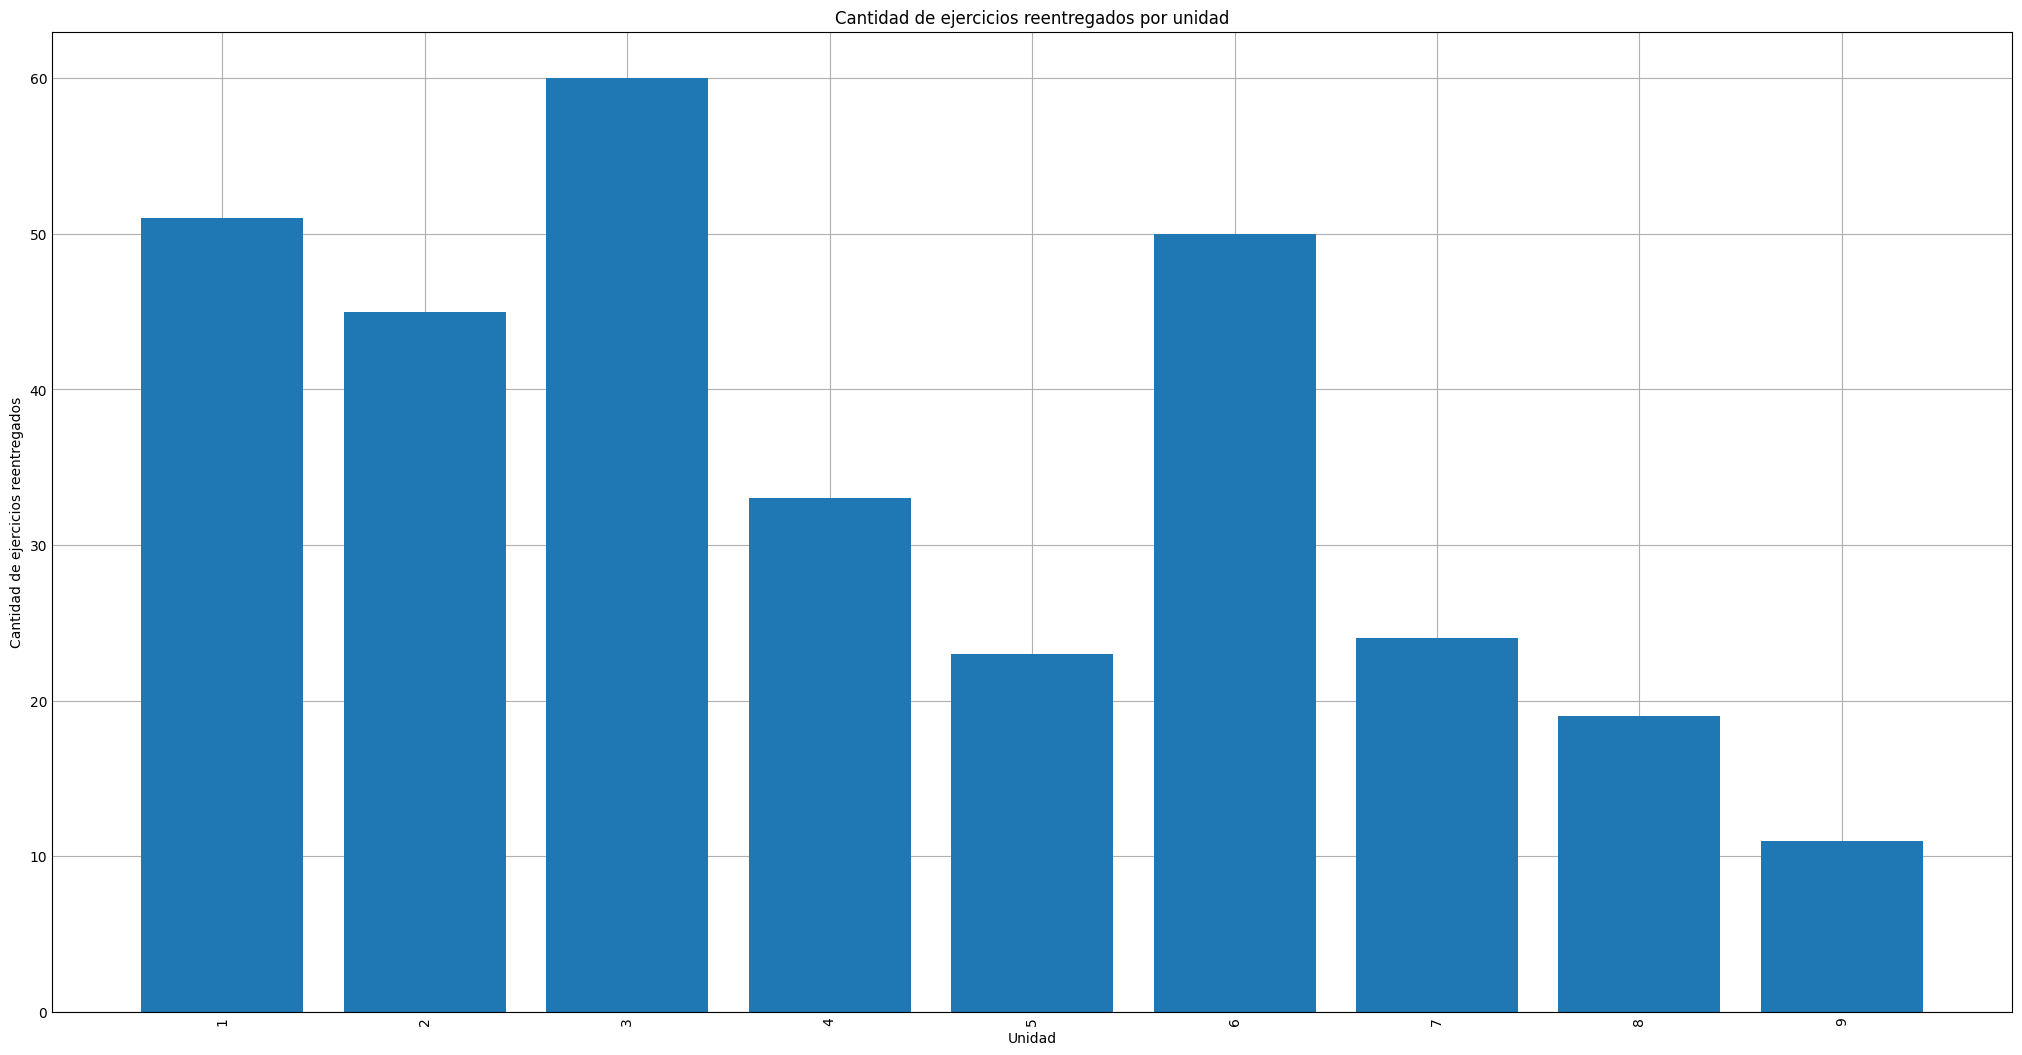

In [95]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(reentregas_por_unidad.items(), key=operator.itemgetter(0))

items_x = [str(unidad) for unidad, cant_reentregas in x_sorted]
items_y = [cant_reentregas for unidad, cant_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de ejercicios reentregados')
ax.set_title('Cantidad de ejercicios reentregados por unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

In [96]:
nombres_de_ejercicios_por_unidad = {
    "1": ["rebotes.py", "hipoteca.py", "esfera.py", "geringoso.py"],
    "2": ["buscar_precios.py", "costo_camion.py", "camion_commandline.py", "diccionario_geringoso.py", 
          "informe.py"],
    "3": ["solucion_de_errores.py", "costo_camion.py", "tabla_informe.py", "tablamult.py", "arboles.py"],
    "4": ["busqueda_en_listas.py", "invlista.py", "propaga.py", "arboles.py"],
    "5": ["generala.py", "termometro.py", "plotear_temperaturas.py", "figuritas.py", "arboles.py"],
    "6": ["fileparse.py", "informe_funciones.py", "costo_camion.py", "bbin.py", "plot_bbin_vs_bsec.py"],
    "7": ["fileparse.py", "informe_final.py", "documentacion.py", "random_walk.py"],
    "8": ["vida.py", "listar_imgs.py", "arbolado_parques_veredas.py", "mareas_a_mano.py"],
    "9": ["informe_final.py", "lote.py", "torre_control.py", "canguros_buenos.py", "NDVI.py"],
}

Mandarle un csv a Mati con esto para cada ejercicio:
- Archivo entregado
- Unidad
- Persona
- Fecha


In [97]:
#import csv

# Lista de objetos Archivo
#ejercicios = Exercise.objects.all() 

# Nombre del archivo CSV de salida
#nombre_archivo_csv = "ejercicios.csv"

# Crear y escribir en el archivo CSV
#with open(nombre_archivo_csv, mode='w', newline='') as archivo_csv:
#    writer = csv.writer(archivo_csv)
#    writer.writerow(["Archivo", "Unidad", "Persona", "Fecha"])  # Escribir encabezados
#    for ejercicio in ejercicios:
#        writer.writerow([ejercicio.name, ejercicio.unit(), ejercicio.student_record().email, ejercicio.delivery_date()])  # Escribir datos de cada archivo

### Auto evaluacion

In [98]:
# SelfEvaluation.objects.all().fi('dedication_evaluation')
entregas_mucha_dedicacion = SelfEvaluation.objects.filter(dedication_evaluation=2)
entregas_mucha_dedicacion

entregas_puntuacion = SelfEvaluation.objects.filter(dedication_evaluation=2)

### Pair Review

In [99]:
from app.models.pair_review_corrections import PairReviewCorrection

PairReviewCorrection.objects.count()

95

In [100]:
#Si no participan 10 personas a partir de alguna unidad, no le dedicamos mucho tiempo.
pair_reviews = PairReviewCorrection.objects.all()

reviews_por_unidad = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for pair_review in pair_reviews:
    reviews_por_unidad[pair_review.exercise_unit()] += 1
    
reviews_por_unidad

{1: 0, 2: 11, 3: 16, 4: 26, 5: 6, 6: 22, 7: 14, 8: 0, 9: 0}

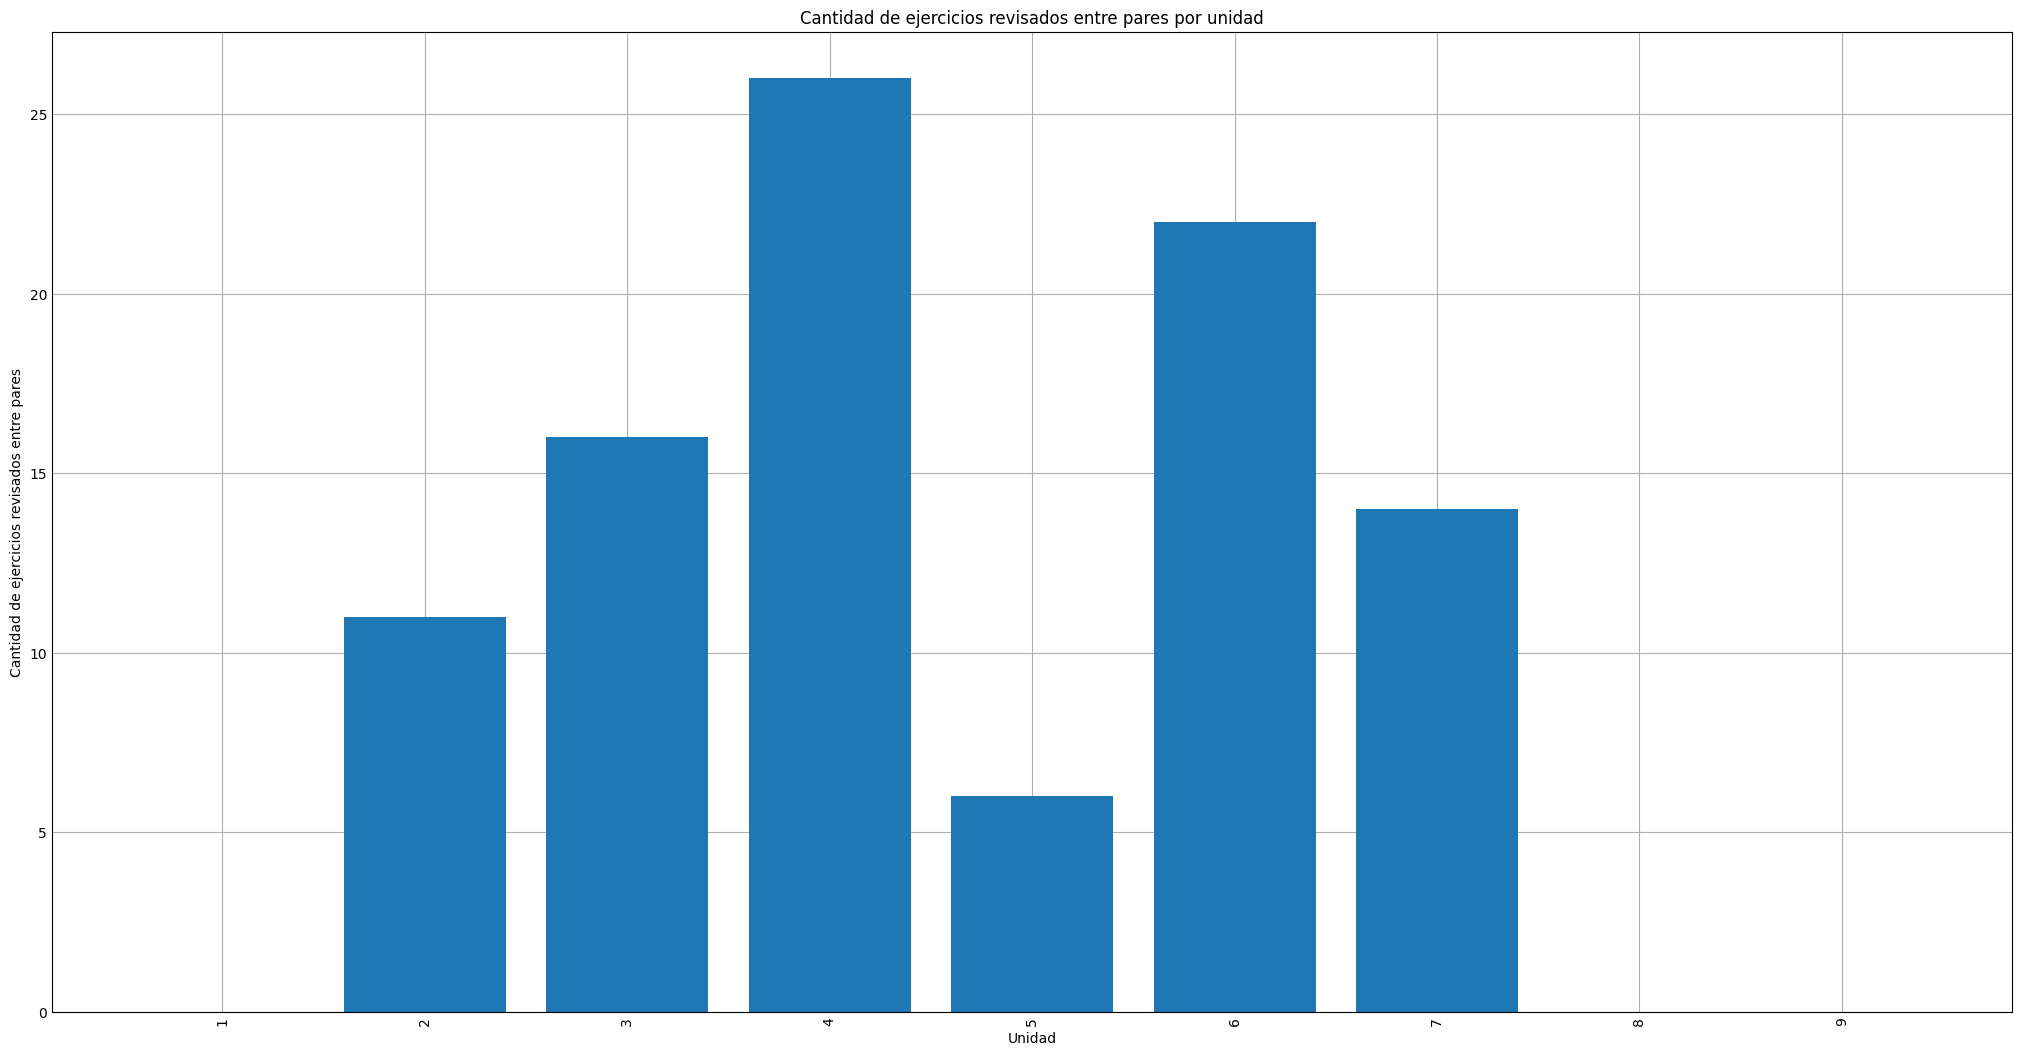

In [101]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(reviews_por_unidad.items(), key=operator.itemgetter(0))

items_x = [str(unidad) for unidad, cant_reentregas in x_sorted]
items_y = [cant_reentregas for unidad, cant_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de ejercicios revisados entre pares')
ax.set_title('Cantidad de ejercicios revisados entre pares por unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()


In [102]:
reviews_por_alumno = {}
for pair_review in pair_reviews:
    if pair_review.reviewer.id in reviews_por_alumno.keys():
        reviews_por_alumno[pair_review.reviewer.id] += 1
    else:
        reviews_por_alumno[pair_review.reviewer.id] = 1
    
reviews_por_alumno

{248: 5,
 239: 4,
 227: 7,
 354: 8,
 377: 6,
 241: 8,
 393: 1,
 402: 1,
 231: 10,
 283: 9,
 400: 1,
 247: 2,
 216: 2,
 370: 4,
 351: 2,
 277: 1,
 306: 5,
 264: 4,
 368: 3,
 374: 2,
 340: 2,
 384: 2,
 314: 2,
 232: 2,
 288: 2}

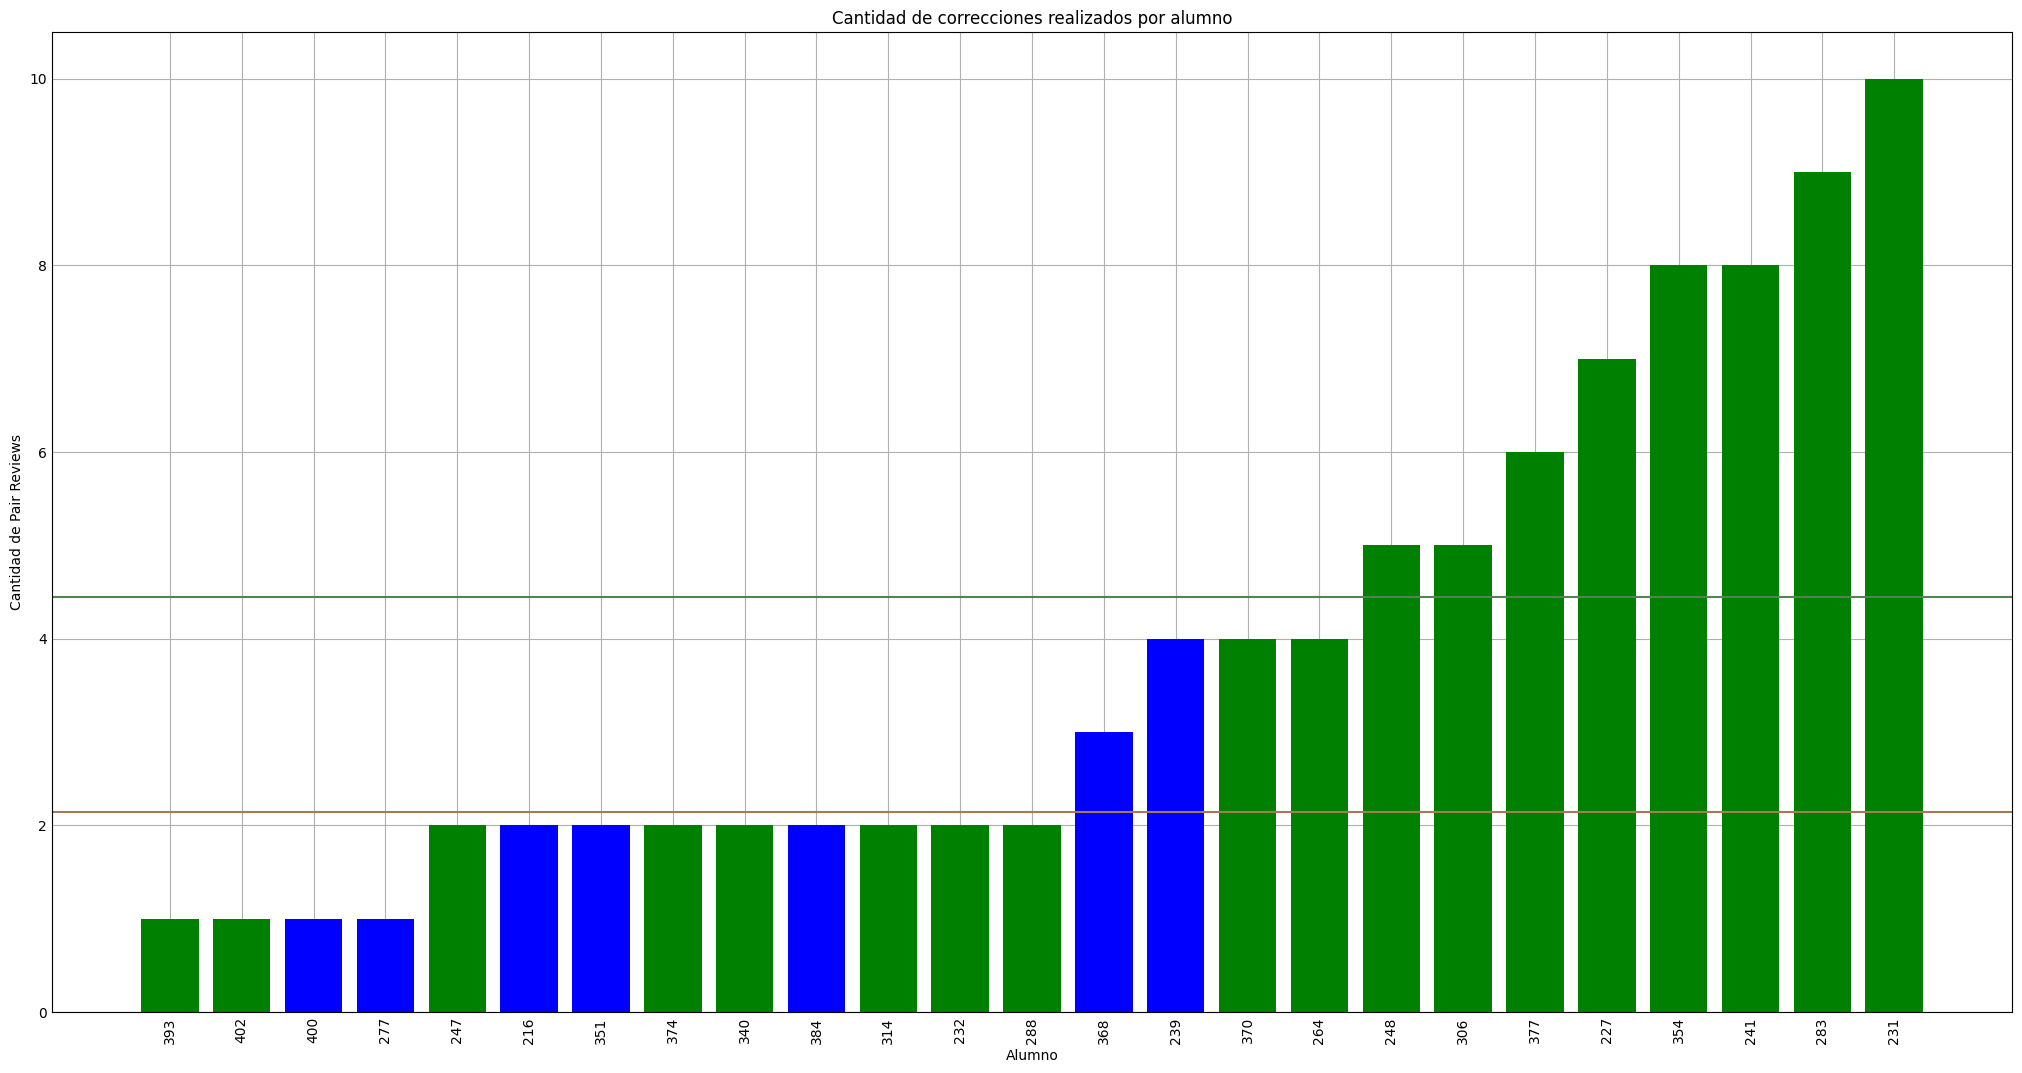

In [103]:
import operator 
# Ordenar por Y y con eso arreglo los items
x_sorted = sorted(reviews_por_alumno.items(), key=operator.itemgetter(1))

items_x = [str(alumno) for alumno, reviews in x_sorted]
items_y = [reviews for alumno, reviews in x_sorted]

colors = []
aprobados = []
desaprobados = []

for alumno in items_x:
    if int(alumno) in alumnos_ids_aprobados:
        colors.append('green')
        aprobados.append(reviews_por_alumno[int(alumno)])
    else:
        colors.append('blue')
        desaprobados.append(reviews_por_alumno[int(alumno)])
        
media_aprobados = sum(aprobados) / len(aprobados)
media_desaprobados = sum(desaprobados) / len(desaprobados)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y, color=colors)

plt.axhline(y=media_aprobados, color='#518451', linestyle='-')
plt.axhline(y=media_desaprobados, color='#a47b55', linestyle='-')

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de Pair Reviews')
ax.set_title('Cantidad de correcciones realizados por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

In [104]:
#Con el heat map que mandamos por whatsapp podemos poner en el eje Y las unidades y con eso podemos ver cuales se hicieron y cuales no.
# Podemos ver tmb la cantidad de correcciones porque te mandaban 2 ejercicios por unidad.
# Los azules les corrigieron menos? Podemos ver cuantas corregiste y cuantas te corrigieron.


In [105]:
from app.models import Correction

Correction.objects.count()

2302

### Correcciones automáticas

In [106]:
from app.models.authomatic_corrections import AuthomaticCorrection

AuthomaticCorrection.objects.count()

1050

In [107]:
authomatic_corrections = AuthomaticCorrection.objects.all()

correcciones_por_unidad = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for corrections in authomatic_corrections:
    correcciones_por_unidad[corrections.exercise.unit()] += 1
    
correcciones_por_unidad

{1: 0, 2: 0, 3: 378, 4: 288, 5: 0, 6: 158, 7: 134, 8: 92, 9: 0}

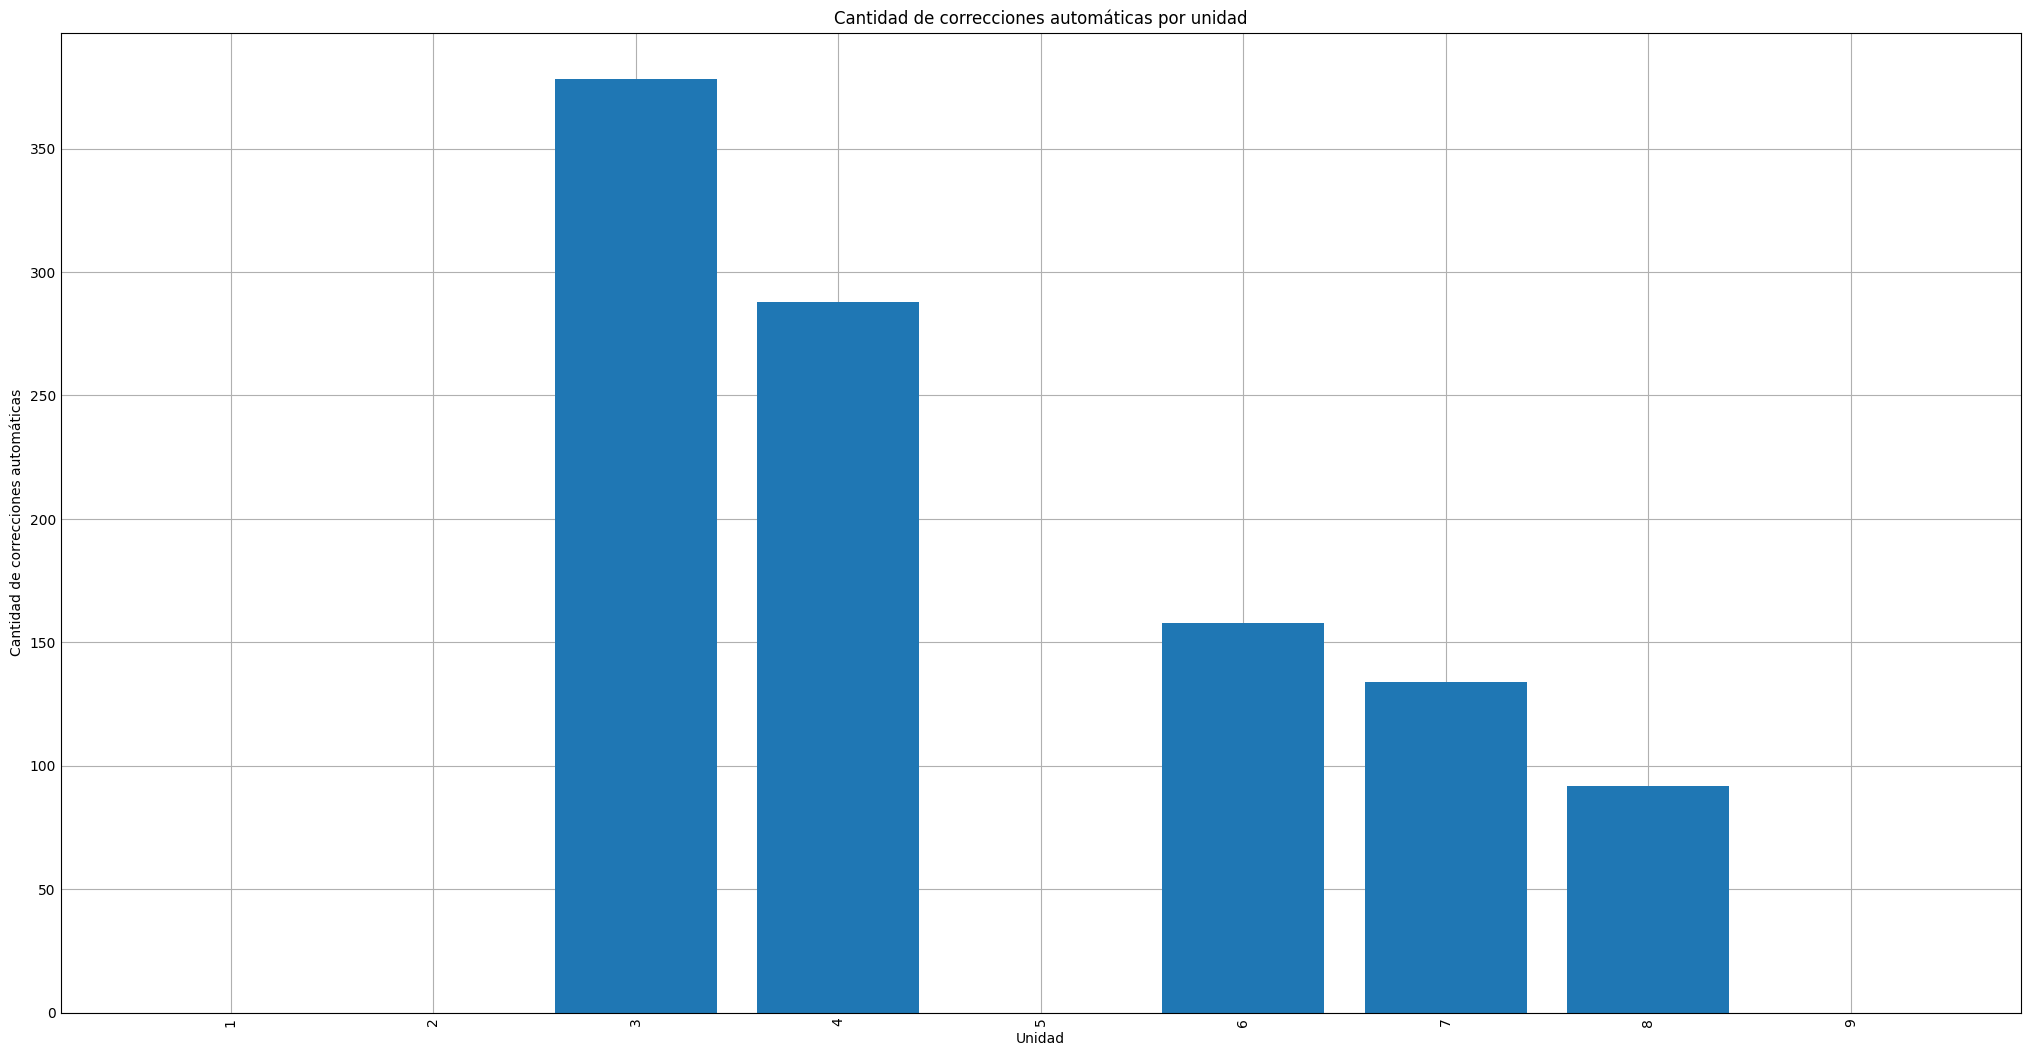

In [108]:
# REFACTORIZAR ESTO. ES EL METODO plot_barras_desde_diccionario CON COLORES
import operator 
x_sorted = sorted(correcciones_por_unidad.items(), key=operator.itemgetter(0))

items_x = [str(unidad) for unidad, cant_reentregas in x_sorted]
items_y = [cant_reentregas for unidad, cant_reentregas in x_sorted]

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y)

ax.set_xlabel('Unidad')
ax.set_ylabel('Cantidad de correcciones automáticas')
ax.set_title('Cantidad de correcciones automáticas por unidad')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Quiero entender cuantas correcciones hubo por cada alumno. 

In [109]:
correccion_por_alumno = {}
for correction in authomatic_corrections:
    if correction.exercise.student_record().id in correccion_por_alumno.keys():
        correccion_por_alumno[correction.exercise.student_record().id] += 1
    else:
        correccion_por_alumno[correction.exercise.student_record().id] = 1
    


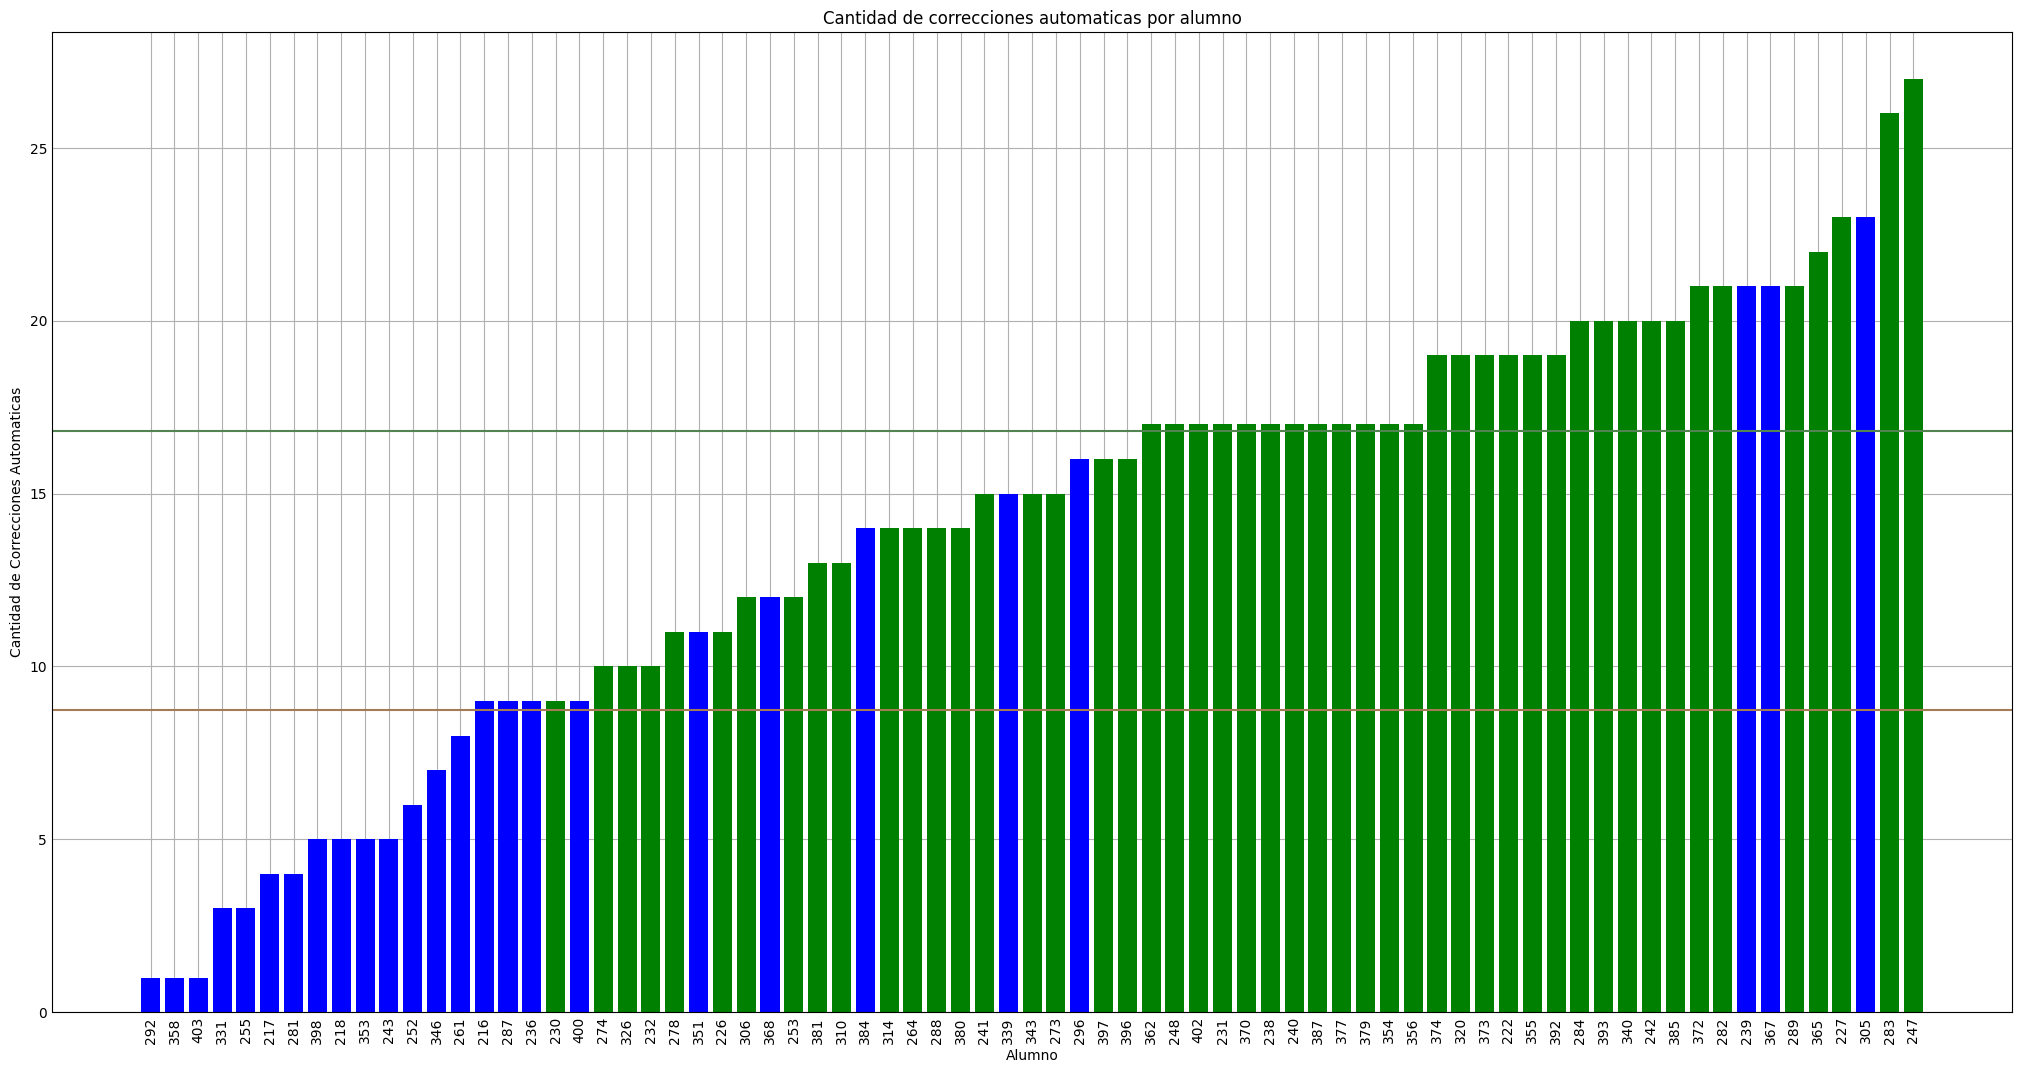

In [110]:
import operator 
x_sorted = sorted(correccion_por_alumno.items(), key=operator.itemgetter(1))

items_x = [str(alumno) for alumno, correccion in x_sorted]
items_y = [correccion for alumno, correccion in x_sorted]

colors = []
aprobados = []
desaprobados = []

for alumno in items_x:
    if int(alumno) in alumnos_ids_aprobados:
        colors.append('green')
        aprobados.append(correccion_por_alumno[int(alumno)])
    else:
        colors.append('blue')
        desaprobados.append(correccion_por_alumno[int(alumno)])
        
media_aprobados = sum(aprobados) / len(aprobados)
media_desaprobados = sum(desaprobados) / len(desaprobados)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y, color=colors)

plt.axhline(y=media_aprobados, color='#518451', linestyle='-')
plt.axhline(y=media_desaprobados, color='#a47b55', linestyle='-')

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de Correcciones Automaticas')
ax.set_title('Cantidad de correcciones automaticas por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

Voy a probar lo mismo pero separando entre las correcciones de las unidades 3 y 4 vs las de 6, 7 y 8

In [111]:
# Tenemos 3 correcciones automaticas para arboles.py xq se probaban 3 metodos distintos. 
# Tenemos que ver que corrigio cada test. 
# Los que les dio mal que score tienen? Podemos verlo con heatmap. Correccion automatica que se hizo y que porcentaje le dio a cada uno.
# Si te pasas del deadline, no recibis correccion automatica. Pero eso no significa que seas uno de los desaprobados o que dejaste. Por eso tenes distintas cantidades en verdes

In [112]:
corrections = AuthomaticCorrection.objects.filter(exercise__unit_submission__student_record_id=247)
[(correction.id, correction, correction.exercise.delivery_date(), correction.exercise.unit_submission.id, correction.exercise.id, correction.exercise.unit_submission, correction.executed_instruction) for correction in corrections]

[(1015,
  <AuthomaticCorrection: Corrección automática para Ejercicio costo_camion.py de rdledesma1995@gmail.com>,
  datetime.datetime(2022, 3, 30, 16, 1, 21, 606370, tzinfo=<UTC>),
  302,
  1090,
  <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
  '<p>Para evaluar la función costo_camion la llamamos de la siguiente manera:</p><code>costo_camion(fname)</code></p><p>donde fname es el nombre de un archivo csv con información de un camión, no necesariamente ordenada como en "camion.csv", y esperamos que nos devuelva el costo total del camión.</p>'),
 (1018,
  <AuthomaticCorrection: Corrección automática para Ejercicio tabla_informe.py de rdledesma1995@gmail.com>,
  datetime.datetime(2022, 3, 30, 16, 1, 21, 606370, tzinfo=<UTC>),
  302,
  1091,
  <UnitSubmission: rdledesma1995@gmail.com: Unidad 3>,
  '<p>Para evaluar la función hacer_informe la llamamos de la siguiente manera:</p><code>hacer_informe(camion, precios)</code></p><p>donde camion es una lista de diccionarios con informació

In [113]:
correciones_por_alumno_primeras_unidades = AuthomaticCorrection.objects.filter(exercise__unit_submission__unit__in=[1, 2, 3])

correccion_por_alumno_primeras_unidades = {}
for correction in correciones_por_alumno_primeras_unidades:
    if correction.exercise.student_record().id in correccion_por_alumno_primeras_unidades.keys():
        correccion_por_alumno_primeras_unidades[correction.exercise.student_record().id] += 1
    else:
        correccion_por_alumno_primeras_unidades[correction.exercise.student_record().id] = 1


In [114]:
correciones_por_alumno_ultimas_unidades = AuthomaticCorrection.objects.filter(exercise__unit_submission__unit__in=[4, 5, 6, 7, 8, 9])

correccion_por_alumno_ultimas_unidades = {}
for correction in correciones_por_alumno_ultimas_unidades:
    if correction.exercise.student_record().id in correccion_por_alumno_ultimas_unidades.keys():
        correccion_por_alumno_ultimas_unidades[correction.exercise.student_record().id] += 1
    else:
        correccion_por_alumno_ultimas_unidades[correction.exercise.student_record().id] = 1

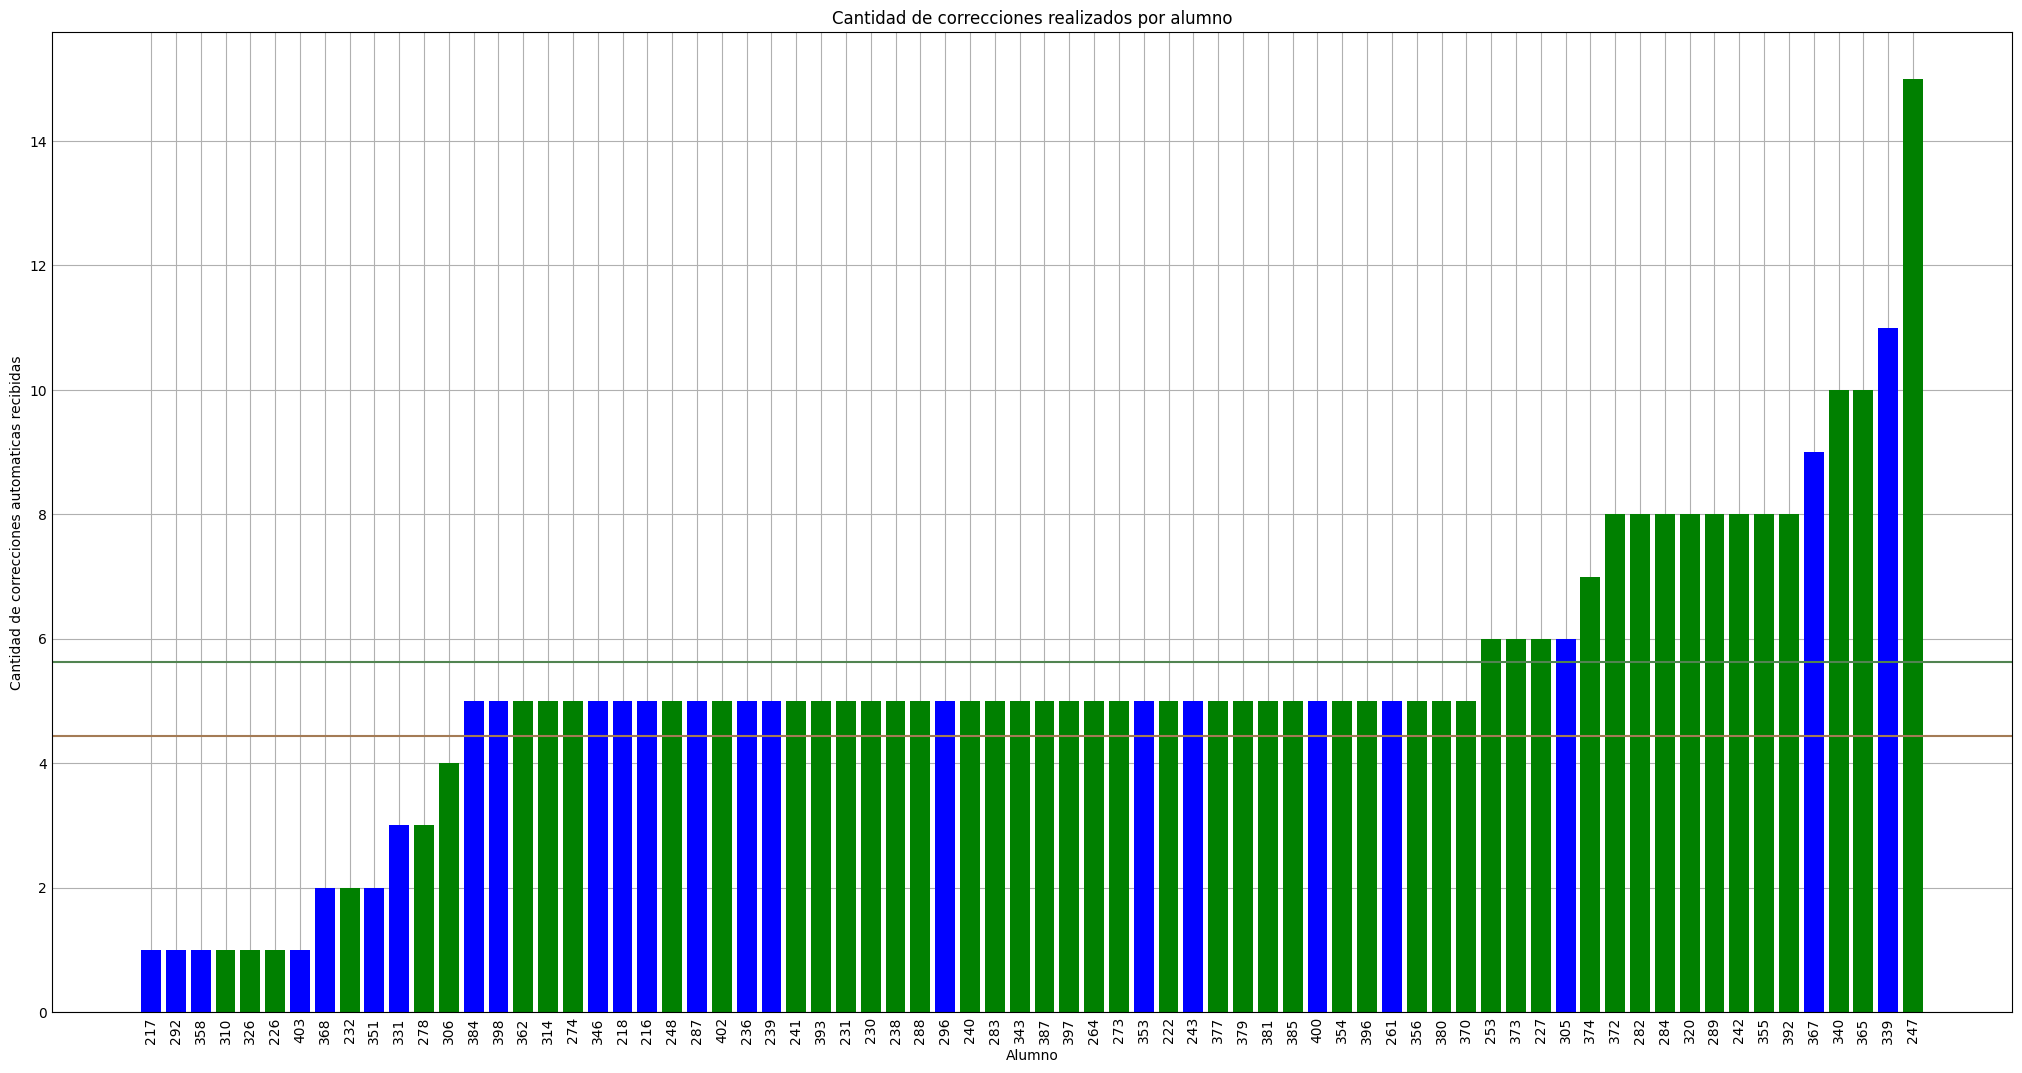

In [115]:
import operator 
x_sorted = sorted(correccion_por_alumno_primeras_unidades.items(), key=operator.itemgetter(1))

items_x = [str(alumno) for alumno, correccion in x_sorted]
items_y = [correccion for alumno, correccion in x_sorted]

colors = []
aprobados = []
desaprobados = []

for alumno in items_x:
    if int(alumno) in alumnos_ids_aprobados:
        colors.append('green')
        aprobados.append(correccion_por_alumno_primeras_unidades[int(alumno)])
    else:
        colors.append('blue')
        desaprobados.append(correccion_por_alumno_primeras_unidades[int(alumno)])
        
media_aprobados = sum(aprobados) / len(aprobados)
media_desaprobados = sum(desaprobados) / len(desaprobados)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y, color=colors)

plt.axhline(y=media_aprobados, color='#518451', linestyle='-')
plt.axhline(y=media_desaprobados, color='#a47b55', linestyle='-')

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de correcciones automaticas recibidas')
ax.set_title('Cantidad de correcciones realizados por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

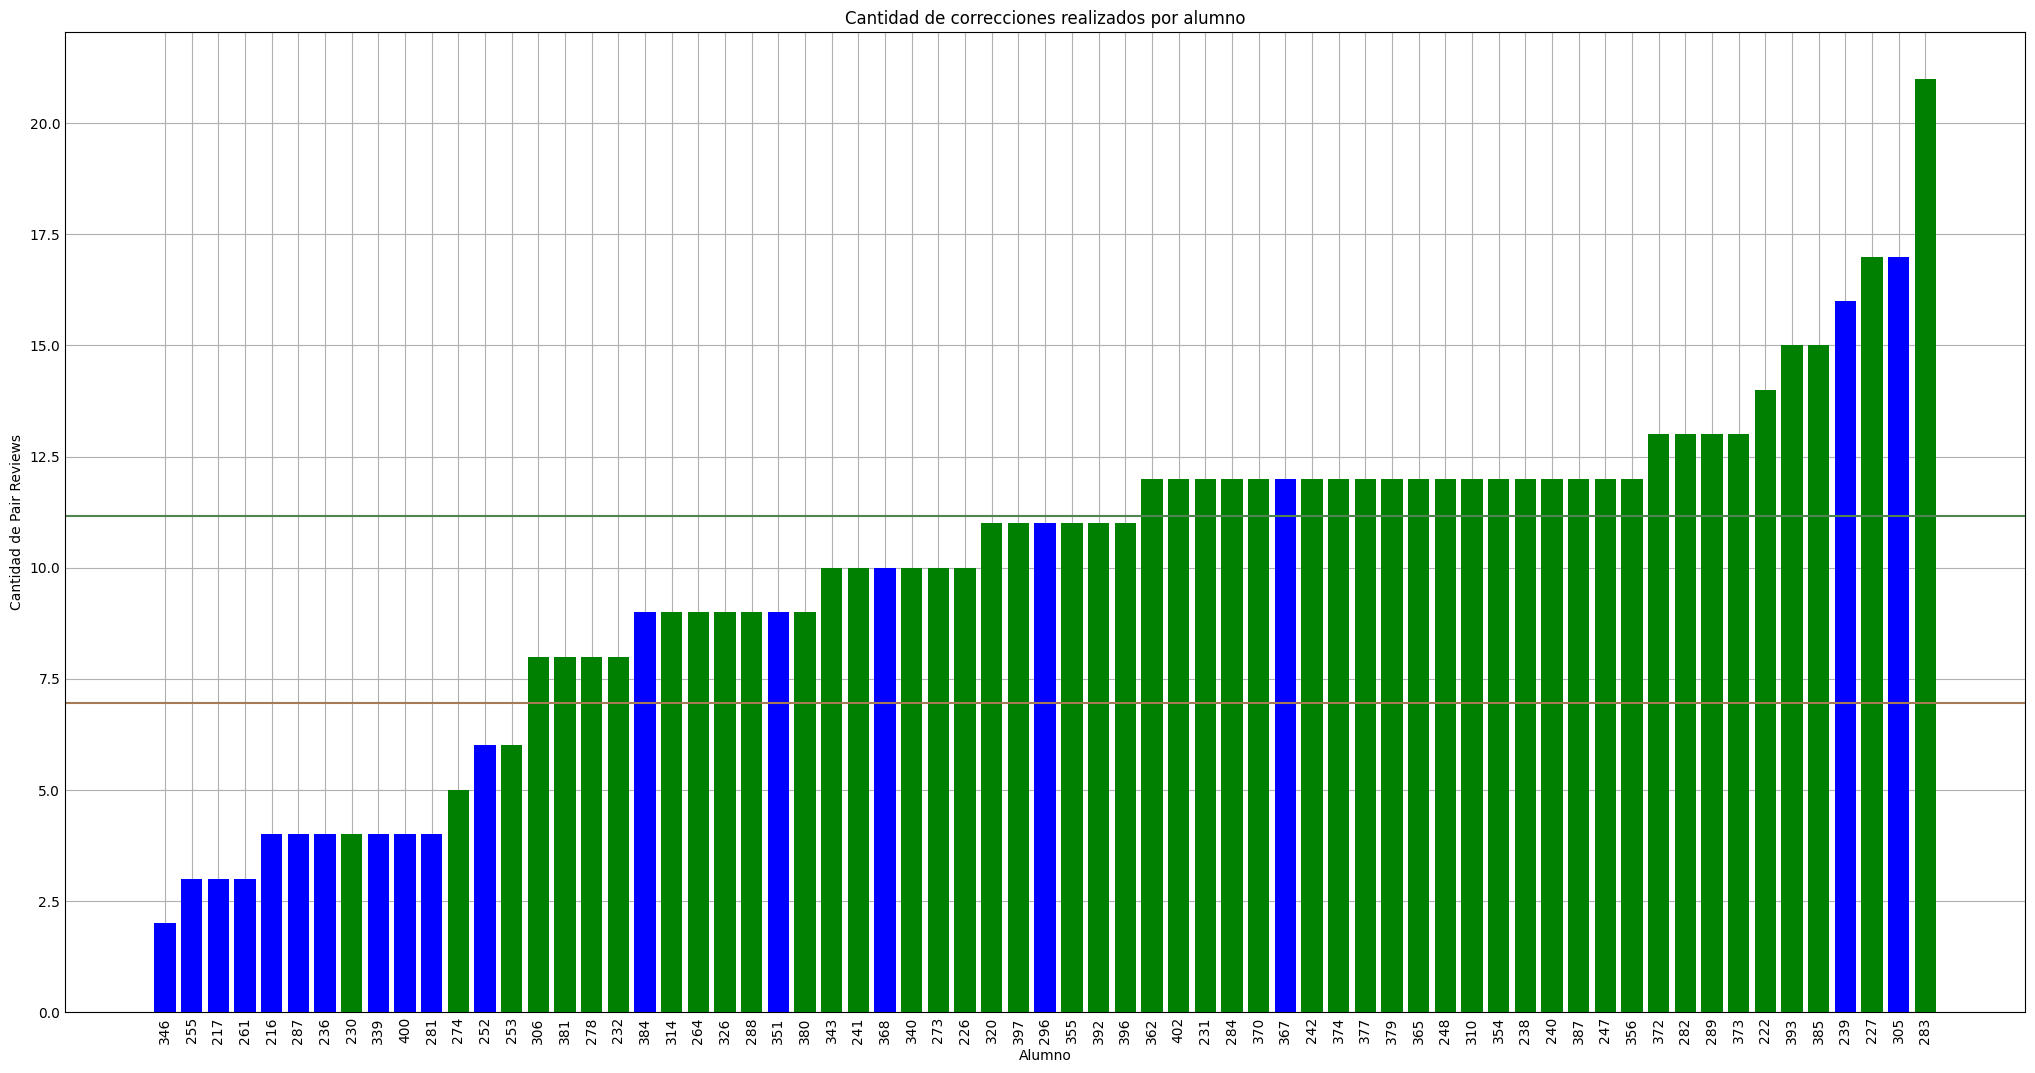

In [116]:
import operator 
x_sorted = sorted(correccion_por_alumno_ultimas_unidades.items(), key=operator.itemgetter(1))

items_x = [str(alumno) for alumno, correccion in x_sorted]
items_y = [correccion for alumno, correccion in x_sorted]

colors = []
aprobados = []
desaprobados = []

for alumno in items_x:
    if int(alumno) in alumnos_ids_aprobados:
        colors.append('green')
        aprobados.append(correccion_por_alumno_ultimas_unidades[int(alumno)])
    else:
        colors.append('blue')
        desaprobados.append(correccion_por_alumno_ultimas_unidades[int(alumno)])
        
media_aprobados = sum(aprobados) / len(aprobados)
media_desaprobados = sum(desaprobados) / len(desaprobados)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(items_x, items_y, color=colors)

plt.axhline(y=media_aprobados, color='#518451', linestyle='-')
plt.axhline(y=media_desaprobados, color='#a47b55', linestyle='-')

ax.set_xlabel('Alumno')
ax.set_ylabel('Cantidad de Pair Reviews')
ax.set_title('Cantidad de correcciones realizados por alumno')
plt.xticks(rotation='vertical')
plt.xticks(items_x)

plt.show()

In [117]:
# Aca hay varios que sobrevivieron la entrega de la unidad 4, pero como les fue? 
# Empezar a armar una estructura con fechas eventos y datos que correspondan con el desarrollo del curso. 
# Valores de referencia del curso (examenes, fechas de publicacion y deadlines, cantidad de ejercicios por unidad,
# que fechas de deploy tuvimos, que ejercicios se corrigieron)
# Ver si los desaprobados se presentaron al parcial o no. Con eso podemos decir si abandonaron o no. 


In [118]:
# Ver si podemos armar una base de datos por alumno todos los features que tenemos para analizar (tiempos, ejer)